In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07
tBoundaryDown = 9
tBoundaryUp = 14

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((tBoundaryUp-tBoundaryDown) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
cm_target[0]

'NACA0018cm_blade1.csv'

In [11]:
str(cm_target[0])

'NACA0018cm_blade1.csv'

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    #total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    x = t
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    file = cm_target
    df = pd.DataFrame()

    data = pd.read_csv(file, header=None)
    df = pd.concat([df, data], axis=0)

    time = df.iloc[:,0].values
    cm = df.iloc[:,1].values

    time_beUsed = time[np.where(np.logical_and(time>=tBoundaryDown, time<tBoundaryUp))]
    cm_beUsed = cm[np.where(np.logical_and(time>=tBoundaryDown, time<tBoundaryUp))]

    # Handle the time that is duplicated because of digits
    # Also, outliers are regulated at the second conditional statement.
    time_beUsed = handler_time(time_beUsed)
    cm_beUsed = handler_cm(cm_beUsed)

    linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                       bounds_error=False,kind='quadratic',
                                       fill_value='extrapolate')
    time_interp = np.arange(tBoundaryDown, tBoundaryUp, t_interval).reshape((-1,1))

    cm_interp=linear_func(time_interp).reshape((-1,1))

    cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and $C_m$: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>10:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target[0], n_beta, t_len, normalize=True)

Dimension - time and $C_m$:  (5000, 2)
Dimension - x:  (5000, 1)
Dimension - y:  (5000, 1)


In [21]:
x -=10

In [22]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [23]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=1)

In [24]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=1)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [25]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20221227_noflap_randomState1(9to14)"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20221226unsteadyPrediction_MLP_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_randomState1(9to14)_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-07,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-8, min_lr=1e-06, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [30]:
model_directory = "D:\\TrainedModels\\20221227"

In [31]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, validation_data=[x_val, y_val], steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_steps=VALIDATION_STEPS, batch_size=batch_size,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/3 [=========>....................] - ETA: 2s - loss: 0.2165 - rmse: 0.4652
Epoch 1: val_loss improved from inf to 0.18549, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 1s 118ms/step - loss: 0.2039 - rmse: 0.4515 - val_loss: 0.1855 - val_rmse: 0.4306 - lr: 1.0000e-04
Epoch 2/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.2048 - rmse: 0.4525
Epoch 2: val_loss improved from 0.18549 to 0.15206, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.1692 - rmse: 0.4112 - val_loss: 0.1521 - val_rmse: 0.3898 - lr: 1.0000e-04
Epoch 3/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1501 - rmse: 0.3873
Epoch 3: val_loss im

3/3 [==============================] - 0s 47ms/step - loss: 0.0836 - rmse: 0.2890 - val_loss: 0.0832 - val_rmse: 0.2883 - lr: 1.0000e-04
Epoch 20/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0884 - rmse: 0.2971
Epoch 20: val_loss improved from 0.08321 to 0.08196, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0810 - rmse: 0.2843 - val_loss: 0.0820 - val_rmse: 0.2861 - lr: 1.0000e-04
Epoch 21/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0840 - rmse: 0.2897
Epoch 21: val_loss improved from 0.08196 to 0.08069, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 37ms/step - loss: 0.0794 - rmse: 0.2816 - val_loss: 0.0807 - v

Epoch 38/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0691 - rmse: 0.2626
Epoch 38: val_loss improved from 0.06589 to 0.06567, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.0694 - rmse: 0.2632 - val_loss: 0.0657 - val_rmse: 0.2561 - lr: 1.0000e-04
Epoch 39/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0631 - rmse: 0.2509
Epoch 39: val_loss improved from 0.06567 to 0.06540, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0652 - rmse: 0.2552 - val_loss: 0.0654 - val_rmse: 0.2555 - lr: 1.0000e-04
Epoch 40/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0647 - rmse: 0.2541
Epoch 40: va

1/3 [=========>....................] - ETA: 0s - loss: 0.0631 - rmse: 0.2509
Epoch 60: val_loss did not improve from 0.06434
3/3 [==============================] - 0s 21ms/step - loss: 0.0642 - rmse: 0.2532 - val_loss: 0.0644 - val_rmse: 0.2535 - lr: 1.0000e-04
Epoch 61/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0682 - rmse: 0.2610
Epoch 61: val_loss improved from 0.06434 to 0.06422, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0662 - rmse: 0.2570 - val_loss: 0.0642 - val_rmse: 0.2532 - lr: 1.0000e-04
Epoch 62/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0617 - rmse: 0.2482
Epoch 62: val_loss improved from 0.06422 to 0.06411, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(

3/3 [==============================] - 0s 44ms/step - loss: 0.0624 - rmse: 0.2495 - val_loss: 0.0624 - val_rmse: 0.2497 - lr: 1.0000e-04
Epoch 80/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0654 - rmse: 0.2556
Epoch 80: val_loss improved from 0.06245 to 0.06226, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0643 - rmse: 0.2533 - val_loss: 0.0623 - val_rmse: 0.2493 - lr: 1.0000e-04
Epoch 81/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0642 - rmse: 0.2531
Epoch 81: val_loss improved from 0.06226 to 0.06200, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0630 - rmse: 0.2507 - val_loss: 0.0620 - v

Epoch 99/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0606 - rmse: 0.2460
Epoch 99: val_loss improved from 0.05934 to 0.05894, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0599 - rmse: 0.2446 - val_loss: 0.0589 - val_rmse: 0.2426 - lr: 1.0000e-04
Epoch 100/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0608 - rmse: 0.2464
Epoch 100: val_loss improved from 0.05894 to 0.05872, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0599 - rmse: 0.2446 - val_loss: 0.0587 - val_rmse: 0.2421 - lr: 1.0000e-04
Epoch 101/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0640 - rmse: 0.2528
Epoch 101

3/3 [==============================] - 0s 48ms/step - loss: 0.0555 - rmse: 0.2354 - val_loss: 0.0539 - val_rmse: 0.2320 - lr: 1.0000e-04
Epoch 118/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0523 - rmse: 0.2284
Epoch 118: val_loss improved from 0.05392 to 0.05388, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0555 - rmse: 0.2354 - val_loss: 0.0539 - val_rmse: 0.2319 - lr: 1.0000e-04
Epoch 119/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0516 - rmse: 0.2270
Epoch 119: val_loss improved from 0.05388 to 0.05355, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0527 - rmse: 0.2293 - val_loss: 0.0536

Epoch 136/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0488 - rmse: 0.2206
Epoch 136: val_loss improved from 0.04817 to 0.04803, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0482 - rmse: 0.2194 - val_loss: 0.0480 - val_rmse: 0.2189 - lr: 1.0000e-04
Epoch 137/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0492 - rmse: 0.2215
Epoch 137: val_loss improved from 0.04803 to 0.04770, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0476 - rmse: 0.2180 - val_loss: 0.0477 - val_rmse: 0.2182 - lr: 1.0000e-04
Epoch 138/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0530 - rmse: 0.2299
Epoch 1

Epoch 155/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0431 - rmse: 0.2073
Epoch 155: val_loss improved from 0.04437 to 0.04409, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0436 - rmse: 0.2086 - val_loss: 0.0441 - val_rmse: 0.2097 - lr: 1.0000e-04
Epoch 156/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0428 - rmse: 0.2066
Epoch 156: val_loss improved from 0.04409 to 0.04409, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0438 - rmse: 0.2091 - val_loss: 0.0441 - val_rmse: 0.2097 - lr: 1.0000e-04
Epoch 157/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0446 - rmse: 0.2108
Epoch 1

Epoch 175/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0430 - rmse: 0.2071
Epoch 175: val_loss did not improve from 0.04258
3/3 [==============================] - 0s 22ms/step - loss: 0.0422 - rmse: 0.2052 - val_loss: 0.0426 - val_rmse: 0.2061 - lr: 1.0000e-04
Epoch 176/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0464 - rmse: 0.2151
Epoch 176: val_loss improved from 0.04258 to 0.04243, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0430 - rmse: 0.2070 - val_loss: 0.0424 - val_rmse: 0.2057 - lr: 1.0000e-04
Epoch 177/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0443 - rmse: 0.2102
Epoch 177: val_loss improved from 0.04243 to 0.04240, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_2

3/3 [==============================] - 0s 52ms/step - loss: 0.0415 - rmse: 0.2035 - val_loss: 0.0418 - val_rmse: 0.2041 - lr: 1.0000e-04
Epoch 197/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0353 - rmse: 0.1876
Epoch 197: val_loss did not improve from 0.04175
3/3 [==============================] - 0s 22ms/step - loss: 0.0411 - rmse: 0.2025 - val_loss: 0.0418 - val_rmse: 0.2042 - lr: 1.0000e-04
Epoch 198/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0442 - rmse: 0.2101
Epoch 198: val_loss improved from 0.04175 to 0.04174, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0420 - rmse: 0.2047 - val_loss: 0.0417 - val_rmse: 0.2040 - lr: 1.0000e-04
Epoch 199/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0401 - rmse: 0.2000
Epoch 199: val_loss improved from 0.04174

3/3 [==============================] - 0s 46ms/step - loss: 0.0412 - rmse: 0.2027 - val_loss: 0.0413 - val_rmse: 0.2030 - lr: 1.0000e-04
Epoch 219/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0422 - rmse: 0.2052
Epoch 219: val_loss improved from 0.04131 to 0.04128, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0397 - rmse: 0.1990 - val_loss: 0.0413 - val_rmse: 0.2029 - lr: 1.0000e-04
Epoch 220/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0417 - rmse: 0.2041
Epoch 220: val_loss did not improve from 0.04128
3/3 [==============================] - 0s 22ms/step - loss: 0.0427 - rmse: 0.2064 - val_loss: 0.0414 - val_rmse: 0.2032 - lr: 1.0000e-04
Epoch 221/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0448 - rmse: 0.2115
Epoch 221: val_loss did not improve from 

Epoch 245/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0426 - rmse: 0.2061
Epoch 245: val_loss improved from 0.04087 to 0.04083, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0407 - rmse: 0.2015 - val_loss: 0.0408 - val_rmse: 0.2018 - lr: 1.0000e-04
Epoch 246/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0410 - rmse: 0.2023
Epoch 246: val_loss did not improve from 0.04083
3/3 [==============================] - 0s 22ms/step - loss: 0.0413 - rmse: 0.2031 - val_loss: 0.0411 - val_rmse: 0.2024 - lr: 1.0000e-04
Epoch 247/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0390 - rmse: 0.1972
Epoch 247: val_loss did not improve from 0.04083
3/3 [==============================] - 0s 22ms/step - loss: 0.0401 - rmse: 0.2000 - val_loss: 0.0409 - val_rmse: 0.2019 - lr: 1.0

1/3 [=========>....................] - ETA: 0s - loss: 0.0415 - rmse: 0.2034
Epoch 270: val_loss improved from 0.04049 to 0.04046, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0393 - rmse: 0.1981 - val_loss: 0.0405 - val_rmse: 0.2009 - lr: 1.0000e-04
Epoch 271/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0427 - rmse: 0.2064
Epoch 271: val_loss improved from 0.04046 to 0.04043, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0416 - rmse: 0.2037 - val_loss: 0.0404 - val_rmse: 0.2008 - lr: 1.0000e-04
Epoch 272/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0399 - rmse: 0.1994
Epoch 272: val_loss imp

Epoch 294/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0369 - rmse: 0.1918
Epoch 294: val_loss did not improve from 0.04027
3/3 [==============================] - 0s 22ms/step - loss: 0.0399 - rmse: 0.1994 - val_loss: 0.0403 - val_rmse: 0.2004 - lr: 1.0000e-04
Epoch 295/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0387 - rmse: 0.1964
Epoch 295: val_loss improved from 0.04027 to 0.04023, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0393 - rmse: 0.1981 - val_loss: 0.0402 - val_rmse: 0.2003 - lr: 1.0000e-04
Epoch 296/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0435 - rmse: 0.2084
Epoch 296: val_loss did not improve from 0.04023
3/3 [==============================] - 0s 21ms/step - loss: 0.0413 - rmse: 0.2029 - val_loss: 0.0403 - val_rmse: 0.2004 - lr: 1.0

1/3 [=========>....................] - ETA: 0s - loss: 0.0379 - rmse: 0.1945
Epoch 320: val_loss improved from 0.04004 to 0.04003, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0409 - rmse: 0.2021 - val_loss: 0.0400 - val_rmse: 0.1998 - lr: 1.0000e-04
Epoch 321/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0446 - rmse: 0.2110
Epoch 321: val_loss improved from 0.04003 to 0.03994, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0400 - rmse: 0.1998 - val_loss: 0.0399 - val_rmse: 0.1996 - lr: 1.0000e-04
Epoch 322/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0403 - rmse: 0.2005
Epoch 322: val_loss did

1/3 [=========>....................] - ETA: 0s - loss: 0.0390 - rmse: 0.1973
Epoch 345: val_loss improved from 0.03985 to 0.03980, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0398 - rmse: 0.1993 - val_loss: 0.0398 - val_rmse: 0.1993 - lr: 1.0000e-04
Epoch 346/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0418 - rmse: 0.2041
Epoch 346: val_loss did not improve from 0.03980
3/3 [==============================] - 0s 22ms/step - loss: 0.0406 - rmse: 0.2012 - val_loss: 0.0400 - val_rmse: 0.1996 - lr: 1.0000e-04
Epoch 347/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0403 - rmse: 0.2006
Epoch 347: val_loss did not improve from 0.03980
3/3 [==============================] - 0s 21ms/step - loss: 0.0389 - rmse: 0.1970 - val_loss: 0.0402 - val_rmse: 0.2002 - lr: 1.0000e-04
Epoch 34

3/3 [==============================] - 0s 23ms/step - loss: 0.0412 - rmse: 0.2026 - val_loss: 0.0402 - val_rmse: 0.2002 - lr: 1.0000e-04
Epoch 372/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0398 - rmse: 0.1994
Epoch 372: val_loss did not improve from 0.03971
3/3 [==============================] - 0s 21ms/step - loss: 0.0394 - rmse: 0.1982 - val_loss: 0.0397 - val_rmse: 0.1990 - lr: 1.0000e-04
Epoch 373/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0406 - rmse: 0.2012
Epoch 373: val_loss did not improve from 0.03971
3/3 [==============================] - 0s 21ms/step - loss: 0.0397 - rmse: 0.1989 - val_loss: 0.0398 - val_rmse: 0.1991 - lr: 1.0000e-04
Epoch 374/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0427 - rmse: 0.2063
Epoch 374: val_loss did not improve from 0.03971
3/3 [==============================] - 0s 21ms/step - loss: 0.0419 - rmse: 0.2043 - val_loss: 0.0403 - val_rmse: 0.2005 - lr: 1.0000e-04
Epoch 375/10000
1/3 [=====

1/3 [=========>....................] - ETA: 0s - loss: 0.0435 - rmse: 0.2084
Epoch 397: val_loss did not improve from 0.03951
3/3 [==============================] - 0s 22ms/step - loss: 0.0403 - rmse: 0.2004 - val_loss: 0.0395 - val_rmse: 0.1985 - lr: 1.0000e-04
Epoch 398/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0383 - rmse: 0.1955
Epoch 398: val_loss did not improve from 0.03951
3/3 [==============================] - 0s 21ms/step - loss: 0.0387 - rmse: 0.1965 - val_loss: 0.0395 - val_rmse: 0.1985 - lr: 1.0000e-04
Epoch 399/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0413 - rmse: 0.2030
Epoch 399: val_loss did not improve from 0.03951
3/3 [==============================] - 0s 22ms/step - loss: 0.0402 - rmse: 0.2003 - val_loss: 0.0395 - val_rmse: 0.1986 - lr: 1.0000e-04
Epoch 400/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0372 - rmse: 0.1927
Epoch 400: val_loss did not improve from 0.03951
3/3 [==============================] 

3/3 [==============================] - 0s 21ms/step - loss: 0.0411 - rmse: 0.2026 - val_loss: 0.0394 - val_rmse: 0.1983 - lr: 1.0000e-04
Epoch 424/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0418 - rmse: 0.2042
Epoch 424: val_loss did not improve from 0.03935
3/3 [==============================] - 0s 21ms/step - loss: 0.0395 - rmse: 0.1984 - val_loss: 0.0395 - val_rmse: 0.1984 - lr: 1.0000e-04
Epoch 425/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0422 - rmse: 0.2051
Epoch 425: val_loss did not improve from 0.03935
3/3 [==============================] - 0s 21ms/step - loss: 0.0399 - rmse: 0.1994 - val_loss: 0.0394 - val_rmse: 0.1984 - lr: 1.0000e-04
Epoch 426/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0399 - rmse: 0.1995
Epoch 426: val_loss did not improve from 0.03935
3/3 [==============================] - 0s 22ms/step - loss: 0.0404 - rmse: 0.2007 - val_loss: 0.0395 - val_rmse: 0.1984 - lr: 1.0000e-04
Epoch 427/10000
1/3 [=====

3/3 [==============================] - 0s 22ms/step - loss: 0.0382 - rmse: 0.1953 - val_loss: 0.0399 - val_rmse: 0.1994 - lr: 1.0000e-04
Epoch 451/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0443 - rmse: 0.2103
Epoch 451: val_loss did not improve from 0.03921
3/3 [==============================] - 0s 22ms/step - loss: 0.0413 - rmse: 0.2031 - val_loss: 0.0396 - val_rmse: 0.1988 - lr: 1.0000e-04
Epoch 452/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0405 - rmse: 0.2010
Epoch 452: val_loss improved from 0.03921 to 0.03920, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0407 - rmse: 0.2015 - val_loss: 0.0392 - val_rmse: 0.1977 - lr: 1.0000e-04
Epoch 453/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0407 - rmse: 0.2015
Epoch 453: val_loss did not improve from 

Epoch 474/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0351 - rmse: 0.1872
Epoch 474: val_loss did not improve from 0.03899
3/3 [==============================] - 0s 22ms/step - loss: 0.0378 - rmse: 0.1943 - val_loss: 0.0396 - val_rmse: 0.1987 - lr: 1.0000e-04
Epoch 475/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0385 - rmse: 0.1960
Epoch 475: val_loss did not improve from 0.03899
3/3 [==============================] - 0s 21ms/step - loss: 0.0408 - rmse: 0.2018 - val_loss: 0.0397 - val_rmse: 0.1991 - lr: 1.0000e-04
Epoch 476/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0400 - rmse: 0.1997
Epoch 476: val_loss improved from 0.03899 to 0.03890, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0401 - rmse: 0.2000 - val_loss: 0.0389 - val_rmse: 0.1970 - lr: 1.0

3/3 [==============================] - 0s 54ms/step - loss: 0.0389 - rmse: 0.1969 - val_loss: 0.0387 - val_rmse: 0.1966 - lr: 1.0000e-04
Epoch 502/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0432 - rmse: 0.2076
Epoch 502: val_loss did not improve from 0.03874
3/3 [==============================] - 0s 22ms/step - loss: 0.0402 - rmse: 0.2004 - val_loss: 0.0388 - val_rmse: 0.1968 - lr: 1.0000e-04
Epoch 503/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0380 - rmse: 0.1947
Epoch 503: val_loss did not improve from 0.03874
3/3 [==============================] - 0s 21ms/step - loss: 0.0393 - rmse: 0.1981 - val_loss: 0.0388 - val_rmse: 0.1966 - lr: 1.0000e-04
Epoch 504/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0356 - rmse: 0.1885
Epoch 504: val_loss improved from 0.03874 to 0.03871, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkp

3/3 [==============================] - 0s 50ms/step - loss: 0.0373 - rmse: 0.1928 - val_loss: 0.0384 - val_rmse: 0.1957 - lr: 1.0000e-04
Epoch 529/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0385 - rmse: 0.1960
Epoch 529: val_loss did not improve from 0.03839
3/3 [==============================] - 0s 22ms/step - loss: 0.0388 - rmse: 0.1968 - val_loss: 0.0384 - val_rmse: 0.1958 - lr: 1.0000e-04
Epoch 530/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0414 - rmse: 0.2033
Epoch 530: val_loss did not improve from 0.03839
3/3 [==============================] - 0s 21ms/step - loss: 0.0405 - rmse: 0.2010 - val_loss: 0.0385 - val_rmse: 0.1960 - lr: 1.0000e-04
Epoch 531/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0360 - rmse: 0.1894
Epoch 531: val_loss did not improve from 0.03839
3/3 [==============================] - 0s 22ms/step - loss: 0.0394 - rmse: 0.1982 - val_loss: 0.0385 - val_rmse: 0.1961 - lr: 1.0000e-04
Epoch 532/10000
1/3 [=====

Epoch 555/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0390 - rmse: 0.1973
Epoch 555: val_loss did not improve from 0.03816
3/3 [==============================] - 0s 20ms/step - loss: 0.0394 - rmse: 0.1982 - val_loss: 0.0384 - val_rmse: 0.1957 - lr: 1.0000e-04
Epoch 556/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0368 - rmse: 0.1916
Epoch 556: val_loss did not improve from 0.03816
3/3 [==============================] - 0s 21ms/step - loss: 0.0375 - rmse: 0.1933 - val_loss: 0.0382 - val_rmse: 0.1953 - lr: 1.0000e-04
Epoch 557/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0353 - rmse: 0.1876
Epoch 557: val_loss improved from 0.03816 to 0.03804, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0381 - rmse: 0.1949 - val_loss: 0.0380 - val_rmse: 0.1948 - lr: 1.0

1/3 [=========>....................] - ETA: 0s - loss: 0.0382 - rmse: 0.1952
Epoch 580: val_loss did not improve from 0.03787
3/3 [==============================] - 0s 21ms/step - loss: 0.0372 - rmse: 0.1927 - val_loss: 0.0380 - val_rmse: 0.1947 - lr: 1.0000e-04
Epoch 581/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0348 - rmse: 0.1862
Epoch 581: val_loss improved from 0.03787 to 0.03786, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0390 - rmse: 0.1972 - val_loss: 0.0379 - val_rmse: 0.1943 - lr: 1.0000e-04
Epoch 582/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0382 - rmse: 0.1953
Epoch 582: val_loss did not improve from 0.03786
3/3 [==============================] - 0s 20ms/step - loss: 0.0384 - rmse: 0.1957 - val_loss: 0.0380 - val_rmse: 0.1946 - lr: 1.0000e-04
Epoch 58

Epoch 605/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0375 - rmse: 0.1933
Epoch 605: val_loss improved from 0.03756 to 0.03753, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0378 - rmse: 0.1942 - val_loss: 0.0375 - val_rmse: 0.1935 - lr: 1.0000e-04
Epoch 606/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0427 - rmse: 0.2065
Epoch 606: val_loss did not improve from 0.03753
3/3 [==============================] - 0s 21ms/step - loss: 0.0390 - rmse: 0.1973 - val_loss: 0.0380 - val_rmse: 0.1946 - lr: 1.0000e-04
Epoch 607/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0387 - rmse: 0.1964
Epoch 607: val_loss did not improve from 0.03753
3/3 [==============================] - 0s 21ms/step - loss: 0.0390 - rmse: 0.1972 - val_loss: 0.0378 - val_rmse: 0.1942 - lr: 1.0

3/3 [==============================] - 0s 52ms/step - loss: 0.0379 - rmse: 0.1943 - val_loss: 0.0370 - val_rmse: 0.1921 - lr: 1.0000e-04
Epoch 630/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0392 - rmse: 0.1976
Epoch 630: val_loss did not improve from 0.03701
3/3 [==============================] - 0s 22ms/step - loss: 0.0379 - rmse: 0.1946 - val_loss: 0.0373 - val_rmse: 0.1928 - lr: 1.0000e-04
Epoch 631/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0385 - rmse: 0.1959
Epoch 631: val_loss did not improve from 0.03701
3/3 [==============================] - 0s 21ms/step - loss: 0.0380 - rmse: 0.1948 - val_loss: 0.0372 - val_rmse: 0.1927 - lr: 1.0000e-04
Epoch 632/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0402 - rmse: 0.2003
Epoch 632: val_loss did not improve from 0.03701
3/3 [==============================] - 0s 22ms/step - loss: 0.0383 - rmse: 0.1956 - val_loss: 0.0371 - val_rmse: 0.1923 - lr: 1.0000e-04
Epoch 633/10000
1/3 [=====

Epoch 655/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0368 - rmse: 0.1917
Epoch 655: val_loss did not improve from 0.03653
3/3 [==============================] - 0s 21ms/step - loss: 0.0379 - rmse: 0.1946 - val_loss: 0.0380 - val_rmse: 0.1946 - lr: 1.0000e-04
Epoch 656/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0376 - rmse: 0.1937
Epoch 656: val_loss did not improve from 0.03653
3/3 [==============================] - 0s 21ms/step - loss: 0.0388 - rmse: 0.1967 - val_loss: 0.0374 - val_rmse: 0.1932 - lr: 1.0000e-04
Epoch 657/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0359 - rmse: 0.1892
Epoch 657: val_loss did not improve from 0.03653
3/3 [==============================] - 0s 21ms/step - loss: 0.0379 - rmse: 0.1943 - val_loss: 0.0371 - val_rmse: 0.1925 - lr: 1.0000e-04
Epoch 658/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0400 - rmse: 0.1999
Epoch 658: val_loss did not improve from 0.03653
3/3 [================

Epoch 682/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0376 - rmse: 0.1935
Epoch 682: val_loss improved from 0.03627 to 0.03624, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0368 - rmse: 0.1916 - val_loss: 0.0362 - val_rmse: 0.1901 - lr: 1.0000e-04
Epoch 683/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0363 - rmse: 0.1902
Epoch 683: val_loss improved from 0.03624 to 0.03610, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0384 - rmse: 0.1958 - val_loss: 0.0361 - val_rmse: 0.1898 - lr: 1.0000e-04
Epoch 684/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0353 - rmse: 0.1875
Epoch 6

Epoch 708/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0419 - rmse: 0.2044
Epoch 708: val_loss did not improve from 0.03568
3/3 [==============================] - 0s 22ms/step - loss: 0.0371 - rmse: 0.1924 - val_loss: 0.0358 - val_rmse: 0.1890 - lr: 1.0000e-04
Epoch 709/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0336 - rmse: 0.1831
Epoch 709: val_loss did not improve from 0.03568
3/3 [==============================] - 0s 21ms/step - loss: 0.0371 - rmse: 0.1924 - val_loss: 0.0358 - val_rmse: 0.1890 - lr: 1.0000e-04
Epoch 710/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0363 - rmse: 0.1904
Epoch 710: val_loss did not improve from 0.03568
3/3 [==============================] - 0s 22ms/step - loss: 0.0359 - rmse: 0.1892 - val_loss: 0.0357 - val_rmse: 0.1887 - lr: 1.0000e-04
Epoch 711/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0370 - rmse: 0.1921
Epoch 711: val_loss did not improve from 0.03568
3/3 [================

1/3 [=========>....................] - ETA: 0s - loss: 0.0377 - rmse: 0.1940
Epoch 733: val_loss did not improve from 0.03496
3/3 [==============================] - 0s 21ms/step - loss: 0.0363 - rmse: 0.1904 - val_loss: 0.0351 - val_rmse: 0.1871 - lr: 1.0000e-04
Epoch 734/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0364 - rmse: 0.1905
Epoch 734: val_loss improved from 0.03496 to 0.03495, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0351 - rmse: 0.1872 - val_loss: 0.0349 - val_rmse: 0.1867 - lr: 1.0000e-04
Epoch 735/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0383 - rmse: 0.1956
Epoch 735: val_loss did not improve from 0.03495
3/3 [==============================] - 0s 21ms/step - loss: 0.0368 - rmse: 0.1916 - val_loss: 0.0351 - val_rmse: 0.1872 - lr: 1.0000e-04
Epoch 73

Epoch 759/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0319 - rmse: 0.1785
Epoch 759: val_loss improved from 0.03460 to 0.03437, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0354 - rmse: 0.1879 - val_loss: 0.0344 - val_rmse: 0.1851 - lr: 1.0000e-04
Epoch 760/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0336 - rmse: 0.1830
Epoch 760: val_loss did not improve from 0.03437
3/3 [==============================] - 0s 21ms/step - loss: 0.0352 - rmse: 0.1874 - val_loss: 0.0345 - val_rmse: 0.1855 - lr: 1.0000e-04
Epoch 761/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0363 - rmse: 0.1902
Epoch 761: val_loss did not improve from 0.03437
3/3 [==============================] - 0s 21ms/step - loss: 0.0351 - rmse: 0.1872 - val_loss: 0.0347 - val_rmse: 0.1860 - lr: 1.0

Epoch 785/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0336 - rmse: 0.1830
Epoch 785: val_loss improved from 0.03390 to 0.03382, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.0357 - rmse: 0.1888 - val_loss: 0.0338 - val_rmse: 0.1837 - lr: 1.0000e-04
Epoch 786/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0355 - rmse: 0.1881
Epoch 786: val_loss did not improve from 0.03382
3/3 [==============================] - 0s 22ms/step - loss: 0.0363 - rmse: 0.1903 - val_loss: 0.0340 - val_rmse: 0.1841 - lr: 1.0000e-04
Epoch 787/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0369 - rmse: 0.1919
Epoch 787: val_loss did not improve from 0.03382
3/3 [==============================] - 0s 22ms/step - loss: 0.0360 - rmse: 0.1895 - val_loss: 0.0342 - val_rmse: 0.1847 - lr: 1.0

Epoch 811/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0332 - rmse: 0.1821
Epoch 811: val_loss did not improve from 0.03325
3/3 [==============================] - 0s 22ms/step - loss: 0.0356 - rmse: 0.1885 - val_loss: 0.0346 - val_rmse: 0.1857 - lr: 1.0000e-04
Epoch 812/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0349 - rmse: 0.1865
Epoch 812: val_loss did not improve from 0.03325
3/3 [==============================] - 0s 23ms/step - loss: 0.0348 - rmse: 0.1862 - val_loss: 0.0334 - val_rmse: 0.1826 - lr: 1.0000e-04
Epoch 813/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0353 - rmse: 0.1877
Epoch 813: val_loss did not improve from 0.03325
3/3 [==============================] - 0s 22ms/step - loss: 0.0360 - rmse: 0.1895 - val_loss: 0.0341 - val_rmse: 0.1845 - lr: 1.0000e-04
Epoch 814/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0312 - rmse: 0.1765
Epoch 814: val_loss did not improve from 0.03325
3/3 [================

Epoch 838/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0360 - rmse: 0.1895
Epoch 838: val_loss improved from 0.03240 to 0.03221, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0341 - rmse: 0.1845 - val_loss: 0.0322 - val_rmse: 0.1792 - lr: 1.0000e-04
Epoch 839/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0336 - rmse: 0.1831
Epoch 839: val_loss improved from 0.03221 to 0.03219, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0333 - rmse: 0.1822 - val_loss: 0.0322 - val_rmse: 0.1792 - lr: 1.0000e-04
Epoch 840/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0346 - rmse: 0.1859
Epoch 8

3/3 [==============================] - 0s 21ms/step - loss: 0.0328 - rmse: 0.1810 - val_loss: 0.0315 - val_rmse: 0.1773 - lr: 1.0000e-04
Epoch 863/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0356 - rmse: 0.1884
Epoch 863: val_loss did not improve from 0.03134
3/3 [==============================] - 0s 21ms/step - loss: 0.0342 - rmse: 0.1848 - val_loss: 0.0320 - val_rmse: 0.1785 - lr: 1.0000e-04
Epoch 864/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0338 - rmse: 0.1835
Epoch 864: val_loss did not improve from 0.03134
3/3 [==============================] - 0s 21ms/step - loss: 0.0336 - rmse: 0.1831 - val_loss: 0.0321 - val_rmse: 0.1788 - lr: 1.0000e-04
Epoch 865/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0341 - rmse: 0.1845
Epoch 865: val_loss did not improve from 0.03134
3/3 [==============================] - 0s 22ms/step - loss: 0.0326 - rmse: 0.1804 - val_loss: 0.0321 - val_rmse: 0.1789 - lr: 1.0000e-04
Epoch 866/10000
1/3 [=====

3/3 [==============================] - 0s 21ms/step - loss: 0.0318 - rmse: 0.1780 - val_loss: 0.0308 - val_rmse: 0.1754 - lr: 1.0000e-04
Epoch 887/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0329 - rmse: 0.1812
Epoch 887: val_loss did not improve from 0.03037
3/3 [==============================] - 0s 21ms/step - loss: 0.0334 - rmse: 0.1825 - val_loss: 0.0311 - val_rmse: 0.1762 - lr: 1.0000e-04
Epoch 888/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0312 - rmse: 0.1763
Epoch 888: val_loss did not improve from 0.03037
3/3 [==============================] - 0s 22ms/step - loss: 0.0323 - rmse: 0.1793 - val_loss: 0.0307 - val_rmse: 0.1748 - lr: 1.0000e-04
Epoch 889/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0313 - rmse: 0.1766
Epoch 889: val_loss did not improve from 0.03037
3/3 [==============================] - 0s 21ms/step - loss: 0.0323 - rmse: 0.1794 - val_loss: 0.0311 - val_rmse: 0.1762 - lr: 1.0000e-04
Epoch 890/10000
1/3 [=====

Epoch 913/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0307 - rmse: 0.1749
Epoch 913: val_loss improved from 0.02942 to 0.02929, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0308 - rmse: 0.1752 - val_loss: 0.0293 - val_rmse: 0.1709 - lr: 1.0000e-04
Epoch 914/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0292 - rmse: 0.1707
Epoch 914: val_loss improved from 0.02929 to 0.02893, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0302 - rmse: 0.1736 - val_loss: 0.0289 - val_rmse: 0.1698 - lr: 1.0000e-04
Epoch 915/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0331 - rmse: 0.1816
Epoch 9

3/3 [==============================] - 0s 22ms/step - loss: 0.0307 - rmse: 0.1750 - val_loss: 0.0297 - val_rmse: 0.1720 - lr: 1.0000e-04
Epoch 938/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0323 - rmse: 0.1795
Epoch 938: val_loss did not improve from 0.02816
3/3 [==============================] - 0s 22ms/step - loss: 0.0292 - rmse: 0.1705 - val_loss: 0.0283 - val_rmse: 0.1680 - lr: 1.0000e-04
Epoch 939/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0311 - rmse: 0.1760
Epoch 939: val_loss improved from 0.02816 to 0.02802, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 58ms/step - loss: 0.0316 - rmse: 0.1776 - val_loss: 0.0280 - val_rmse: 0.1671 - lr: 1.0000e-04
Epoch 940/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0284 - rmse: 0.1683
Epoch 940: val_loss improved from 0.02802

3/3 [==============================] - 0s 21ms/step - loss: 0.0289 - rmse: 0.1697 - val_loss: 0.0275 - val_rmse: 0.1657 - lr: 1.0000e-04
Epoch 962/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0261 - rmse: 0.1612
Epoch 962: val_loss did not improve from 0.02655
3/3 [==============================] - 0s 22ms/step - loss: 0.0275 - rmse: 0.1656 - val_loss: 0.0268 - val_rmse: 0.1633 - lr: 1.0000e-04
Epoch 963/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0282 - rmse: 0.1677
Epoch 963: val_loss improved from 0.02655 to 0.02643, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0293 - rmse: 0.1710 - val_loss: 0.0264 - val_rmse: 0.1623 - lr: 1.0000e-04
Epoch 964/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0259 - rmse: 0.1606
Epoch 964: val_loss did not improve from 

1/3 [=========>....................] - ETA: 0s - loss: 0.0264 - rmse: 0.1622
Epoch 987: val_loss did not improve from 0.02512
3/3 [==============================] - 0s 21ms/step - loss: 0.0263 - rmse: 0.1619 - val_loss: 0.0252 - val_rmse: 0.1586 - lr: 1.0000e-04
Epoch 988/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0280 - rmse: 0.1671
Epoch 988: val_loss improved from 0.02512 to 0.02477, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0269 - rmse: 0.1639 - val_loss: 0.0248 - val_rmse: 0.1571 - lr: 1.0000e-04
Epoch 989/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0257 - rmse: 0.1599
Epoch 989: val_loss did not improve from 0.02477
3/3 [==============================] - 0s 22ms/step - loss: 0.0263 - rmse: 0.1619 - val_loss: 0.0251 - val_rmse: 0.1581 - lr: 1.0000e-04
Epoch 99

3/3 [==============================] - 0s 49ms/step - loss: 0.0249 - rmse: 0.1575 - val_loss: 0.0234 - val_rmse: 0.1528 - lr: 1.0000e-04
Epoch 1012/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0230 - rmse: 0.1513
Epoch 1012: val_loss did not improve from 0.02343
3/3 [==============================] - 0s 22ms/step - loss: 0.0255 - rmse: 0.1593 - val_loss: 0.0246 - val_rmse: 0.1567 - lr: 1.0000e-04
Epoch 1013/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0250 - rmse: 0.1578
Epoch 1013: val_loss did not improve from 0.02343
3/3 [==============================] - 0s 22ms/step - loss: 0.0257 - rmse: 0.1600 - val_loss: 0.0248 - val_rmse: 0.1571 - lr: 1.0000e-04
Epoch 1014/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0254 - rmse: 0.1592
Epoch 1014: val_loss did not improve from 0.02343
3/3 [==============================] - 0s 22ms/step - loss: 0.0251 - rmse: 0.1582 - val_loss: 0.0257 - val_rmse: 0.1600 - lr: 1.0000e-04
Epoch 1015/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0247 - rmse: 0.1568
Epoch 1038: val_loss did not improve from 0.02234
3/3 [==============================] - 0s 22ms/step - loss: 0.0241 - rmse: 0.1548 - val_loss: 0.0234 - val_rmse: 0.1528 - lr: 1.0000e-04
Epoch 1039/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0239 - rmse: 0.1542
Epoch 1039: val_loss did not improve from 0.02234
3/3 [==============================] - 0s 22ms/step - loss: 0.0244 - rmse: 0.1559 - val_loss: 0.0231 - val_rmse: 0.1517 - lr: 1.0000e-04
Epoch 1040/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0248 - rmse: 0.1571
Epoch 1040: val_loss improved from 0.02234 to 0.02164, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0248 - rmse: 0.1571 - val_loss: 0.0216 - val_rmse: 0.1468 - lr: 1.0000e-04
Epo

Epoch 1063/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0212 - rmse: 0.1452
Epoch 1063: val_loss did not improve from 0.02051
3/3 [==============================] - 0s 22ms/step - loss: 0.0236 - rmse: 0.1532 - val_loss: 0.0206 - val_rmse: 0.1434 - lr: 1.0000e-04
Epoch 1064/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0214 - rmse: 0.1461
Epoch 1064: val_loss did not improve from 0.02051
3/3 [==============================] - 0s 21ms/step - loss: 0.0212 - rmse: 0.1452 - val_loss: 0.0223 - val_rmse: 0.1490 - lr: 1.0000e-04
Epoch 1065/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0215 - rmse: 0.1462
Epoch 1065: val_loss did not improve from 0.02051
3/3 [==============================] - 0s 22ms/step - loss: 0.0229 - rmse: 0.1509 - val_loss: 0.0211 - val_rmse: 0.1448 - lr: 1.0000e-04
Epoch 1066/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0253 - rmse: 0.1589
Epoch 1066: val_loss improved from 0.02051 to 0.02029, saving m

Epoch 1090/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0199 - rmse: 0.1407
Epoch 1090: val_loss did not improve from 0.01941
3/3 [==============================] - 0s 21ms/step - loss: 0.0230 - rmse: 0.1512 - val_loss: 0.0195 - val_rmse: 0.1393 - lr: 1.0000e-04
Epoch 1091/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0208 - rmse: 0.1439
Epoch 1091: val_loss did not improve from 0.01941
3/3 [==============================] - 0s 21ms/step - loss: 0.0210 - rmse: 0.1446 - val_loss: 0.0197 - val_rmse: 0.1400 - lr: 1.0000e-04
Epoch 1092/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0194 - rmse: 0.1391
Epoch 1092: val_loss did not improve from 0.01941
3/3 [==============================] - 0s 23ms/step - loss: 0.0225 - rmse: 0.1498 - val_loss: 0.0233 - val_rmse: 0.1522 - lr: 1.0000e-04
Epoch 1093/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0248 - rmse: 0.1572
Epoch 1093: val_loss did not improve from 0.01941
3/3 [========

3/3 [==============================] - 0s 45ms/step - loss: 0.0195 - rmse: 0.1393 - val_loss: 0.0177 - val_rmse: 0.1327 - lr: 1.0000e-04
Epoch 1116/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0200 - rmse: 0.1411
Epoch 1116: val_loss did not improve from 0.01771
3/3 [==============================] - 0s 21ms/step - loss: 0.0187 - rmse: 0.1363 - val_loss: 0.0183 - val_rmse: 0.1349 - lr: 1.0000e-04
Epoch 1117/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0195 - rmse: 0.1392
Epoch 1117: val_loss improved from 0.01771 to 0.01763, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0192 - rmse: 0.1381 - val_loss: 0.0176 - val_rmse: 0.1324 - lr: 1.0000e-04
Epoch 1118/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0204 - rmse: 0.1427
Epoch 1118: val_loss improved from 0

1/3 [=========>....................] - ETA: 0s - loss: 0.0196 - rmse: 0.1398
Epoch 1141: val_loss did not improve from 0.01698
3/3 [==============================] - 0s 21ms/step - loss: 0.0194 - rmse: 0.1389 - val_loss: 0.0193 - val_rmse: 0.1386 - lr: 1.0000e-04
Epoch 1142/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0211 - rmse: 0.1449
Epoch 1142: val_loss did not improve from 0.01698
3/3 [==============================] - 0s 21ms/step - loss: 0.0190 - rmse: 0.1374 - val_loss: 0.0180 - val_rmse: 0.1340 - lr: 1.0000e-04
Epoch 1143/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0209 - rmse: 0.1443
Epoch 1143: val_loss did not improve from 0.01698
3/3 [==============================] - 0s 22ms/step - loss: 0.0191 - rmse: 0.1378 - val_loss: 0.0195 - val_rmse: 0.1393 - lr: 1.0000e-04
Epoch 1144/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0212 - rmse: 0.1453
Epoch 1144: val_loss did not improve from 0.01698
3/3 [=========================

Epoch 1166/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1157
Epoch 1166: val_loss did not improve from 0.01550
3/3 [==============================] - 0s 21ms/step - loss: 0.0163 - rmse: 0.1272 - val_loss: 0.0158 - val_rmse: 0.1254 - lr: 1.0000e-04
Epoch 1167/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0162 - rmse: 0.1268
Epoch 1167: val_loss did not improve from 0.01550
3/3 [==============================] - 0s 22ms/step - loss: 0.0168 - rmse: 0.1291 - val_loss: 0.0164 - val_rmse: 0.1279 - lr: 1.0000e-04
Epoch 1168/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0195 - rmse: 0.1394
Epoch 1168: val_loss did not improve from 0.01550
3/3 [==============================] - 0s 21ms/step - loss: 0.0181 - rmse: 0.1342 - val_loss: 0.0162 - val_rmse: 0.1268 - lr: 1.0000e-04
Epoch 1169/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0185 - rmse: 0.1357
Epoch 1169: val_loss improved from 0.01550 to 0.01537, saving m

3/3 [==============================] - 0s 68ms/step - loss: 0.0165 - rmse: 0.1280 - val_loss: 0.0144 - val_rmse: 0.1195 - lr: 1.0000e-04
Epoch 1192/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0153 - rmse: 0.1233
Epoch 1192: val_loss did not improve from 0.01438
3/3 [==============================] - 0s 21ms/step - loss: 0.0155 - rmse: 0.1243 - val_loss: 0.0154 - val_rmse: 0.1236 - lr: 1.0000e-04
Epoch 1193/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0141 - rmse: 0.1182
Epoch 1193: val_loss did not improve from 0.01438
3/3 [==============================] - 0s 21ms/step - loss: 0.0161 - rmse: 0.1265 - val_loss: 0.0145 - val_rmse: 0.1200 - lr: 1.0000e-04
Epoch 1194/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - rmse: 0.1309
Epoch 1194: val_loss did not improve from 0.01438
3/3 [==============================] - 0s 22ms/step - loss: 0.0158 - rmse: 0.1255 - val_loss: 0.0146 - val_rmse: 0.1204 - lr: 1.0000e-04
Epoch 1195/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0168 - rmse: 0.1292
Epoch 1218: val_loss did not improve from 0.01367
3/3 [==============================] - 0s 22ms/step - loss: 0.0151 - rmse: 0.1225 - val_loss: 0.0138 - val_rmse: 0.1173 - lr: 1.0000e-04
Epoch 1219/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0157 - rmse: 0.1248
Epoch 1219: val_loss did not improve from 0.01367
3/3 [==============================] - 0s 21ms/step - loss: 0.0152 - rmse: 0.1231 - val_loss: 0.0139 - val_rmse: 0.1175 - lr: 1.0000e-04
Epoch 1220/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0157 - rmse: 0.1248
Epoch 1220: val_loss improved from 0.01367 to 0.01359, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0155 - rmse: 0.1242 - val_loss: 0.0136 - val_rmse: 0.1162 - lr: 1.0000e-04
Epo

Epoch 1245/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0153 - rmse: 0.1234
Epoch 1245: val_loss did not improve from 0.01305
3/3 [==============================] - 0s 22ms/step - loss: 0.0154 - rmse: 0.1238 - val_loss: 0.0140 - val_rmse: 0.1178 - lr: 1.0000e-04
Epoch 1246/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1164
Epoch 1246: val_loss did not improve from 0.01305
3/3 [==============================] - 0s 21ms/step - loss: 0.0153 - rmse: 0.1234 - val_loss: 0.0144 - val_rmse: 0.1196 - lr: 1.0000e-04
Epoch 1247/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - rmse: 0.1179
Epoch 1247: val_loss did not improve from 0.01305
3/3 [==============================] - 0s 22ms/step - loss: 0.0141 - rmse: 0.1184 - val_loss: 0.0137 - val_rmse: 0.1165 - lr: 1.0000e-04
Epoch 1248/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0160 - rmse: 0.1259
Epoch 1248: val_loss did not improve from 0.01305
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1146
Epoch 1272: val_loss did not improve from 0.01235
3/3 [==============================] - 0s 21ms/step - loss: 0.0135 - rmse: 0.1157 - val_loss: 0.0128 - val_rmse: 0.1126 - lr: 1.0000e-04
Epoch 1273/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0139 - rmse: 0.1177
Epoch 1273: val_loss did not improve from 0.01235
3/3 [==============================] - 0s 22ms/step - loss: 0.0138 - rmse: 0.1169 - val_loss: 0.0125 - val_rmse: 0.1113 - lr: 1.0000e-04
Epoch 1274/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0141 - rmse: 0.1182
Epoch 1274: val_loss did not improve from 0.01235
3/3 [==============================] - 0s 22ms/step - loss: 0.0137 - rmse: 0.1167 - val_loss: 0.0124 - val_rmse: 0.1109 - lr: 1.0000e-04
Epoch 1275/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0145 - rmse: 0.1200
Epoch 1275: val_loss did not improve from 0.01235
3/3 [=========================

Epoch 1299/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0137 - rmse: 0.1168
Epoch 1299: val_loss did not improve from 0.01174
3/3 [==============================] - 0s 22ms/step - loss: 0.0141 - rmse: 0.1185 - val_loss: 0.0124 - val_rmse: 0.1111 - lr: 1.0000e-04
Epoch 1300/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0131 - rmse: 0.1139
Epoch 1300: val_loss improved from 0.01174 to 0.01166, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0127 - rmse: 0.1122 - val_loss: 0.0117 - val_rmse: 0.1076 - lr: 1.0000e-04
Epoch 1301/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1157
Epoch 1301: val_loss did not improve from 0.01166
3/3 [==============================] - 0s 21ms/step - loss: 0.0135 - rmse: 0.1159 - val_loss: 0.0125 - val_rmse: 0.1112 - l

Epoch 1326/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1143
Epoch 1326: val_loss did not improve from 0.01143
3/3 [==============================] - 0s 21ms/step - loss: 0.0126 - rmse: 0.1117 - val_loss: 0.0121 - val_rmse: 0.1098 - lr: 1.0000e-04
Epoch 1327/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0138 - rmse: 0.1173
Epoch 1327: val_loss did not improve from 0.01143
3/3 [==============================] - 0s 22ms/step - loss: 0.0134 - rmse: 0.1152 - val_loss: 0.0119 - val_rmse: 0.1085 - lr: 1.0000e-04
Epoch 1328/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1159
Epoch 1328: val_loss did not improve from 0.01143
3/3 [==============================] - 0s 22ms/step - loss: 0.0129 - rmse: 0.1131 - val_loss: 0.0121 - val_rmse: 0.1096 - lr: 1.0000e-04
Epoch 1329/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0113 - rmse: 0.1058
Epoch 1329: val_loss did not improve from 0.01143
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0119 - rmse: 0.1088
Epoch 1353: val_loss did not improve from 0.01090
3/3 [==============================] - 0s 22ms/step - loss: 0.0123 - rmse: 0.1106 - val_loss: 0.0117 - val_rmse: 0.1076 - lr: 1.0000e-04
Epoch 1354/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0122 - rmse: 0.1100
Epoch 1354: val_loss did not improve from 0.01090
3/3 [==============================] - 0s 22ms/step - loss: 0.0122 - rmse: 0.1099 - val_loss: 0.0112 - val_rmse: 0.1053 - lr: 1.0000e-04
Epoch 1355/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0123 - rmse: 0.1103
Epoch 1355: val_loss did not improve from 0.01090
3/3 [==============================] - 0s 22ms/step - loss: 0.0119 - rmse: 0.1085 - val_loss: 0.0110 - val_rmse: 0.1045 - lr: 1.0000e-04
Epoch 1356/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0138 - rmse: 0.1172
Epoch 1356: val_loss improved from 0.01090 to 0.01075, saving model to D:\Traine

1/3 [=========>....................] - ETA: 0s - loss: 0.0112 - rmse: 0.1054
Epoch 1379: val_loss did not improve from 0.01056
3/3 [==============================] - 0s 21ms/step - loss: 0.0119 - rmse: 0.1085 - val_loss: 0.0106 - val_rmse: 0.1027 - lr: 1.0000e-04
Epoch 1380/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0111 - rmse: 0.1050
Epoch 1380: val_loss did not improve from 0.01056
3/3 [==============================] - 0s 21ms/step - loss: 0.0113 - rmse: 0.1061 - val_loss: 0.0110 - val_rmse: 0.1044 - lr: 1.0000e-04
Epoch 1381/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1083
Epoch 1381: val_loss did not improve from 0.01056
3/3 [==============================] - 0s 22ms/step - loss: 0.0118 - rmse: 0.1080 - val_loss: 0.0107 - val_rmse: 0.1029 - lr: 1.0000e-04
Epoch 1382/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0120 - rmse: 0.1092
Epoch 1382: val_loss did not improve from 0.01056
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0112 - rmse: 0.1053
Epoch 1405: val_loss did not improve from 0.01023
3/3 [==============================] - 0s 21ms/step - loss: 0.0117 - rmse: 0.1080 - val_loss: 0.0106 - val_rmse: 0.1025 - lr: 1.0000e-04
Epoch 1406/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0093 - rmse: 0.0961
Epoch 1406: val_loss improved from 0.01023 to 0.01016, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0109 - rmse: 0.1037 - val_loss: 0.0102 - val_rmse: 0.1004 - lr: 1.0000e-04
Epoch 1407/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - rmse: 0.1033
Epoch 1407: val_loss did not improve from 0.01016
3/3 [==============================] - 0s 21ms/step - loss: 0.0107 - rmse: 0.1030 - val_loss: 0.0105 - val_rmse: 0.1020 - lr: 1.0000e-04
Epo

Epoch 1432/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - rmse: 0.1096
Epoch 1432: val_loss did not improve from 0.00991
3/3 [==============================] - 0s 22ms/step - loss: 0.0115 - rmse: 0.1067 - val_loss: 0.0102 - val_rmse: 0.1004 - lr: 1.0000e-04
Epoch 1433/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - rmse: 0.1066
Epoch 1433: val_loss did not improve from 0.00991
3/3 [==============================] - 0s 21ms/step - loss: 0.0116 - rmse: 0.1074 - val_loss: 0.0102 - val_rmse: 0.1004 - lr: 1.0000e-04
Epoch 1434/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0099 - rmse: 0.0991
Epoch 1434: val_loss did not improve from 0.00991
3/3 [==============================] - 0s 21ms/step - loss: 0.0113 - rmse: 0.1057 - val_loss: 0.0107 - val_rmse: 0.1031 - lr: 1.0000e-04
Epoch 1435/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.0998
Epoch 1435: val_loss did not improve from 0.00991
3/3 [========

Epoch 1460/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0109 - rmse: 0.1037
Epoch 1460: val_loss did not improve from 0.00976
3/3 [==============================] - 0s 22ms/step - loss: 0.0108 - rmse: 0.1034 - val_loss: 0.0100 - val_rmse: 0.0998 - lr: 1.0000e-04
Epoch 1461/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1082
Epoch 1461: val_loss improved from 0.00976 to 0.00948, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0113 - rmse: 0.1058 - val_loss: 0.0095 - val_rmse: 0.0969 - lr: 1.0000e-04
Epoch 1462/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0859
Epoch 1462: val_loss did not improve from 0.00948
3/3 [==============================] - 0s 21ms/step - loss: 0.0097 - rmse: 0.0981 - val_loss: 0.0099 - val_rmse: 0.0990 - l

3/3 [==============================] - 0s 48ms/step - loss: 0.0107 - rmse: 0.1031 - val_loss: 0.0093 - val_rmse: 0.0959 - lr: 1.0000e-04
Epoch 1487/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0894
Epoch 1487: val_loss did not improve from 0.00930
3/3 [==============================] - 0s 21ms/step - loss: 0.0096 - rmse: 0.0975 - val_loss: 0.0095 - val_rmse: 0.0969 - lr: 1.0000e-04
Epoch 1488/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0112 - rmse: 0.1054
Epoch 1488: val_loss did not improve from 0.00930
3/3 [==============================] - 0s 21ms/step - loss: 0.0100 - rmse: 0.0997 - val_loss: 0.0094 - val_rmse: 0.0965 - lr: 1.0000e-04
Epoch 1489/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0111 - rmse: 0.1048
Epoch 1489: val_loss improved from 0.00930 to 0.00929, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_

Epoch 1513/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1004
Epoch 1513: val_loss did not improve from 0.00910
3/3 [==============================] - 0s 22ms/step - loss: 0.0101 - rmse: 0.1000 - val_loss: 0.0094 - val_rmse: 0.0963 - lr: 1.0000e-04
Epoch 1514/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0952
Epoch 1514: val_loss did not improve from 0.00910
3/3 [==============================] - 0s 22ms/step - loss: 0.0099 - rmse: 0.0992 - val_loss: 0.0099 - val_rmse: 0.0993 - lr: 1.0000e-04
Epoch 1515/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0116 - rmse: 0.1072
Epoch 1515: val_loss did not improve from 0.00910
3/3 [==============================] - 0s 21ms/step - loss: 0.0108 - rmse: 0.1033 - val_loss: 0.0092 - val_rmse: 0.0953 - lr: 1.0000e-04
Epoch 1516/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0104 - rmse: 0.1015
Epoch 1516: val_loss did not improve from 0.00910
3/3 [========

Epoch 1542/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0097 - rmse: 0.0982
Epoch 1542: val_loss did not improve from 0.00901
3/3 [==============================] - 0s 22ms/step - loss: 0.0104 - rmse: 0.1013 - val_loss: 0.0098 - val_rmse: 0.0987 - lr: 1.0000e-04
Epoch 1543/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0105 - rmse: 0.1020
Epoch 1543: val_loss improved from 0.00901 to 0.00900, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0104 - rmse: 0.1017 - val_loss: 0.0090 - val_rmse: 0.0944 - lr: 1.0000e-04
Epoch 1544/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - rmse: 0.0942
Epoch 1544: val_loss did not improve from 0.00900
3/3 [==============================] - 0s 21ms/step - loss: 0.0101 - rmse: 0.1001 - val_loss: 0.0099 - val_rmse: 0.0990 - l

1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - rmse: 0.0949
Epoch 1569: val_loss did not improve from 0.00870
3/3 [==============================] - 0s 21ms/step - loss: 0.0094 - rmse: 0.0964 - val_loss: 0.0088 - val_rmse: 0.0931 - lr: 1.0000e-04
Epoch 1570/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0113 - rmse: 0.1058
Epoch 1570: val_loss did not improve from 0.00870
3/3 [==============================] - 0s 21ms/step - loss: 0.0098 - rmse: 0.0984 - val_loss: 0.0095 - val_rmse: 0.0969 - lr: 1.0000e-04
Epoch 1571/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - rmse: 0.1010
Epoch 1571: val_loss improved from 0.00870 to 0.00861, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0099 - rmse: 0.0991 - val_loss: 0.0086 - val_rmse: 0.0923 - lr: 1.0000e-04
Epo

1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1004
Epoch 1595: val_loss improved from 0.00840 to 0.00839, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0097 - rmse: 0.0982 - val_loss: 0.0084 - val_rmse: 0.0911 - lr: 1.0000e-04
Epoch 1596/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0873
Epoch 1596: val_loss did not improve from 0.00839
3/3 [==============================] - 0s 21ms/step - loss: 0.0088 - rmse: 0.0935 - val_loss: 0.0085 - val_rmse: 0.0916 - lr: 1.0000e-04
Epoch 1597/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0099 - rmse: 0.0991
Epoch 1597: val_loss did not improve from 0.00839
3/3 [==============================] - 0s 21ms/step - loss: 0.0091 - rmse: 0.0949 - val_loss: 0.0086 - val_rmse: 0.0922 - lr: 1.0000e-04
Epo

1/3 [=========>....................] - ETA: 0s - loss: 0.0097 - rmse: 0.0983
Epoch 1621: val_loss did not improve from 0.00829
3/3 [==============================] - 0s 22ms/step - loss: 0.0092 - rmse: 0.0957 - val_loss: 0.0085 - val_rmse: 0.0920 - lr: 1.0000e-04
Epoch 1622/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - rmse: 0.0915
Epoch 1622: val_loss did not improve from 0.00829
3/3 [==============================] - 0s 22ms/step - loss: 0.0098 - rmse: 0.0987 - val_loss: 0.0086 - val_rmse: 0.0922 - lr: 1.0000e-04
Epoch 1623/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0903
Epoch 1623: val_loss did not improve from 0.00829
3/3 [==============================] - 0s 22ms/step - loss: 0.0089 - rmse: 0.0939 - val_loss: 0.0091 - val_rmse: 0.0950 - lr: 1.0000e-04
Epoch 1624/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0096 - rmse: 0.0973
Epoch 1624: val_loss did not improve from 0.00829
3/3 [=========================

Epoch 1648/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0112 - rmse: 0.1053
Epoch 1648: val_loss did not improve from 0.00800
3/3 [==============================] - 0s 22ms/step - loss: 0.0100 - rmse: 0.0997 - val_loss: 0.0087 - val_rmse: 0.0928 - lr: 1.0000e-04
Epoch 1649/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.0999
Epoch 1649: val_loss improved from 0.00800 to 0.00789, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0091 - rmse: 0.0948 - val_loss: 0.0079 - val_rmse: 0.0883 - lr: 1.0000e-04
Epoch 1650/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0935
Epoch 1650: val_loss did not improve from 0.00789
3/3 [==============================] - 0s 21ms/step - loss: 0.0087 - rmse: 0.0929 - val_loss: 0.0081 - val_rmse: 0.0894 - l

1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0876
Epoch 1675: val_loss did not improve from 0.00782
3/3 [==============================] - 0s 21ms/step - loss: 0.0079 - rmse: 0.0886 - val_loss: 0.0080 - val_rmse: 0.0888 - lr: 1.0000e-04
Epoch 1676/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0939
Epoch 1676: val_loss did not improve from 0.00782
3/3 [==============================] - 0s 21ms/step - loss: 0.0086 - rmse: 0.0923 - val_loss: 0.0080 - val_rmse: 0.0887 - lr: 1.0000e-04
Epoch 1677/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0938
Epoch 1677: val_loss did not improve from 0.00782
3/3 [==============================] - 0s 21ms/step - loss: 0.0087 - rmse: 0.0929 - val_loss: 0.0080 - val_rmse: 0.0892 - lr: 1.0000e-04
Epoch 1678/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - rmse: 0.0917
Epoch 1678: val_loss did not improve from 0.00782
3/3 [=========================

Epoch 1702/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - rmse: 0.1034
Epoch 1702: val_loss did not improve from 0.00765
3/3 [==============================] - 0s 21ms/step - loss: 0.0091 - rmse: 0.0949 - val_loss: 0.0077 - val_rmse: 0.0874 - lr: 1.0000e-04
Epoch 1703/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0875
Epoch 1703: val_loss did not improve from 0.00765
3/3 [==============================] - 0s 21ms/step - loss: 0.0079 - rmse: 0.0885 - val_loss: 0.0081 - val_rmse: 0.0897 - lr: 1.0000e-04
Epoch 1704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0971
Epoch 1704: val_loss did not improve from 0.00765
3/3 [==============================] - 0s 21ms/step - loss: 0.0086 - rmse: 0.0921 - val_loss: 0.0077 - val_rmse: 0.0871 - lr: 1.0000e-04
Epoch 1705/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0892
Epoch 1705: val_loss did not improve from 0.00765
3/3 [========

3/3 [==============================] - 0s 45ms/step - loss: 0.0074 - rmse: 0.0857 - val_loss: 0.0074 - val_rmse: 0.0852 - lr: 1.0000e-04
Epoch 1728/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - rmse: 0.0891
Epoch 1728: val_loss improved from 0.00736 to 0.00735, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0079 - rmse: 0.0884 - val_loss: 0.0073 - val_rmse: 0.0852 - lr: 1.0000e-04
Epoch 1729/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0866
Epoch 1729: val_loss improved from 0.00735 to 0.00732, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0079 - rmse: 0.0886 - val_loss: 0.

Epoch 1755/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0911
Epoch 1755: val_loss did not improve from 0.00732
3/3 [==============================] - 0s 22ms/step - loss: 0.0087 - rmse: 0.0930 - val_loss: 0.0075 - val_rmse: 0.0861 - lr: 1.0000e-04
Epoch 1756/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0911
Epoch 1756: val_loss did not improve from 0.00732
3/3 [==============================] - 0s 21ms/step - loss: 0.0078 - rmse: 0.0876 - val_loss: 0.0075 - val_rmse: 0.0863 - lr: 1.0000e-04
Epoch 1757/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0864
Epoch 1757: val_loss did not improve from 0.00732
3/3 [==============================] - 0s 22ms/step - loss: 0.0079 - rmse: 0.0882 - val_loss: 0.0078 - val_rmse: 0.0881 - lr: 1.0000e-04
Epoch 1758/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - rmse: 0.0888
Epoch 1758: val_loss did not improve from 0.00732
3/3 [========

Epoch 1783/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0849
Epoch 1783: val_loss did not improve from 0.00700
3/3 [==============================] - 0s 21ms/step - loss: 0.0073 - rmse: 0.0850 - val_loss: 0.0070 - val_rmse: 0.0833 - lr: 1.0000e-04
Epoch 1784/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0846
Epoch 1784: val_loss did not improve from 0.00700
3/3 [==============================] - 0s 21ms/step - loss: 0.0078 - rmse: 0.0876 - val_loss: 0.0079 - val_rmse: 0.0882 - lr: 1.0000e-04
Epoch 1785/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0955
Epoch 1785: val_loss did not improve from 0.00700
3/3 [==============================] - 0s 21ms/step - loss: 0.0078 - rmse: 0.0880 - val_loss: 0.0071 - val_rmse: 0.0837 - lr: 1.0000e-04
Epoch 1786/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0898
Epoch 1786: val_loss did not improve from 0.00700
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0847
Epoch 1809: val_loss did not improve from 0.00679
3/3 [==============================] - 0s 21ms/step - loss: 0.0078 - rmse: 0.0876 - val_loss: 0.0074 - val_rmse: 0.0854 - lr: 1.0000e-04
Epoch 1810/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0801
Epoch 1810: val_loss did not improve from 0.00679
3/3 [==============================] - 0s 21ms/step - loss: 0.0075 - rmse: 0.0858 - val_loss: 0.0073 - val_rmse: 0.0852 - lr: 1.0000e-04
Epoch 1811/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0880
Epoch 1811: val_loss did not improve from 0.00679
3/3 [==============================] - 0s 20ms/step - loss: 0.0073 - rmse: 0.0849 - val_loss: 0.0070 - val_rmse: 0.0832 - lr: 1.0000e-04
Epoch 1812/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0876
Epoch 1812: val_loss did not improve from 0.00679
3/3 [=========================

Epoch 1835/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0809
Epoch 1835: val_loss did not improve from 0.00652
3/3 [==============================] - 0s 21ms/step - loss: 0.0065 - rmse: 0.0800 - val_loss: 0.0065 - val_rmse: 0.0803 - lr: 1.0000e-04
Epoch 1836/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0827
Epoch 1836: val_loss did not improve from 0.00652
3/3 [==============================] - 0s 21ms/step - loss: 0.0071 - rmse: 0.0834 - val_loss: 0.0067 - val_rmse: 0.0815 - lr: 1.0000e-04
Epoch 1837/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0859
Epoch 1837: val_loss did not improve from 0.00652
3/3 [==============================] - 0s 21ms/step - loss: 0.0071 - rmse: 0.0836 - val_loss: 0.0067 - val_rmse: 0.0815 - lr: 1.0000e-04
Epoch 1838/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0834
Epoch 1838: val_loss did not improve from 0.00652
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0843
Epoch 1862: val_loss did not improve from 0.00629
3/3 [==============================] - 0s 21ms/step - loss: 0.0065 - rmse: 0.0799 - val_loss: 0.0066 - val_rmse: 0.0809 - lr: 1.0000e-04
Epoch 1863/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0867
Epoch 1863: val_loss did not improve from 0.00629
3/3 [==============================] - 0s 21ms/step - loss: 0.0078 - rmse: 0.0877 - val_loss: 0.0065 - val_rmse: 0.0801 - lr: 1.0000e-04
Epoch 1864/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0806
Epoch 1864: val_loss did not improve from 0.00629
3/3 [==============================] - 0s 21ms/step - loss: 0.0066 - rmse: 0.0807 - val_loss: 0.0065 - val_rmse: 0.0800 - lr: 1.0000e-04
Epoch 1865/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0852
Epoch 1865: val_loss did not improve from 0.00629
3/3 [=========================

3/3 [==============================] - 0s 47ms/step - loss: 0.0066 - rmse: 0.0804 - val_loss: 0.0061 - val_rmse: 0.0774 - lr: 1.0000e-04
Epoch 1889/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0844
Epoch 1889: val_loss improved from 0.00608 to 0.00608, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0066 - rmse: 0.0805 - val_loss: 0.0061 - val_rmse: 0.0774 - lr: 1.0000e-04
Epoch 1890/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0794
Epoch 1890: val_loss did not improve from 0.00608
3/3 [==============================] - 0s 21ms/step - loss: 0.0067 - rmse: 0.0814 - val_loss: 0.0064 - val_rmse: 0.0797 - lr: 1.0000e-04
Epoch 1891/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0788
Epoch 1891: val_loss did not improve

1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0820
Epoch 1915: val_loss did not improve from 0.00582
3/3 [==============================] - 0s 22ms/step - loss: 0.0066 - rmse: 0.0805 - val_loss: 0.0070 - val_rmse: 0.0834 - lr: 1.0000e-04
Epoch 1916/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0872
Epoch 1916: val_loss did not improve from 0.00582
3/3 [==============================] - 0s 22ms/step - loss: 0.0070 - rmse: 0.0829 - val_loss: 0.0059 - val_rmse: 0.0763 - lr: 1.0000e-04
Epoch 1917/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0780
Epoch 1917: val_loss did not improve from 0.00582
3/3 [==============================] - 0s 21ms/step - loss: 0.0063 - rmse: 0.0788 - val_loss: 0.0060 - val_rmse: 0.0770 - lr: 1.0000e-04
Epoch 1918/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0782
Epoch 1918: val_loss did not improve from 0.00582
3/3 [=========================

Epoch 1942/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0856
Epoch 1942: val_loss did not improve from 0.00554
3/3 [==============================] - 0s 22ms/step - loss: 0.0064 - rmse: 0.0796 - val_loss: 0.0062 - val_rmse: 0.0780 - lr: 1.0000e-04
Epoch 1943/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0785
Epoch 1943: val_loss did not improve from 0.00554
3/3 [==============================] - 0s 21ms/step - loss: 0.0064 - rmse: 0.0797 - val_loss: 0.0057 - val_rmse: 0.0748 - lr: 1.0000e-04
Epoch 1944/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0803
Epoch 1944: val_loss did not improve from 0.00554
3/3 [==============================] - 0s 21ms/step - loss: 0.0065 - rmse: 0.0799 - val_loss: 0.0064 - val_rmse: 0.0794 - lr: 1.0000e-04
Epoch 1945/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0843
Epoch 1945: val_loss did not improve from 0.00554
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0832
Epoch 1971: val_loss did not improve from 0.00554
3/3 [==============================] - 0s 21ms/step - loss: 0.0064 - rmse: 0.0796 - val_loss: 0.0055 - val_rmse: 0.0739 - lr: 1.0000e-04
Epoch 1972/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0798
Epoch 1972: val_loss did not improve from 0.00554
3/3 [==============================] - 0s 22ms/step - loss: 0.0062 - rmse: 0.0784 - val_loss: 0.0062 - val_rmse: 0.0780 - lr: 1.0000e-04
Epoch 1973/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0782
Epoch 1973: val_loss did not improve from 0.00554
3/3 [==============================] - 0s 21ms/step - loss: 0.0065 - rmse: 0.0799 - val_loss: 0.0058 - val_rmse: 0.0758 - lr: 1.0000e-04
Epoch 1974/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0712
Epoch 1974: val_loss did not improve from 0.00554
3/3 [=========================

Epoch 1997/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0709
Epoch 1997: val_loss did not improve from 0.00521
3/3 [==============================] - 0s 21ms/step - loss: 0.0056 - rmse: 0.0745 - val_loss: 0.0055 - val_rmse: 0.0736 - lr: 1.0000e-04
Epoch 1998/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0712
Epoch 1998: val_loss did not improve from 0.00521
3/3 [==============================] - 0s 22ms/step - loss: 0.0052 - rmse: 0.0718 - val_loss: 0.0055 - val_rmse: 0.0735 - lr: 1.0000e-04
Epoch 1999/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0769
Epoch 1999: val_loss improved from 0.00521 to 0.00517, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0062 - rmse: 0.0779 - val_loss: 0.0052 - val_rmse: 0.0713 - l

1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0713
Epoch 2023: val_loss did not improve from 0.00497
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0710 - val_loss: 0.0053 - val_rmse: 0.0720 - lr: 1.0000e-04
Epoch 2024/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0753
Epoch 2024: val_loss did not improve from 0.00497
3/3 [==============================] - 0s 21ms/step - loss: 0.0058 - rmse: 0.0754 - val_loss: 0.0063 - val_rmse: 0.0789 - lr: 1.0000e-04
Epoch 2025/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0809
Epoch 2025: val_loss did not improve from 0.00497
3/3 [==============================] - 0s 21ms/step - loss: 0.0059 - rmse: 0.0760 - val_loss: 0.0054 - val_rmse: 0.0727 - lr: 1.0000e-04
Epoch 2026/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0789
Epoch 2026: val_loss did not improve from 0.00497
3/3 [=========================

Epoch 2050/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0713
Epoch 2050: val_loss did not improve from 0.00485
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0709 - val_loss: 0.0049 - val_rmse: 0.0694 - lr: 1.0000e-04
Epoch 2051/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0699
Epoch 2051: val_loss did not improve from 0.00485
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0705 - val_loss: 0.0052 - val_rmse: 0.0716 - lr: 1.0000e-04
Epoch 2052/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0702
Epoch 2052: val_loss did not improve from 0.00485
3/3 [==============================] - 0s 22ms/step - loss: 0.0052 - rmse: 0.0716 - val_loss: 0.0052 - val_rmse: 0.0717 - lr: 1.0000e-04
Epoch 2053/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0725
Epoch 2053: val_loss improved from 0.00485 to 0.00479, saving m

1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0704
Epoch 2077: val_loss did not improve from 0.00467
3/3 [==============================] - 0s 22ms/step - loss: 0.0050 - rmse: 0.0702 - val_loss: 0.0048 - val_rmse: 0.0686 - lr: 1.0000e-04
Epoch 2078/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0677
Epoch 2078: val_loss did not improve from 0.00467
3/3 [==============================] - 0s 21ms/step - loss: 0.0049 - rmse: 0.0691 - val_loss: 0.0048 - val_rmse: 0.0683 - lr: 1.0000e-04
Epoch 2079/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0698
Epoch 2079: val_loss improved from 0.00467 to 0.00455, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0048 - rmse: 0.0683 - val_loss: 0.0045 - val_rmse: 0.0668 - lr: 1.0000e-04
Epo

Epoch 2103/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0668
Epoch 2103: val_loss did not improve from 0.00425
3/3 [==============================] - 0s 22ms/step - loss: 0.0045 - rmse: 0.0661 - val_loss: 0.0043 - val_rmse: 0.0647 - lr: 1.0000e-04
Epoch 2104/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0618
Epoch 2104: val_loss did not improve from 0.00425
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0669 - val_loss: 0.0043 - val_rmse: 0.0648 - lr: 1.0000e-04
Epoch 2105/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0680
Epoch 2105: val_loss did not improve from 0.00425
3/3 [==============================] - 0s 22ms/step - loss: 0.0046 - rmse: 0.0668 - val_loss: 0.0044 - val_rmse: 0.0655 - lr: 1.0000e-04
Epoch 2106/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0616
Epoch 2106: val_loss did not improve from 0.00425
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0649
Epoch 2130: val_loss did not improve from 0.00413
3/3 [==============================] - 0s 22ms/step - loss: 0.0041 - rmse: 0.0635 - val_loss: 0.0042 - val_rmse: 0.0638 - lr: 1.0000e-04
Epoch 2131/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0647
Epoch 2131: val_loss improved from 0.00413 to 0.00405, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0044 - rmse: 0.0658 - val_loss: 0.0041 - val_rmse: 0.0630 - lr: 1.0000e-04
Epoch 2132/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0655
Epoch 2132: val_loss did not improve from 0.00405
3/3 [==============================] - 0s 21ms/step - loss: 0.0041 - rmse: 0.0632 - val_loss: 0.0041 - val_rmse: 0.0635 - lr: 1.0000e-04
Epo

3/3 [==============================] - 0s 47ms/step - loss: 0.0047 - rmse: 0.0682 - val_loss: 0.0039 - val_rmse: 0.0613 - lr: 1.0000e-04
Epoch 2158/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0611
Epoch 2158: val_loss did not improve from 0.00385
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0653 - val_loss: 0.0045 - val_rmse: 0.0661 - lr: 1.0000e-04
Epoch 2159/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0689
Epoch 2159: val_loss did not improve from 0.00385
3/3 [==============================] - 0s 21ms/step - loss: 0.0049 - rmse: 0.0691 - val_loss: 0.0042 - val_rmse: 0.0645 - lr: 1.0000e-04
Epoch 2160/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0632
Epoch 2160: val_loss did not improve from 0.00385
3/3 [==============================] - 0s 22ms/step - loss: 0.0040 - rmse: 0.0622 - val_loss: 0.0039 - val_rmse: 0.0617 - lr: 1.0000e-04
Epoch 2161/10000
1/3

Epoch 2184/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0628
Epoch 2184: val_loss improved from 0.00372 to 0.00360, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0040 - rmse: 0.0627 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-04
Epoch 2185/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 2185: val_loss did not improve from 0.00360
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0605 - val_loss: 0.0037 - val_rmse: 0.0604 - lr: 1.0000e-04
Epoch 2186/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0608
Epoch 2186: val_loss did not improve from 0.00360
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0596 - val_loss: 0.0036 - val_rmse: 0.0595 - l

Epoch 2211/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0588
Epoch 2211: val_loss did not improve from 0.00345
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0606 - val_loss: 0.0037 - val_rmse: 0.0601 - lr: 1.0000e-04
Epoch 2212/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0558
Epoch 2212: val_loss did not improve from 0.00345
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0600 - val_loss: 0.0037 - val_rmse: 0.0597 - lr: 1.0000e-04
Epoch 2213/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0587
Epoch 2213: val_loss did not improve from 0.00345
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0608 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-04
Epoch 2214/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0545
Epoch 2214: val_loss improved from 0.00345 to 0.00341, saving m

Epoch 2238/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0557
Epoch 2238: val_loss did not improve from 0.00321
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0604 - val_loss: 0.0034 - val_rmse: 0.0576 - lr: 1.0000e-04
Epoch 2239/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0552
Epoch 2239: val_loss did not improve from 0.00321
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0565 - val_loss: 0.0039 - val_rmse: 0.0614 - lr: 1.0000e-04
Epoch 2240/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0653
Epoch 2240: val_loss did not improve from 0.00321
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0606 - val_loss: 0.0039 - val_rmse: 0.0617 - lr: 1.0000e-04
Epoch 2241/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0631
Epoch 2241: val_loss did not improve from 0.00321
3/3 [========

Epoch 2266/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0527
Epoch 2266: val_loss did not improve from 0.00302
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0538 - val_loss: 0.0031 - val_rmse: 0.0545 - lr: 1.0000e-04
Epoch 2267/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 2267: val_loss improved from 0.00302 to 0.00299, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0031 - rmse: 0.0544 - val_loss: 0.0030 - val_rmse: 0.0539 - lr: 1.0000e-04
Epoch 2268/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0536
Epoch 2268: val_loss did not improve from 0.00299
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0552 - val_loss: 0.0031 - val_rmse: 0.0545 - l

Epoch 2291/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0538
Epoch 2291: val_loss did not improve from 0.00286
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0553 - val_loss: 0.0030 - val_rmse: 0.0539 - lr: 1.0000e-04
Epoch 2292/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0570
Epoch 2292: val_loss did not improve from 0.00286
3/3 [==============================] - 0s 23ms/step - loss: 0.0036 - rmse: 0.0590 - val_loss: 0.0036 - val_rmse: 0.0590 - lr: 1.0000e-04
Epoch 2293/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0588
Epoch 2293: val_loss did not improve from 0.00286
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0569 - val_loss: 0.0035 - val_rmse: 0.0584 - lr: 1.0000e-04
Epoch 2294/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0573
Epoch 2294: val_loss did not improve from 0.00286
3/3 [========

3/3 [==============================] - 0s 47ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0026 - val_rmse: 0.0505 - lr: 1.0000e-04
Epoch 2319/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 2319: val_loss did not improve from 0.00264
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0502 - val_loss: 0.0027 - val_rmse: 0.0512 - lr: 1.0000e-04
Epoch 2320/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0519
Epoch 2320: val_loss did not improve from 0.00264
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0526 - val_loss: 0.0027 - val_rmse: 0.0509 - lr: 1.0000e-04
Epoch 2321/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 2321: val_loss did not improve from 0.00264
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0027 - val_rmse: 0.0511 - lr: 1.0000e-04
Epoch 2322/10000
1/3

3/3 [==============================] - 0s 48ms/step - loss: 0.0025 - rmse: 0.0495 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 1.0000e-04
Epoch 2345/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0460
Epoch 2345: val_loss improved from 0.00241 to 0.00240, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0027 - rmse: 0.0507 - val_loss: 0.0024 - val_rmse: 0.0481 - lr: 1.0000e-04
Epoch 2346/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0495
Epoch 2346: val_loss did not improve from 0.00240
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0514 - val_loss: 0.0026 - val_rmse: 0.0505 - lr: 1.0000e-04
Epoch 2347/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0510
Epoch 2347: val_loss did not improve

Epoch 2372/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 2372: val_loss did not improve from 0.00226
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0025 - val_rmse: 0.0488 - lr: 1.0000e-04
Epoch 2373/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0516
Epoch 2373: val_loss did not improve from 0.00226
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0495 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-04
Epoch 2374/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 2374: val_loss did not improve from 0.00226
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0025 - val_rmse: 0.0492 - lr: 1.0000e-04
Epoch 2375/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 2375: val_loss improved from 0.00226 to 0.00218, saving m

3/3 [==============================] - 0s 49ms/step - loss: 0.0021 - rmse: 0.0453 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-04
Epoch 2398/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0437
Epoch 2398: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0021 - val_rmse: 0.0451 - lr: 1.0000e-04
Epoch 2399/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 2399: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0459 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.0000e-04
Epoch 2400/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0464
Epoch 2400: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0465 - val_loss: 0.0026 - val_rmse: 0.0498 - lr: 1.0000e-04
Epoch 2401/10000
1/3

Epoch 2424/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0436
Epoch 2424: val_loss did not improve from 0.00183
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-04
Epoch 2425/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0410
Epoch 2425: val_loss did not improve from 0.00183
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0424 - val_loss: 0.0019 - val_rmse: 0.0428 - lr: 1.0000e-04
Epoch 2426/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0448
Epoch 2426: val_loss did not improve from 0.00183
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0423 - val_loss: 0.0021 - val_rmse: 0.0443 - lr: 1.0000e-04
Epoch 2427/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0459
Epoch 2427: val_loss did not improve from 0.00183
3/3 [========

Epoch 2451/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0389
Epoch 2451: val_loss did not improve from 0.00167
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0398 - val_loss: 0.0018 - val_rmse: 0.0413 - lr: 1.0000e-04
Epoch 2452/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 2452: val_loss did not improve from 0.00167
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0415 - val_loss: 0.0018 - val_rmse: 0.0410 - lr: 1.0000e-04
Epoch 2453/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0416
Epoch 2453: val_loss improved from 0.00167 to 0.00166, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0017 - rmse: 0.0404 - val_loss: 0.0017 - val_rmse: 0.0397 - l

1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0412
Epoch 2477: val_loss did not improve from 0.00156
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0405 - val_loss: 0.0016 - val_rmse: 0.0386 - lr: 1.0000e-04
Epoch 2478/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0363
Epoch 2478: val_loss did not improve from 0.00156
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0392 - val_loss: 0.0016 - val_rmse: 0.0391 - lr: 1.0000e-04
Epoch 2479/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0397
Epoch 2479: val_loss did not improve from 0.00156
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0386 - val_loss: 0.0016 - val_rmse: 0.0385 - lr: 1.0000e-04
Epoch 2480/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0384
Epoch 2480: val_loss did not improve from 0.00156
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0355
Epoch 2503: val_loss did not improve from 0.00141
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0355 - val_loss: 0.0015 - val_rmse: 0.0382 - lr: 1.0000e-04
Epoch 2504/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0400
Epoch 2504: val_loss did not improve from 0.00141
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0388 - val_loss: 0.0014 - val_rmse: 0.0369 - lr: 1.0000e-04
Epoch 2505/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0374
Epoch 2505: val_loss did not improve from 0.00141
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0368 - val_loss: 0.0014 - val_rmse: 0.0368 - lr: 1.0000e-04
Epoch 2506/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0377
Epoch 2506: val_loss did not improve from 0.00141
3/3 [=========================

Epoch 2528/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0341
Epoch 2528: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0352 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 2529/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0364
Epoch 2529: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0362 - val_loss: 0.0014 - val_rmse: 0.0364 - lr: 1.0000e-04
Epoch 2530/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0365
Epoch 2530: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0368 - val_loss: 0.0014 - val_rmse: 0.0364 - lr: 1.0000e-04
Epoch 2531/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0367
Epoch 2531: val_loss did not improve from 0.00130
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0371
Epoch 2554: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0357 - val_loss: 0.0012 - val_rmse: 0.0341 - lr: 1.0000e-04
Epoch 2555/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0349
Epoch 2555: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0396 - val_loss: 0.0015 - val_rmse: 0.0372 - lr: 1.0000e-04
Epoch 2556/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0391
Epoch 2556: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0371 - val_loss: 0.0015 - val_rmse: 0.0373 - lr: 1.0000e-04
Epoch 2557/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0393
Epoch 2557: val_loss did not improve from 0.00121
3/3 [=========================

3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0343 - val_loss: 0.0014 - val_rmse: 0.0368 - lr: 1.0000e-04
Epoch 2582/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0352
Epoch 2582: val_loss did not improve from 0.00115
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0345 - val_loss: 0.0012 - val_rmse: 0.0340 - lr: 1.0000e-04
Epoch 2583/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0329
Epoch 2583: val_loss improved from 0.00115 to 0.00114, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0012 - rmse: 0.0337 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-04
Epoch 2584/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 2584: val_loss improved from 0

Epoch 2607/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0365
Epoch 2607: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0343 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 2608/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0357
Epoch 2608: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0337 - val_loss: 0.0013 - val_rmse: 0.0345 - lr: 1.0000e-04
Epoch 2609/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0339
Epoch 2609: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-04
Epoch 2610/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 2610: val_loss did not improve from 0.00102
3/3 [========

Epoch 2633/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 2633: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0010 - val_rmse: 0.0306 - lr: 1.0000e-04
Epoch 2634/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 2634: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0010 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 2635/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7221e-04 - rmse: 0.0297
Epoch 2635: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 21ms/step - loss: 9.6109e-04 - rmse: 0.0296 - val_loss: 0.0011 - val_rmse: 0.0312 - lr: 1.0000e-04
Epoch 2636/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0307
Epoch 2636: val_loss did not improve from 0.00094
3/3 [

3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0011 - val_rmse: 0.0313 - lr: 1.0000e-04
Epoch 2659/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 2659: val_loss did not improve from 0.00088
3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0304 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 1.0000e-04
Epoch 2660/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0344
Epoch 2660: val_loss did not improve from 0.00088
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0315 - val_loss: 9.1918e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 2661/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9985e-04 - rmse: 0.0285
Epoch 2661: val_loss did not improve from 0.00088
3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0014 - val_rmse: 0.0356 - lr: 1.0000e-04
Epoch 2662/1

1/3 [=========>....................] - ETA: 0s - loss: 7.7194e-04 - rmse: 0.0262
Epoch 2686: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 22ms/step - loss: 9.3681e-04 - rmse: 0.0292 - val_loss: 9.8351e-04 - val_rmse: 0.0299 - lr: 1.0000e-04
Epoch 2687/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9863e-04 - rmse: 0.0285
Epoch 2687: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0304 - val_loss: 8.9574e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 2688/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8446e-04 - rmse: 0.0264
Epoch 2688: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 22ms/step - loss: 8.5585e-04 - rmse: 0.0277 - val_loss: 9.2847e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 2689/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3093e-04 - rmse: 0.0291
Epoch 2689: val_loss did not improve from 0.

Epoch 2712/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2012e-04 - rmse: 0.0252
Epoch 2712: val_loss did not improve from 0.00076
3/3 [==============================] - 0s 22ms/step - loss: 7.8086e-04 - rmse: 0.0263 - val_loss: 7.5950e-04 - val_rmse: 0.0259 - lr: 1.0000e-04
Epoch 2713/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6781e-04 - rmse: 0.0261
Epoch 2713: val_loss did not improve from 0.00076
3/3 [==============================] - 0s 21ms/step - loss: 7.8676e-04 - rmse: 0.0265 - val_loss: 8.3657e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 2714/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4858e-04 - rmse: 0.0257
Epoch 2714: val_loss did not improve from 0.00076
3/3 [==============================] - 0s 21ms/step - loss: 7.9642e-04 - rmse: 0.0266 - val_loss: 8.1547e-04 - val_rmse: 0.0270 - lr: 1.0000e-04
Epoch 2715/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3218e-04 - rmse: 0.0273
Epoch 2715: val_loss im

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0455
Epoch 2739: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0373 - val_loss: 0.0018 - val_rmse: 0.0414 - lr: 1.0000e-04
Epoch 2740/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0401
Epoch 2740: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 2741/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0339
Epoch 2741: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0330 - val_loss: 0.0013 - val_rmse: 0.0349 - lr: 1.0000e-04
Epoch 2742/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 2742: val_loss did not improve from 0.00073
3/3 [=========================

Epoch 2767/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7899e-04 - rmse: 0.0263
Epoch 2767: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 21ms/step - loss: 8.1513e-04 - rmse: 0.0270 - val_loss: 8.6462e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 2768/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8344e-04 - rmse: 0.0264
Epoch 2768: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 22ms/step - loss: 7.6959e-04 - rmse: 0.0261 - val_loss: 7.2674e-04 - val_rmse: 0.0253 - lr: 1.0000e-04
Epoch 2769/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3119e-04 - rmse: 0.0254
Epoch 2769: val_loss improved from 0.00072 to 0.00066, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 7.4921e-04 - rmse: 0.0257 - val_los

Epoch 2793/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0358
Epoch 2793: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0305 - val_loss: 0.0014 - val_rmse: 0.0366 - lr: 1.0000e-04
Epoch 2794/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0380
Epoch 2794: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 22ms/step - loss: 9.9407e-04 - rmse: 0.0301 - val_loss: 0.0017 - val_rmse: 0.0405 - lr: 1.0000e-04
Epoch 2795/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0409
Epoch 2795: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0347 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-04
Epoch 2796/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 2796: val_loss did not improve from 0.00062
3/3 [====

Epoch 2821/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1819e-04 - rmse: 0.0251
Epoch 2821: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 6.8071e-04 - rmse: 0.0244 - val_loss: 6.4616e-04 - val_rmse: 0.0237 - lr: 1.0000e-04
Epoch 2822/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8227e-04 - rmse: 0.0244
Epoch 2822: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 22ms/step - loss: 6.4592e-04 - rmse: 0.0237 - val_loss: 6.6951e-04 - val_rmse: 0.0241 - lr: 1.0000e-04
Epoch 2823/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4604e-04 - rmse: 0.0237
Epoch 2823: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 22ms/step - loss: 6.5571e-04 - rmse: 0.0239 - val_loss: 7.0198e-04 - val_rmse: 0.0248 - lr: 1.0000e-04
Epoch 2824/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0488e-04 - rmse: 0.0249
Epoch 2824: val_loss im

1/3 [=========>....................] - ETA: 0s - loss: 6.5136e-04 - rmse: 0.0238
Epoch 2847: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 22ms/step - loss: 6.9585e-04 - rmse: 0.0247 - val_loss: 5.6753e-04 - val_rmse: 0.0219 - lr: 1.0000e-04
Epoch 2848/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4160e-04 - rmse: 0.0213
Epoch 2848: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 22ms/step - loss: 5.7849e-04 - rmse: 0.0222 - val_loss: 5.6144e-04 - val_rmse: 0.0218 - lr: 1.0000e-04
Epoch 2849/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5176e-04 - rmse: 0.0191
Epoch 2849: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 6.5461e-04 - rmse: 0.0238 - val_loss: 8.4614e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 2850/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3570e-04 - rmse: 0.0291
Epoch 2850: val_loss did not improve fro

3/3 [==============================] - 0s 45ms/step - loss: 5.4163e-04 - rmse: 0.0213 - val_loss: 5.1054e-04 - val_rmse: 0.0206 - lr: 1.0000e-04
Epoch 2875/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3495e-04 - rmse: 0.0212
Epoch 2875: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.0090e-04 - rmse: 0.0204 - val_loss: 5.2448e-04 - val_rmse: 0.0209 - lr: 1.0000e-04
Epoch 2876/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8115e-04 - rmse: 0.0199
Epoch 2876: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.5566e-04 - rmse: 0.0217 - val_loss: 7.0385e-04 - val_rmse: 0.0248 - lr: 1.0000e-04
Epoch 2877/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7298e-04 - rmse: 0.0242
Epoch 2877: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 6.1505e-04 - rmse: 0.0230 - val_loss: 5.1717e-04 - val_rmse: 

3/3 [==============================] - 0s 23ms/step - loss: 9.7006e-04 - rmse: 0.0297 - val_loss: 0.0014 - val_rmse: 0.0356 - lr: 1.0000e-04
Epoch 2902/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0370
Epoch 2902: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 23ms/step - loss: 9.0010e-04 - rmse: 0.0285 - val_loss: 0.0011 - val_rmse: 0.0312 - lr: 1.0000e-04
Epoch 2903/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0312
Epoch 2903: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 9.4023e-04 - rmse: 0.0292 - val_loss: 6.6323e-04 - val_rmse: 0.0240 - lr: 1.0000e-04
Epoch 2904/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9568e-04 - rmse: 0.0226
Epoch 2904: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 8.1465e-04 - rmse: 0.0270 - val_loss: 8.3746e-04 - val_rmse: 0.0274 - lr: 1.0

3/3 [==============================] - 0s 21ms/step - loss: 5.0130e-04 - rmse: 0.0204 - val_loss: 4.9871e-04 - val_rmse: 0.0203 - lr: 1.0000e-04
Epoch 2929/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6851e-04 - rmse: 0.0220
Epoch 2929: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 22ms/step - loss: 5.4375e-04 - rmse: 0.0214 - val_loss: 5.2318e-04 - val_rmse: 0.0209 - lr: 1.0000e-04
Epoch 2930/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6636e-04 - rmse: 0.0195
Epoch 2930: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 4.9123e-04 - rmse: 0.0201 - val_loss: 5.9235e-04 - val_rmse: 0.0225 - lr: 1.0000e-04
Epoch 2931/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4364e-04 - rmse: 0.0214
Epoch 2931: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 5.3071e-04 - rmse: 0.0211 - val_loss: 5.7627e-04 - val_rmse: 

Epoch 2956/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0329
Epoch 2956: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0310 - val_loss: 5.6023e-04 - val_rmse: 0.0218 - lr: 1.0000e-04
Epoch 2957/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6635e-04 - rmse: 0.0219
Epoch 2957: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0330 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 2958/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 2958: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 7.9710e-04 - rmse: 0.0267 - val_loss: 0.0015 - val_rmse: 0.0382 - lr: 1.0000e-04
Epoch 2959/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0370
Epoch 2959: val_loss did not improve from 0.00044
3

1/3 [=========>....................] - ETA: 0s - loss: 4.2255e-04 - rmse: 0.0183
Epoch 2982: val_loss improved from 0.00042 to 0.00040, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 4.3529e-04 - rmse: 0.0187 - val_loss: 3.9735e-04 - val_rmse: 0.0176 - lr: 1.0000e-04
Epoch 2983/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8151e-04 - rmse: 0.0172
Epoch 2983: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.9975e-04 - rmse: 0.0177 - val_loss: 4.1913e-04 - val_rmse: 0.0183 - lr: 1.0000e-04
Epoch 2984/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1190e-04 - rmse: 0.0181
Epoch 2984: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 5.0763e-04 - rmse: 0.0205 - val_loss: 6.2686e-04 - v

3/3 [==============================] - 0s 21ms/step - loss: 5.8466e-04 - rmse: 0.0223 - val_loss: 4.7931e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 3010/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4605e-04 - rmse: 0.0190
Epoch 3010: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 5.4474e-04 - rmse: 0.0214 - val_loss: 4.9345e-04 - val_rmse: 0.0202 - lr: 1.0000e-04
Epoch 3011/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1121e-04 - rmse: 0.0180
Epoch 3011: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 4.5509e-04 - rmse: 0.0192 - val_loss: 4.0249e-04 - val_rmse: 0.0178 - lr: 1.0000e-04
Epoch 3012/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4193e-04 - rmse: 0.0160
Epoch 3012: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 4.0781e-04 - rmse: 0.0179 - val_loss: 4.9942e-04 - val_rmse: 

Epoch 3037/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4086e-04 - rmse: 0.0160
Epoch 3037: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 4.0460e-04 - rmse: 0.0179 - val_loss: 4.3829e-04 - val_rmse: 0.0188 - lr: 1.0000e-04
Epoch 3038/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5044e-04 - rmse: 0.0191
Epoch 3038: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.0480e-04 - rmse: 0.0179 - val_loss: 3.9192e-04 - val_rmse: 0.0175 - lr: 1.0000e-04
Epoch 3039/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1615e-04 - rmse: 0.0182
Epoch 3039: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 4.9908e-04 - rmse: 0.0203 - val_loss: 4.7828e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 3040/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5430e-04 - rmse: 0.0192
Epoch 3040: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0348
Epoch 3065: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 9.8307e-04 - rmse: 0.0300 - val_loss: 8.0962e-04 - val_rmse: 0.0269 - lr: 1.0000e-04
Epoch 3066/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1916e-04 - rmse: 0.0271
Epoch 3066: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 7.8480e-04 - rmse: 0.0264 - val_loss: 7.3096e-04 - val_rmse: 0.0254 - lr: 1.0000e-04
Epoch 3067/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9834e-04 - rmse: 0.0267
Epoch 3067: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 9.1569e-04 - rmse: 0.0288 - val_loss: 6.0008e-04 - val_rmse: 0.0227 - lr: 1.0000e-04
Epoch 3068/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6628e-04 - rmse: 0.0219
Epoch 3068: val_loss did not improve from 0.

1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0342
Epoch 3093: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 8.1899e-04 - rmse: 0.0271 - val_loss: 0.0015 - val_rmse: 0.0381 - lr: 1.0000e-04
Epoch 3094/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0366
Epoch 3094: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 8.6466e-04 - rmse: 0.0279 - val_loss: 8.9519e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 3095/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3757e-04 - rmse: 0.0292
Epoch 3095: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 4.9164e-04 - val_rmse: 0.0201 - lr: 1.0000e-04
Epoch 3096/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0917e-04 - rmse: 0.0206
Epoch 3096: val_loss did not improve from 0.00037
3/3 [=

1/3 [=========>....................] - ETA: 0s - loss: 4.0084e-04 - rmse: 0.0178
Epoch 3119: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.5508e-04 - rmse: 0.0164 - val_loss: 3.5011e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 3120/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4665e-04 - rmse: 0.0162
Epoch 3120: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.5590e-04 - rmse: 0.0164 - val_loss: 3.5751e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 3121/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2914e-04 - rmse: 0.0156
Epoch 3121: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 22ms/step - loss: 3.9462e-04 - rmse: 0.0176 - val_loss: 4.3627e-04 - val_rmse: 0.0187 - lr: 1.0000e-04
Epoch 3122/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2200e-04 - rmse: 0.0183
Epoch 3122: val_loss did not improve fro

Epoch 3146/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0476e-04 - rmse: 0.0179
Epoch 3146: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 5.7260e-04 - rmse: 0.0221 - val_loss: 3.5356e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 3147/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6503e-04 - rmse: 0.0167
Epoch 3147: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 4.2287e-04 - rmse: 0.0184 - val_loss: 5.6268e-04 - val_rmse: 0.0218 - lr: 1.0000e-04
Epoch 3148/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2359e-04 - rmse: 0.0209
Epoch 3148: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 4.1359e-04 - rmse: 0.0181 - val_loss: 4.4642e-04 - val_rmse: 0.0190 - lr: 1.0000e-04
Epoch 3149/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3716e-04 - rmse: 0.0188
Epoch 3149: val_loss di

Epoch 3174/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6872e-04 - rmse: 0.0168
Epoch 3174: val_loss improved from 0.00033 to 0.00031, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 3.8718e-04 - rmse: 0.0174 - val_loss: 3.1400e-04 - val_rmse: 0.0151 - lr: 1.0000e-04
Epoch 3175/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9572e-04 - rmse: 0.0145
Epoch 3175: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 3.5678e-04 - rmse: 0.0165 - val_loss: 4.1660e-04 - val_rmse: 0.0182 - lr: 1.0000e-04
Epoch 3176/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1939e-04 - rmse: 0.0183
Epoch 3176: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 22ms/step - loss: 3.8044e-04 - rmse: 0.0172 - val_los

Epoch 3201/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5596e-04 - rmse: 0.0193
Epoch 3201: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 22ms/step - loss: 4.0478e-04 - rmse: 0.0179 - val_loss: 4.5158e-04 - val_rmse: 0.0191 - lr: 1.0000e-04
Epoch 3202/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7907e-04 - rmse: 0.0171
Epoch 3202: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 22ms/step - loss: 4.3131e-04 - rmse: 0.0186 - val_loss: 3.2786e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 3203/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2536e-04 - rmse: 0.0155
Epoch 3203: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 3.8061e-04 - rmse: 0.0172 - val_loss: 4.0923e-04 - val_rmse: 0.0180 - lr: 1.0000e-04
Epoch 3204/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9105e-04 - rmse: 0.0175
Epoch 3204: val_loss di

Epoch 3228/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7618e-04 - rmse: 0.0138
Epoch 3228: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 22ms/step - loss: 3.3139e-04 - rmse: 0.0157 - val_loss: 4.3178e-04 - val_rmse: 0.0186 - lr: 1.0000e-04
Epoch 3229/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5107e-04 - rmse: 0.0191
Epoch 3229: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 21ms/step - loss: 4.3513e-04 - rmse: 0.0187 - val_loss: 3.6593e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 3230/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4350e-04 - rmse: 0.0161
Epoch 3230: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 21ms/step - loss: 3.1346e-04 - rmse: 0.0151 - val_loss: 4.0522e-04 - val_rmse: 0.0179 - lr: 1.0000e-04
Epoch 3231/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4929e-04 - rmse: 0.0191
Epoch 3231: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 3.2457e-04 - rmse: 0.0155
Epoch 3256: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 22ms/step - loss: 3.1550e-04 - rmse: 0.0152 - val_loss: 2.9964e-04 - val_rmse: 0.0146 - lr: 1.0000e-04
Epoch 3257/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7462e-04 - rmse: 0.0138
Epoch 3257: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 22ms/step - loss: 3.0090e-04 - rmse: 0.0147 - val_loss: 3.4867e-04 - val_rmse: 0.0162 - lr: 1.0000e-04
Epoch 3258/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7876e-04 - rmse: 0.0171
Epoch 3258: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 21ms/step - loss: 3.1634e-04 - rmse: 0.0152 - val_loss: 3.9768e-04 - val_rmse: 0.0177 - lr: 1.0000e-04
Epoch 3259/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8901e-04 - rmse: 0.0174
Epoch 3259: val_loss did not improve fro

Epoch 3283/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3432e-04 - rmse: 0.0158
Epoch 3283: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 21ms/step - loss: 3.6996e-04 - rmse: 0.0169 - val_loss: 3.4397e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 3284/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3703e-04 - rmse: 0.0159
Epoch 3284: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 21ms/step - loss: 3.3342e-04 - rmse: 0.0158 - val_loss: 2.8788e-04 - val_rmse: 0.0142 - lr: 1.0000e-04
Epoch 3285/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7726e-04 - rmse: 0.0139
Epoch 3285: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 22ms/step - loss: 2.8844e-04 - rmse: 0.0143 - val_loss: 3.1081e-04 - val_rmse: 0.0150 - lr: 1.0000e-04
Epoch 3286/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8979e-04 - rmse: 0.0143
Epoch 3286: val_loss di

Epoch 3311/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7276e-04 - rmse: 0.0137
Epoch 3311: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 22ms/step - loss: 2.9756e-04 - rmse: 0.0146 - val_loss: 3.1606e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 3312/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1082e-04 - rmse: 0.0150
Epoch 3312: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 21ms/step - loss: 2.9741e-04 - rmse: 0.0146 - val_loss: 4.3098e-04 - val_rmse: 0.0186 - lr: 1.0000e-04
Epoch 3313/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4250e-04 - rmse: 0.0189
Epoch 3313: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 22ms/step - loss: 3.7114e-04 - rmse: 0.0169 - val_loss: 3.8693e-04 - val_rmse: 0.0174 - lr: 1.0000e-04
Epoch 3314/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1520e-04 - rmse: 0.0152
Epoch 3314: val_loss im

1/3 [=========>....................] - ETA: 0s - loss: 2.8244e-04 - rmse: 0.0141
Epoch 3336: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 21ms/step - loss: 2.8012e-04 - rmse: 0.0140 - val_loss: 3.0948e-04 - val_rmse: 0.0150 - lr: 1.0000e-04
Epoch 3337/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0495e-04 - rmse: 0.0148
Epoch 3337: val_loss improved from 0.00025 to 0.00025, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 2.9850e-04 - rmse: 0.0146 - val_loss: 2.4501e-04 - val_rmse: 0.0127 - lr: 1.0000e-04
Epoch 3338/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3736e-04 - rmse: 0.0124
Epoch 3338: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 21ms/step - loss: 3.9027e-04 - rmse: 0.0175 - val_loss: 6.3281e-04 - v

Epoch 3364/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2451e-04 - rmse: 0.0184
Epoch 3364: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 5.2004e-04 - rmse: 0.0209 - val_loss: 4.6360e-04 - val_rmse: 0.0195 - lr: 1.0000e-04
Epoch 3365/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7043e-04 - rmse: 0.0196
Epoch 3365: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 21ms/step - loss: 3.6502e-04 - rmse: 0.0167 - val_loss: 3.3464e-04 - val_rmse: 0.0158 - lr: 1.0000e-04
Epoch 3366/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2201e-04 - rmse: 0.0154
Epoch 3366: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 21ms/step - loss: 2.8663e-04 - rmse: 0.0142 - val_loss: 2.8980e-04 - val_rmse: 0.0143 - lr: 1.0000e-04
Epoch 3367/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8132e-04 - rmse: 0.0140
Epoch 3367: val_loss di

Epoch 3392/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7718e-04 - rmse: 0.0139
Epoch 3392: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 21ms/step - loss: 2.7214e-04 - rmse: 0.0137 - val_loss: 3.5232e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 3393/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2862e-04 - rmse: 0.0156
Epoch 3393: val_loss improved from 0.00025 to 0.00024, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 3.0303e-04 - rmse: 0.0148 - val_loss: 2.3841e-04 - val_rmse: 0.0124 - lr: 1.0000e-04
Epoch 3394/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6598e-04 - rmse: 0.0135
Epoch 3394: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.5911e-04 - rmse: 0.0132 - val_los

Epoch 3419/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4671e-04 - rmse: 0.0127
Epoch 3419: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 22ms/step - loss: 2.6518e-04 - rmse: 0.0134 - val_loss: 3.1582e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 3420/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2374e-04 - rmse: 0.0155
Epoch 3420: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 3.2681e-04 - rmse: 0.0156 - val_loss: 2.8777e-04 - val_rmse: 0.0143 - lr: 1.0000e-04
Epoch 3421/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7031e-04 - rmse: 0.0136
Epoch 3421: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.6833e-04 - rmse: 0.0136 - val_loss: 2.9637e-04 - val_rmse: 0.0146 - lr: 1.0000e-04
Epoch 3422/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8642e-04 - rmse: 0.0142
Epoch 3422: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 3.0255e-04 - rmse: 0.0148
Epoch 3444: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 5.1620e-04 - rmse: 0.0208 - val_loss: 0.0015 - val_rmse: 0.0378 - lr: 1.0000e-04
Epoch 3445/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0363
Epoch 3445: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0329 - val_loss: 3.6836e-04 - val_rmse: 0.0169 - lr: 1.0000e-04
Epoch 3446/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8051e-04 - rmse: 0.0172
Epoch 3446: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 4.0633e-04 - rmse: 0.0179 - val_loss: 6.5353e-04 - val_rmse: 0.0239 - lr: 1.0000e-04
Epoch 3447/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6706e-04 - rmse: 0.0241
Epoch 3447: val_loss did not improve from 0.00022
3/

1/3 [=========>....................] - ETA: 0s - loss: 2.2036e-04 - rmse: 0.0117
Epoch 3472: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 2.4379e-04 - rmse: 0.0126 - val_loss: 3.4465e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 3473/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2511e-04 - rmse: 0.0155
Epoch 3473: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 3.5455e-04 - rmse: 0.0164 - val_loss: 3.4505e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 3474/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5768e-04 - rmse: 0.0165
Epoch 3474: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 3.0711e-04 - rmse: 0.0149 - val_loss: 2.5863e-04 - val_rmse: 0.0132 - lr: 1.0000e-04
Epoch 3475/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5481e-04 - rmse: 0.0131
Epoch 3475: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 7.9557e-04 - rmse: 0.0267
Epoch 3500: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0027 - val_rmse: 0.0512 - lr: 1.0000e-04
Epoch 3501/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 3501: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0395 - val_loss: 0.0012 - val_rmse: 0.0328 - lr: 1.0000e-04
Epoch 3502/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0335
Epoch 3502: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0019 - val_rmse: 0.0425 - lr: 1.0000e-04
Epoch 3503/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0452
Epoch 3503: val_loss did not improve from 0.00022
3/3 [=====================

3/3 [==============================] - 0s 21ms/step - loss: 2.5918e-04 - rmse: 0.0132 - val_loss: 3.2285e-04 - val_rmse: 0.0155 - lr: 1.0000e-04
Epoch 3529/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5148e-04 - rmse: 0.0164
Epoch 3529: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 2.8938e-04 - rmse: 0.0143 - val_loss: 2.3944e-04 - val_rmse: 0.0125 - lr: 1.0000e-04
Epoch 3530/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2198e-04 - rmse: 0.0117
Epoch 3530: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 22ms/step - loss: 2.7044e-04 - rmse: 0.0137 - val_loss: 2.3909e-04 - val_rmse: 0.0125 - lr: 1.0000e-04
Epoch 3531/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3267e-04 - rmse: 0.0122
Epoch 3531: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 2.3651e-04 - rmse: 0.0123 - val_loss: 2.6488e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 2.1645e-04 - rmse: 0.0115
Epoch 3554: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 22ms/step - loss: 2.2947e-04 - rmse: 0.0121 - val_loss: 2.3627e-04 - val_rmse: 0.0123 - lr: 1.0000e-04
Epoch 3555/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2659e-04 - rmse: 0.0119
Epoch 3555: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 22ms/step - loss: 2.1455e-04 - rmse: 0.0114 - val_loss: 2.3238e-04 - val_rmse: 0.0122 - lr: 1.0000e-04
Epoch 3556/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3833e-04 - rmse: 0.0124
Epoch 3556: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 22ms/step - loss: 2.2383e-04 - rmse: 0.0118 - val_loss: 2.0565e-04 - val_rmse: 0.0110 - lr: 1.0000e-04
Epoch 3557/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1425e-04 - rmse: 0.0114
Epoch 3557: val_loss did not improve fro

Epoch 3581/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1586e-04 - rmse: 0.0115
Epoch 3581: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 22ms/step - loss: 2.3823e-04 - rmse: 0.0124 - val_loss: 2.2104e-04 - val_rmse: 0.0117 - lr: 1.0000e-04
Epoch 3582/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1021e-04 - rmse: 0.0112
Epoch 3582: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 21ms/step - loss: 2.2365e-04 - rmse: 0.0118 - val_loss: 3.2818e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 3583/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2962e-04 - rmse: 0.0157
Epoch 3583: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 21ms/step - loss: 3.5557e-04 - rmse: 0.0165 - val_loss: 2.9927e-04 - val_rmse: 0.0147 - lr: 1.0000e-04
Epoch 3584/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8506e-04 - rmse: 0.0142
Epoch 3584: val_loss di

Epoch 3609/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8592e-04 - rmse: 0.0142
Epoch 3609: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 21ms/step - loss: 5.3864e-04 - rmse: 0.0213 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 3610/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0306
Epoch 3610: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 23ms/step - loss: 9.0754e-04 - rmse: 0.0287 - val_loss: 4.7758e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 3611/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4464e-04 - rmse: 0.0190
Epoch 3611: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 21ms/step - loss: 3.8953e-04 - rmse: 0.0175 - val_loss: 5.8354e-04 - val_rmse: 0.0224 - lr: 1.0000e-04
Epoch 3612/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7890e-04 - rmse: 0.0223
Epoch 3612: val_loss did not im

Epoch 3637/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1691e-04 - rmse: 0.0183
Epoch 3637: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 23ms/step - loss: 3.8793e-04 - rmse: 0.0174 - val_loss: 2.9247e-04 - val_rmse: 0.0144 - lr: 1.0000e-04
Epoch 3638/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8541e-04 - rmse: 0.0142
Epoch 3638: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 21ms/step - loss: 3.2124e-04 - rmse: 0.0154 - val_loss: 3.3642e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 3639/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4661e-04 - rmse: 0.0162
Epoch 3639: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 22ms/step - loss: 2.9890e-04 - rmse: 0.0147 - val_loss: 2.4784e-04 - val_rmse: 0.0128 - lr: 1.0000e-04
Epoch 3640/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5102e-04 - rmse: 0.0129
Epoch 3640: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 3.3266e-04 - rmse: 0.0158 - val_loss: 3.5700e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 3665/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2308e-04 - rmse: 0.0155
Epoch 3665: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 21ms/step - loss: 2.4182e-04 - rmse: 0.0126 - val_loss: 2.5431e-04 - val_rmse: 0.0131 - lr: 1.0000e-04
Epoch 3666/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6614e-04 - rmse: 0.0135
Epoch 3666: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 21ms/step - loss: 2.5363e-04 - rmse: 0.0130 - val_loss: 2.2139e-04 - val_rmse: 0.0117 - lr: 1.0000e-04
Epoch 3667/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1337e-04 - rmse: 0.0114
Epoch 3667: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 21ms/step - loss: 2.0060e-04 - rmse: 0.0108 - val_loss: 2.1754e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 1.9325e-04 - rmse: 0.0105
Epoch 3690: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 22ms/step - loss: 1.9587e-04 - rmse: 0.0106 - val_loss: 2.6988e-04 - val_rmse: 0.0137 - lr: 1.0000e-04
Epoch 3691/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5671e-04 - rmse: 0.0132
Epoch 3691: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 22ms/step - loss: 3.6030e-04 - rmse: 0.0166 - val_loss: 6.5089e-04 - val_rmse: 0.0238 - lr: 1.0000e-04
Epoch 3692/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0691e-04 - rmse: 0.0229
Epoch 3692: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 22ms/step - loss: 6.0785e-04 - rmse: 0.0229 - val_loss: 4.4294e-04 - val_rmse: 0.0190 - lr: 1.0000e-04
Epoch 3693/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0689e-04 - rmse: 0.0180
Epoch 3693: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 2.0818e-04 - rmse: 0.0112
Epoch 3718: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 22ms/step - loss: 2.1910e-04 - rmse: 0.0116 - val_loss: 2.5734e-04 - val_rmse: 0.0132 - lr: 1.0000e-04
Epoch 3719/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5549e-04 - rmse: 0.0131
Epoch 3719: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 21ms/step - loss: 2.6427e-04 - rmse: 0.0134 - val_loss: 2.8612e-04 - val_rmse: 0.0142 - lr: 1.0000e-04
Epoch 3720/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7442e-04 - rmse: 0.0138
Epoch 3720: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 21ms/step - loss: 2.3562e-04 - rmse: 0.0123 - val_loss: 1.9654e-04 - val_rmse: 0.0106 - lr: 1.0000e-04
Epoch 3721/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9624e-04 - rmse: 0.0106
Epoch 3721: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 9.7986e-04 - rmse: 0.0299
Epoch 3746: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss: 5.2837e-04 - val_rmse: 0.0211 - lr: 1.0000e-04
Epoch 3747/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3062e-04 - rmse: 0.0212
Epoch 3747: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 22ms/step - loss: 7.3097e-04 - rmse: 0.0254 - val_loss: 0.0016 - val_rmse: 0.0394 - lr: 1.0000e-04
Epoch 3748/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0385
Epoch 3748: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0342 - val_loss: 2.6497e-04 - val_rmse: 0.0135 - lr: 1.0000e-04
Epoch 3749/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7533e-04 - rmse: 0.0139
Epoch 3749: val_loss did not improve from 0.00018
3/3 [=

1/3 [=========>....................] - ETA: 0s - loss: 3.7199e-04 - rmse: 0.0170
Epoch 3774: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 22ms/step - loss: 2.5445e-04 - rmse: 0.0131 - val_loss: 2.2631e-04 - val_rmse: 0.0120 - lr: 1.0000e-04
Epoch 3775/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0928e-04 - rmse: 0.0112
Epoch 3775: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 22ms/step - loss: 2.5025e-04 - rmse: 0.0129 - val_loss: 2.0964e-04 - val_rmse: 0.0112 - lr: 1.0000e-04
Epoch 3776/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0909e-04 - rmse: 0.0112
Epoch 3776: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 21ms/step - loss: 2.4554e-04 - rmse: 0.0127 - val_loss: 2.6007e-04 - val_rmse: 0.0133 - lr: 1.0000e-04
Epoch 3777/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7094e-04 - rmse: 0.0137
Epoch 3777: val_loss did not improve fro

Epoch 3801/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6245e-04 - rmse: 0.0089
Epoch 3801: val_loss improved from 0.00017 to 0.00016, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 1.6484e-04 - rmse: 0.0090 - val_loss: 1.6369e-04 - val_rmse: 0.0090 - lr: 5.0000e-05
Epoch 3802/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6176e-04 - rmse: 0.0089
Epoch 3802: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 21ms/step - loss: 1.7322e-04 - rmse: 0.0095 - val_loss: 1.8041e-04 - val_rmse: 0.0099 - lr: 5.0000e-05
Epoch 3803/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7012e-04 - rmse: 0.0093
Epoch 3803: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 21ms/step - loss: 1.6404e-04 - rmse: 0.0090 - val_los

1/3 [=========>....................] - ETA: 0s - loss: 1.5582e-04 - rmse: 0.0085
Epoch 3827: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 22ms/step - loss: 1.4909e-04 - rmse: 0.0081 - val_loss: 1.6313e-04 - val_rmse: 0.0089 - lr: 5.0000e-05
Epoch 3828/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6589e-04 - rmse: 0.0091
Epoch 3828: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 21ms/step - loss: 1.6107e-04 - rmse: 0.0088 - val_loss: 1.6662e-04 - val_rmse: 0.0091 - lr: 5.0000e-05
Epoch 3829/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6203e-04 - rmse: 0.0089
Epoch 3829: val_loss improved from 0.00016 to 0.00016, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 1.5696e-04 - rmse: 0.0086 - val_loss: 1.6209e-04 - v

Epoch 3854/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8277e-04 - rmse: 0.0100
Epoch 3854: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 21ms/step - loss: 1.6462e-04 - rmse: 0.0090 - val_loss: 1.6422e-04 - val_rmse: 0.0090 - lr: 5.0000e-05
Epoch 3855/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5755e-04 - rmse: 0.0086
Epoch 3855: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 21ms/step - loss: 1.5693e-04 - rmse: 0.0086 - val_loss: 1.6365e-04 - val_rmse: 0.0090 - lr: 5.0000e-05
Epoch 3856/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5426e-04 - rmse: 0.0084
Epoch 3856: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 22ms/step - loss: 1.5797e-04 - rmse: 0.0087 - val_loss: 1.6540e-04 - val_rmse: 0.0091 - lr: 5.0000e-05
Epoch 3857/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4910e-04 - rmse: 0.0081
Epoch 3857: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 1.5835e-04 - rmse: 0.0087 - val_loss: 1.6377e-04 - val_rmse: 0.0090 - lr: 5.0000e-05
Epoch 3882/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5851e-04 - rmse: 0.0087
Epoch 3882: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 22ms/step - loss: 1.5924e-04 - rmse: 0.0087 - val_loss: 1.6217e-04 - val_rmse: 0.0089 - lr: 5.0000e-05
Epoch 3883/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5497e-04 - rmse: 0.0085
Epoch 3883: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 22ms/step - loss: 1.5796e-04 - rmse: 0.0087 - val_loss: 1.7463e-04 - val_rmse: 0.0096 - lr: 5.0000e-05
Epoch 3884/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8031e-04 - rmse: 0.0099
Epoch 3884: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 22ms/step - loss: 1.6958e-04 - rmse: 0.0093 - val_loss: 1.6944e-04 - val_rmse: 

Epoch 3908/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5274e-04 - rmse: 0.0084
Epoch 3908: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 22ms/step - loss: 1.5156e-04 - rmse: 0.0083 - val_loss: 1.7142e-04 - val_rmse: 0.0094 - lr: 5.0000e-05
Epoch 3909/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5257e-04 - rmse: 0.0083
Epoch 3909: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 21ms/step - loss: 1.6105e-04 - rmse: 0.0088 - val_loss: 1.5874e-04 - val_rmse: 0.0087 - lr: 5.0000e-05
Epoch 3910/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4937e-04 - rmse: 0.0082
Epoch 3910: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 22ms/step - loss: 1.5654e-04 - rmse: 0.0086 - val_loss: 1.6182e-04 - val_rmse: 0.0089 - lr: 5.0000e-05
Epoch 3911/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5283e-04 - rmse: 0.0084
Epoch 3911: val_loss di

Epoch 3936/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5471e-04 - rmse: 0.0085
Epoch 3936: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 21ms/step - loss: 1.5343e-04 - rmse: 0.0084 - val_loss: 1.5904e-04 - val_rmse: 0.0087 - lr: 5.0000e-05
Epoch 3937/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5147e-04 - rmse: 0.0083
Epoch 3937: val_loss improved from 0.00016 to 0.00016, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 1.5459e-04 - rmse: 0.0085 - val_loss: 1.5646e-04 - val_rmse: 0.0086 - lr: 5.0000e-05
Epoch 3938/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4164e-04 - rmse: 0.0077
Epoch 3938: val_loss improved from 0.00016 to 0.00016, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPredic

Epoch 3962/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6633e-04 - rmse: 0.0091
Epoch 3962: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 21ms/step - loss: 1.5382e-04 - rmse: 0.0084 - val_loss: 1.5440e-04 - val_rmse: 0.0085 - lr: 5.0000e-05
Epoch 3963/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4245e-04 - rmse: 0.0077
Epoch 3963: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 22ms/step - loss: 1.4985e-04 - rmse: 0.0082 - val_loss: 1.5731e-04 - val_rmse: 0.0086 - lr: 5.0000e-05
Epoch 3964/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5310e-04 - rmse: 0.0084
Epoch 3964: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 22ms/step - loss: 1.4865e-04 - rmse: 0.0081 - val_loss: 1.5727e-04 - val_rmse: 0.0086 - lr: 5.0000e-05
Epoch 3965/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4458e-04 - rmse: 0.0079
Epoch 3965: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 1.5690e-04 - rmse: 0.0086 - val_loss: 1.6222e-04 - val_rmse: 0.0089 - lr: 5.0000e-05
Epoch 3990/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5126e-04 - rmse: 0.0083
Epoch 3990: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 21ms/step - loss: 1.5652e-04 - rmse: 0.0086 - val_loss: 1.5800e-04 - val_rmse: 0.0087 - lr: 5.0000e-05
Epoch 3991/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4661e-04 - rmse: 0.0080
Epoch 3991: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 21ms/step - loss: 1.4498e-04 - rmse: 0.0079 - val_loss: 1.6199e-04 - val_rmse: 0.0089 - lr: 5.0000e-05
Epoch 3992/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6043e-04 - rmse: 0.0088
Epoch 3992: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 21ms/step - loss: 1.5944e-04 - rmse: 0.0088 - val_loss: 1.5709e-04 - val_rmse: 

Epoch 4017/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4810e-04 - rmse: 0.0081
Epoch 4017: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 21ms/step - loss: 1.5423e-04 - rmse: 0.0085 - val_loss: 1.5347e-04 - val_rmse: 0.0084 - lr: 5.0000e-05
Epoch 4018/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4663e-04 - rmse: 0.0080
Epoch 4018: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 22ms/step - loss: 1.5855e-04 - rmse: 0.0087 - val_loss: 1.6474e-04 - val_rmse: 0.0091 - lr: 5.0000e-05
Epoch 4019/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5297e-04 - rmse: 0.0084
Epoch 4019: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 21ms/step - loss: 1.5035e-04 - rmse: 0.0082 - val_loss: 1.6412e-04 - val_rmse: 0.0090 - lr: 5.0000e-05
Epoch 4020/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6437e-04 - rmse: 0.0090
Epoch 4020: val_loss di

Epoch 4044/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4754e-04 - rmse: 0.0081
Epoch 4044: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 22ms/step - loss: 1.4680e-04 - rmse: 0.0080 - val_loss: 1.5816e-04 - val_rmse: 0.0087 - lr: 5.0000e-05
Epoch 4045/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4758e-04 - rmse: 0.0081
Epoch 4045: val_loss improved from 0.00015 to 0.00015, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 1.4705e-04 - rmse: 0.0080 - val_loss: 1.4920e-04 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 4046/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4779e-04 - rmse: 0.0081
Epoch 4046: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 21ms/step - loss: 1.4677e-04 - rmse: 0.0080 - val_los

Epoch 4071/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5697e-04 - rmse: 0.0086
Epoch 4071: val_loss improved from 0.00015 to 0.00015, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 74ms/step - loss: 1.6998e-04 - rmse: 0.0093 - val_loss: 1.4673e-04 - val_rmse: 0.0080 - lr: 5.0000e-05
Epoch 4072/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3980e-04 - rmse: 0.0076
Epoch 4072: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 21ms/step - loss: 1.6024e-04 - rmse: 0.0088 - val_loss: 1.5548e-04 - val_rmse: 0.0085 - lr: 5.0000e-05
Epoch 4073/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5446e-04 - rmse: 0.0085
Epoch 4073: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 22ms/step - loss: 1.5216e-04 - rmse: 0.0083 - val_los

3/3 [==============================] - 0s 21ms/step - loss: 1.5509e-04 - rmse: 0.0085 - val_loss: 1.5262e-04 - val_rmse: 0.0084 - lr: 5.0000e-05
Epoch 4099/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5511e-04 - rmse: 0.0085
Epoch 4099: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 21ms/step - loss: 1.5447e-04 - rmse: 0.0085 - val_loss: 1.5104e-04 - val_rmse: 0.0083 - lr: 5.0000e-05
Epoch 4100/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5348e-04 - rmse: 0.0084
Epoch 4100: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 22ms/step - loss: 1.5122e-04 - rmse: 0.0083 - val_loss: 1.4933e-04 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 4101/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4363e-04 - rmse: 0.0078
Epoch 4101: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 24ms/step - loss: 1.5139e-04 - rmse: 0.0083 - val_loss: 1.5807e-04 - val_rmse: 

Epoch 4126/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5720e-04 - rmse: 0.0086
Epoch 4126: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 22ms/step - loss: 1.5529e-04 - rmse: 0.0085 - val_loss: 1.6059e-04 - val_rmse: 0.0088 - lr: 5.0000e-05
Epoch 4127/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6296e-04 - rmse: 0.0090
Epoch 4127: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 21ms/step - loss: 1.5543e-04 - rmse: 0.0085 - val_loss: 1.4887e-04 - val_rmse: 0.0081 - lr: 5.0000e-05
Epoch 4128/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4236e-04 - rmse: 0.0077
Epoch 4128: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 21ms/step - loss: 1.4421e-04 - rmse: 0.0079 - val_loss: 1.6405e-04 - val_rmse: 0.0090 - lr: 5.0000e-05
Epoch 4129/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5690e-04 - rmse: 0.0086
Epoch 4129: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 1.6783e-04 - rmse: 0.0092 - val_loss: 1.4918e-04 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 4154/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4071e-04 - rmse: 0.0076
Epoch 4154: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 21ms/step - loss: 1.6974e-04 - rmse: 0.0093 - val_loss: 1.6139e-04 - val_rmse: 0.0089 - lr: 5.0000e-05
Epoch 4155/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5460e-04 - rmse: 0.0085
Epoch 4155: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 22ms/step - loss: 1.6920e-04 - rmse: 0.0093 - val_loss: 1.8683e-04 - val_rmse: 0.0102 - lr: 5.0000e-05
Epoch 4156/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9059e-04 - rmse: 0.0104
Epoch 4156: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 22ms/step - loss: 1.6705e-04 - rmse: 0.0092 - val_loss: 1.9995e-04 - val_rmse: 

Epoch 4181/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6392e-04 - rmse: 0.0090
Epoch 4181: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 21ms/step - loss: 1.6213e-04 - rmse: 0.0089 - val_loss: 1.6804e-04 - val_rmse: 0.0093 - lr: 5.0000e-05
Epoch 4182/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7897e-04 - rmse: 0.0098
Epoch 4182: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 22ms/step - loss: 1.5918e-04 - rmse: 0.0088 - val_loss: 1.7592e-04 - val_rmse: 0.0097 - lr: 5.0000e-05
Epoch 4183/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5995e-04 - rmse: 0.0088
Epoch 4183: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 22ms/step - loss: 1.4851e-04 - rmse: 0.0081 - val_loss: 1.7061e-04 - val_rmse: 0.0094 - lr: 5.0000e-05
Epoch 4184/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6798e-04 - rmse: 0.0093
Epoch 4184: val_loss di

Epoch 4208/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3498e-04 - rmse: 0.0073
Epoch 4208: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 22ms/step - loss: 1.4508e-04 - rmse: 0.0079 - val_loss: 1.6191e-04 - val_rmse: 0.0089 - lr: 5.0000e-05
Epoch 4209/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5298e-04 - rmse: 0.0084
Epoch 4209: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 21ms/step - loss: 1.4549e-04 - rmse: 0.0079 - val_loss: 1.4538e-04 - val_rmse: 0.0079 - lr: 5.0000e-05
Epoch 4210/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4983e-04 - rmse: 0.0082
Epoch 4210: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 22ms/step - loss: 1.4641e-04 - rmse: 0.0080 - val_loss: 1.4511e-04 - val_rmse: 0.0079 - lr: 5.0000e-05
Epoch 4211/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3735e-04 - rmse: 0.0074
Epoch 4211: val_loss di

Epoch 4236/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4535e-04 - rmse: 0.0079
Epoch 4236: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 22ms/step - loss: 1.5343e-04 - rmse: 0.0084 - val_loss: 1.6898e-04 - val_rmse: 0.0093 - lr: 5.0000e-05
Epoch 4237/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5979e-04 - rmse: 0.0088
Epoch 4237: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 21ms/step - loss: 1.5059e-04 - rmse: 0.0083 - val_loss: 1.4980e-04 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 4238/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5886e-04 - rmse: 0.0087
Epoch 4238: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 22ms/step - loss: 1.4807e-04 - rmse: 0.0081 - val_loss: 1.5357e-04 - val_rmse: 0.0084 - lr: 5.0000e-05
Epoch 4239/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4623e-04 - rmse: 0.0080
Epoch 4239: val_loss di

Epoch 4264/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6944e-04 - rmse: 0.0093
Epoch 4264: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 21ms/step - loss: 1.9074e-04 - rmse: 0.0104 - val_loss: 1.5539e-04 - val_rmse: 0.0086 - lr: 5.0000e-05
Epoch 4265/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5844e-04 - rmse: 0.0087
Epoch 4265: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 21ms/step - loss: 1.6847e-04 - rmse: 0.0093 - val_loss: 1.5139e-04 - val_rmse: 0.0083 - lr: 5.0000e-05
Epoch 4266/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3564e-04 - rmse: 0.0073
Epoch 4266: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 22ms/step - loss: 1.5998e-04 - rmse: 0.0088 - val_loss: 1.8098e-04 - val_rmse: 0.0099 - lr: 5.0000e-05
Epoch 4267/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7884e-04 - rmse: 0.0098
Epoch 4267: val_loss di

Epoch 4291/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3293e-04 - rmse: 0.0123
Epoch 4291: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 22ms/step - loss: 1.8065e-04 - rmse: 0.0099 - val_loss: 2.1985e-04 - val_rmse: 0.0117 - lr: 5.0000e-05
Epoch 4292/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1605e-04 - rmse: 0.0116
Epoch 4292: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 22ms/step - loss: 2.1938e-04 - rmse: 0.0117 - val_loss: 1.4050e-04 - val_rmse: 0.0076 - lr: 5.0000e-05
Epoch 4293/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4166e-04 - rmse: 0.0077
Epoch 4293: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 21ms/step - loss: 1.8770e-04 - rmse: 0.0103 - val_loss: 2.1264e-04 - val_rmse: 0.0114 - lr: 5.0000e-05
Epoch 4294/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0409e-04 - rmse: 0.0110
Epoch 4294: val_loss di

Epoch 4318/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5110e-04 - rmse: 0.0083
Epoch 4318: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 22ms/step - loss: 1.5377e-04 - rmse: 0.0085 - val_loss: 1.4374e-04 - val_rmse: 0.0078 - lr: 5.0000e-05
Epoch 4319/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4972e-04 - rmse: 0.0082
Epoch 4319: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 22ms/step - loss: 1.5960e-04 - rmse: 0.0088 - val_loss: 1.7070e-04 - val_rmse: 0.0094 - lr: 5.0000e-05
Epoch 4320/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6478e-04 - rmse: 0.0091
Epoch 4320: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 21ms/step - loss: 1.5197e-04 - rmse: 0.0084 - val_loss: 1.4370e-04 - val_rmse: 0.0078 - lr: 5.0000e-05
Epoch 4321/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3872e-04 - rmse: 0.0075
Epoch 4321: val_loss di

Epoch 4346/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0194e-04 - rmse: 0.0109
Epoch 4346: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 21ms/step - loss: 2.0533e-04 - rmse: 0.0111 - val_loss: 1.3654e-04 - val_rmse: 0.0074 - lr: 5.0000e-05
Epoch 4347/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3747e-04 - rmse: 0.0074
Epoch 4347: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 21ms/step - loss: 2.2552e-04 - rmse: 0.0120 - val_loss: 3.7836e-04 - val_rmse: 0.0172 - lr: 5.0000e-05
Epoch 4348/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7759e-04 - rmse: 0.0172
Epoch 4348: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 21ms/step - loss: 3.0406e-04 - rmse: 0.0149 - val_loss: 1.7727e-04 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 4349/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8202e-04 - rmse: 0.0100
Epoch 4349: val_loss di

Epoch 4374/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2346e-04 - rmse: 0.0119
Epoch 4374: val_loss improved from 0.00014 to 0.00013, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 1.7131e-04 - rmse: 0.0094 - val_loss: 1.3475e-04 - val_rmse: 0.0073 - lr: 5.0000e-05
Epoch 4375/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3523e-04 - rmse: 0.0073
Epoch 4375: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 22ms/step - loss: 1.3929e-04 - rmse: 0.0076 - val_loss: 1.4672e-04 - val_rmse: 0.0080 - lr: 5.0000e-05
Epoch 4376/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4958e-04 - rmse: 0.0082
Epoch 4376: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.4489e-04 - rmse: 0.0079 - val_los

3/3 [==============================] - 0s 22ms/step - loss: 3.3141e-04 - rmse: 0.0158 - val_loss: 6.3112e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 4402/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1549e-04 - rmse: 0.0231
Epoch 4402: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 3.7064e-04 - rmse: 0.0170 - val_loss: 2.9313e-04 - val_rmse: 0.0145 - lr: 5.0000e-05
Epoch 4403/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1263e-04 - rmse: 0.0152
Epoch 4403: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 22ms/step - loss: 3.7814e-04 - rmse: 0.0172 - val_loss: 1.8837e-04 - val_rmse: 0.0103 - lr: 5.0000e-05
Epoch 4404/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8323e-04 - rmse: 0.0101
Epoch 4404: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 22ms/step - loss: 3.0580e-04 - rmse: 0.0150 - val_loss: 3.9255e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 1.4805e-04 - rmse: 0.0081
Epoch 4428: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.4323e-04 - rmse: 0.0078 - val_loss: 1.4073e-04 - val_rmse: 0.0077 - lr: 5.0000e-05
Epoch 4429/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3795e-04 - rmse: 0.0075
Epoch 4429: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.3503e-04 - rmse: 0.0073 - val_loss: 1.4017e-04 - val_rmse: 0.0076 - lr: 5.0000e-05
Epoch 4430/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3908e-04 - rmse: 0.0076
Epoch 4430: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 22ms/step - loss: 1.3529e-04 - rmse: 0.0073 - val_loss: 1.4462e-04 - val_rmse: 0.0079 - lr: 5.0000e-05
Epoch 4431/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4132e-04 - rmse: 0.0077
Epoch 4431: val_loss did not improve fro

3/3 [==============================] - 0s 22ms/step - loss: 1.9060e-04 - rmse: 0.0104 - val_loss: 1.7086e-04 - val_rmse: 0.0094 - lr: 5.0000e-05
Epoch 4456/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7776e-04 - rmse: 0.0098
Epoch 4456: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 2.1040e-04 - rmse: 0.0113 - val_loss: 1.4397e-04 - val_rmse: 0.0079 - lr: 5.0000e-05
Epoch 4457/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3560e-04 - rmse: 0.0073
Epoch 4457: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 22ms/step - loss: 1.6336e-04 - rmse: 0.0090 - val_loss: 1.9642e-04 - val_rmse: 0.0107 - lr: 5.0000e-05
Epoch 4458/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8563e-04 - rmse: 0.0102
Epoch 4458: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 22ms/step - loss: 1.4867e-04 - rmse: 0.0082 - val_loss: 1.4970e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.6393e-04 - rmse: 0.0091 - val_loss: 2.3307e-04 - val_rmse: 0.0123 - lr: 5.0000e-05
Epoch 4484/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1855e-04 - rmse: 0.0117
Epoch 4484: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 2.0817e-04 - rmse: 0.0112 - val_loss: 1.5837e-04 - val_rmse: 0.0088 - lr: 5.0000e-05
Epoch 4485/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5509e-04 - rmse: 0.0086
Epoch 4485: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 22ms/step - loss: 1.4338e-04 - rmse: 0.0078 - val_loss: 1.3193e-04 - val_rmse: 0.0071 - lr: 5.0000e-05
Epoch 4486/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3146e-04 - rmse: 0.0070
Epoch 4486: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 22ms/step - loss: 1.3274e-04 - rmse: 0.0071 - val_loss: 1.3770e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.6119e-04 - rmse: 0.0089 - val_loss: 1.4232e-04 - val_rmse: 0.0078 - lr: 5.0000e-05
Epoch 4512/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3105e-04 - rmse: 0.0070
Epoch 4512: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.6321e-04 - rmse: 0.0090 - val_loss: 1.9920e-04 - val_rmse: 0.0108 - lr: 5.0000e-05
Epoch 4513/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0748e-04 - rmse: 0.0112
Epoch 4513: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 2.1233e-04 - rmse: 0.0114 - val_loss: 2.1841e-04 - val_rmse: 0.0117 - lr: 5.0000e-05
Epoch 4514/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3450e-04 - rmse: 0.0124
Epoch 4514: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 22ms/step - loss: 2.1800e-04 - rmse: 0.0117 - val_loss: 2.5905e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 1.4075e-04 - rmse: 0.0077
Epoch 4539: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 22ms/step - loss: 1.4200e-04 - rmse: 0.0078 - val_loss: 1.4319e-04 - val_rmse: 0.0078 - lr: 2.5000e-05
Epoch 4540/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4103e-04 - rmse: 0.0077
Epoch 4540: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 22ms/step - loss: 1.3618e-04 - rmse: 0.0074 - val_loss: 1.3695e-04 - val_rmse: 0.0074 - lr: 2.5000e-05
Epoch 4541/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3161e-04 - rmse: 0.0071
Epoch 4541: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 1.3034e-04 - rmse: 0.0070 - val_loss: 1.2966e-04 - v

Epoch 4564/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2581e-04 - rmse: 0.0066
Epoch 4564: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.2533e-04 - rmse: 0.0066 - val_loss: 1.3238e-04 - val_rmse: 0.0071 - lr: 2.5000e-05
Epoch 4565/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2784e-04 - rmse: 0.0068
Epoch 4565: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.2403e-04 - rmse: 0.0065 - val_loss: 1.3157e-04 - val_rmse: 0.0071 - lr: 2.5000e-05
Epoch 4566/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3947e-04 - rmse: 0.0076
Epoch 4566: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.2967e-04 - rmse: 0.0069 - val_loss: 1.3121e-04 - val_rmse: 0.0070 - lr: 2.5000e-05
Epoch 4567/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3243e-04 - rmse: 0.0071
Epoch 4567: val_loss im

Epoch 4590/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2059e-04 - rmse: 0.0062
Epoch 4590: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.2144e-04 - rmse: 0.0063 - val_loss: 1.2677e-04 - val_rmse: 0.0067 - lr: 2.5000e-05
Epoch 4591/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2445e-04 - rmse: 0.0065
Epoch 4591: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.2555e-04 - rmse: 0.0066 - val_loss: 1.2792e-04 - val_rmse: 0.0068 - lr: 2.5000e-05
Epoch 4592/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2156e-04 - rmse: 0.0063
Epoch 4592: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.2634e-04 - rmse: 0.0067 - val_loss: 1.2789e-04 - val_rmse: 0.0068 - lr: 2.5000e-05
Epoch 4593/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2910e-04 - rmse: 0.0069
Epoch 4593: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 1.2125e-04 - rmse: 0.0063 - val_loss: 1.2521e-04 - val_rmse: 0.0066 - lr: 2.5000e-05
Epoch 4618/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2029e-04 - rmse: 0.0062
Epoch 4618: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.2321e-04 - rmse: 0.0064 - val_loss: 1.2771e-04 - val_rmse: 0.0068 - lr: 2.5000e-05
Epoch 4619/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2272e-04 - rmse: 0.0064
Epoch 4619: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 1.1957e-04 - rmse: 0.0062 - val_loss: 1.2338e-04 - val_rmse: 0.0065 - lr: 2.5000e-05
Epoch 4620/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2696e-04 - rmse: 0.0067


Epoch 4645/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2011e-04 - rmse: 0.0062
Epoch 4645: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.2266e-04 - rmse: 0.0064 - val_loss: 1.2576e-04 - val_rmse: 0.0066 - lr: 2.5000e-05
Epoch 4646/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1161e-04 - rmse: 0.0055
Epoch 4646: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 23ms/step - loss: 1.1845e-04 - rmse: 0.0061 - val_loss: 1.2406e-04 - val_rmse: 0.0065 - lr: 2.5000e-05
Epoch 4647/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2017e-04 - rmse: 0.0062
Epoch 4647: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.2218e-04 - rmse: 0.0064 - val_loss: 1.2502e-04 - val_rmse: 0.0066 - lr: 2.5000e-05
Epoch 4648/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1843e-04 - rmse: 0.0061
Epoch 4648: val_loss di

Epoch 4673/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2274e-04 - rmse: 0.0064
Epoch 4673: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.2319e-04 - rmse: 0.0065 - val_loss: 1.3206e-04 - val_rmse: 0.0071 - lr: 2.5000e-05
Epoch 4674/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2006e-04 - rmse: 0.0062
Epoch 4674: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.2239e-04 - rmse: 0.0064 - val_loss: 1.2865e-04 - val_rmse: 0.0069 - lr: 2.5000e-05
Epoch 4675/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2404e-04 - rmse: 0.0065
Epoch 4675: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.2487e-04 - rmse: 0.0066 - val_loss: 1.2345e-04 - val_rmse: 0.0065 - lr: 2.5000e-05
Epoch 4676/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1996e-04 - rmse: 0.0062
Epoch 4676: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 1.2419e-04 - rmse: 0.0065 - val_loss: 1.2422e-04 - val_rmse: 0.0065 - lr: 2.5000e-05
Epoch 4701/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1729e-04 - rmse: 0.0060
Epoch 4701: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.2023e-04 - rmse: 0.0062 - val_loss: 1.2300e-04 - val_rmse: 0.0064 - lr: 2.5000e-05
Epoch 4702/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2053e-04 - rmse: 0.0062
Epoch 4702: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.1840e-04 - rmse: 0.0061 - val_loss: 1.2537e-04 - val_rmse: 0.0066 - lr: 2.5000e-05
Epoch 4703/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2691e-04 - rmse: 0.0067
Epoch 4703: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.2314e-04 - rmse: 0.0065 - val_loss: 1.2848e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 1.2071e-04 - rmse: 0.0063
Epoch 4727: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.1998e-04 - rmse: 0.0062 - val_loss: 1.2590e-04 - val_rmse: 0.0067 - lr: 2.5000e-05
Epoch 4728/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2654e-04 - rmse: 0.0067
Epoch 4728: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.2466e-04 - rmse: 0.0066 - val_loss: 1.2497e-04 - val_rmse: 0.0066 - lr: 2.5000e-05
Epoch 4729/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2517e-04 - rmse: 0.0066
Epoch 4729: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.2163e-04 - rmse: 0.0063 - val_loss: 1.2552e-04 - val_rmse: 0.0066 - lr: 2.5000e-05
Epoch 4730/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2558e-04 - rmse: 0.0066
Epoch 4730: val_loss did not improve fro

3/3 [==============================] - 0s 22ms/step - loss: 1.1928e-04 - rmse: 0.0061 - val_loss: 1.2387e-04 - val_rmse: 0.0065 - lr: 2.5000e-05
Epoch 4755/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2395e-04 - rmse: 0.0065
Epoch 4755: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.1982e-04 - rmse: 0.0062 - val_loss: 1.2308e-04 - val_rmse: 0.0065 - lr: 2.5000e-05
Epoch 4756/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1838e-04 - rmse: 0.0061
Epoch 4756: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.1999e-04 - rmse: 0.0062 - val_loss: 1.2252e-04 - val_rmse: 0.0064 - lr: 2.5000e-05
Epoch 4757/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1779e-04 - rmse: 0.0060
Epoch 4757: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.1862e-04 - rmse: 0.0061 - val_loss: 1.2423e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.2656e-04 - rmse: 0.0067 - val_loss: 1.2675e-04 - val_rmse: 0.0067 - lr: 2.5000e-05
Epoch 4783/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2231e-04 - rmse: 0.0064
Epoch 4783: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.1922e-04 - rmse: 0.0061 - val_loss: 1.2676e-04 - val_rmse: 0.0067 - lr: 2.5000e-05
Epoch 4784/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2845e-04 - rmse: 0.0069
Epoch 4784: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.2286e-04 - rmse: 0.0064 - val_loss: 1.2191e-04 - val_rmse: 0.0064 - lr: 2.5000e-05
Epoch 4785/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2265e-04 - rmse: 0.0064
Epoch 4785: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.2185e-04 - rmse: 0.0064 - val_loss: 1.2231e-04 - val_rmse: 

Epoch 4810/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1777e-04 - rmse: 0.0060
Epoch 4810: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.1730e-04 - rmse: 0.0060 - val_loss: 1.2282e-04 - val_rmse: 0.0064 - lr: 2.5000e-05
Epoch 4811/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2114e-04 - rmse: 0.0063
Epoch 4811: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.2256e-04 - rmse: 0.0064 - val_loss: 1.2501e-04 - val_rmse: 0.0066 - lr: 2.5000e-05
Epoch 4812/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2177e-04 - rmse: 0.0064
Epoch 4812: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.2189e-04 - rmse: 0.0064 - val_loss: 1.2920e-04 - val_rmse: 0.0069 - lr: 2.5000e-05
Epoch 4813/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2616e-04 - rmse: 0.0067
Epoch 4813: val_loss di

Epoch 4838/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2419e-04 - rmse: 0.0065
Epoch 4838: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 1.1825e-04 - rmse: 0.0061 - val_loss: 1.2110e-04 - val_rmse: 0.0063 - lr: 2.5000e-05
Epoch 4839/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2443e-04 - rmse: 0.0066
Epoch 4839: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 1.1892e-04 - rmse: 0.0061 - val_loss: 1.2005e-04 - val_rmse: 0.0062 - lr: 2.5000e-05
Epoch 4840/10000
1/3 [=========>....................] - ETA: 0s - loss: 

1/3 [=========>....................] - ETA: 0s - loss: 1.3132e-04 - rmse: 0.0071
Epoch 4864: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.2737e-04 - rmse: 0.0068 - val_loss: 1.2038e-04 - val_rmse: 0.0062 - lr: 2.5000e-05
Epoch 4865/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1190e-04 - rmse: 0.0055
Epoch 4865: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.2224e-04 - rmse: 0.0064 - val_loss: 1.2663e-04 - val_rmse: 0.0067 - lr: 2.5000e-05
Epoch 4866/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3662e-04 - rmse: 0.0074
Epoch 4866: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.4221e-04 - rmse: 0.0078 - val_loss: 1.2969e-04 - val_rmse: 0.0070 - lr: 2.5000e-05
Epoch 4867/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2480e-04 - rmse: 0.0066
Epoch 4867: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.3392e-04 - rmse: 0.0073
Epoch 4892: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.3129e-04 - rmse: 0.0071 - val_loss: 1.3246e-04 - val_rmse: 0.0072 - lr: 2.5000e-05
Epoch 4893/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2994e-04 - rmse: 0.0070
Epoch 4893: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.3473e-04 - rmse: 0.0073 - val_loss: 1.2492e-04 - val_rmse: 0.0066 - lr: 2.5000e-05
Epoch 4894/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1797e-04 - rmse: 0.0061
Epoch 4894: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.2625e-04 - rmse: 0.0067 - val_loss: 1.2247e-04 - val_rmse: 0.0064 - lr: 2.5000e-05
Epoch 4895/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2401e-04 - rmse: 0.0065
Epoch 4895: val_loss did not improve fro

3/3 [==============================] - 0s 22ms/step - loss: 1.2560e-04 - rmse: 0.0067 - val_loss: 1.2562e-04 - val_rmse: 0.0067 - lr: 2.5000e-05
Epoch 4920/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2990e-04 - rmse: 0.0070
Epoch 4920: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.2516e-04 - rmse: 0.0066 - val_loss: 1.2519e-04 - val_rmse: 0.0066 - lr: 2.5000e-05
Epoch 4921/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1738e-04 - rmse: 0.0060
Epoch 4921: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.2475e-04 - rmse: 0.0066 - val_loss: 1.2495e-04 - val_rmse: 0.0066 - lr: 2.5000e-05
Epoch 4922/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1576e-04 - rmse: 0.0059
Epoch 4922: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.2200e-04 - rmse: 0.0064 - val_loss: 1.2339e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.2396e-04 - rmse: 0.0065 - val_loss: 1.2958e-04 - val_rmse: 0.0070 - lr: 2.5000e-05
Epoch 4948/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2529e-04 - rmse: 0.0066
Epoch 4948: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.2683e-04 - rmse: 0.0068 - val_loss: 1.3813e-04 - val_rmse: 0.0075 - lr: 2.5000e-05
Epoch 4949/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3489e-04 - rmse: 0.0073
Epoch 4949: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.3559e-04 - rmse: 0.0074 - val_loss: 1.3347e-04 - val_rmse: 0.0072 - lr: 2.5000e-05
Epoch 4950/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2767e-04 - rmse: 0.0068
Epoch 4950: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.3633e-04 - rmse: 0.0074 - val_loss: 1.2412e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.3885e-04 - rmse: 0.0076 - val_loss: 1.4028e-04 - val_rmse: 0.0077 - lr: 2.5000e-05
Epoch 4976/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4082e-04 - rmse: 0.0077
Epoch 4976: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.3215e-04 - rmse: 0.0071 - val_loss: 1.2839e-04 - val_rmse: 0.0069 - lr: 2.5000e-05
Epoch 4977/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2547e-04 - rmse: 0.0067
Epoch 4977: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.2356e-04 - rmse: 0.0065 - val_loss: 1.3177e-04 - val_rmse: 0.0071 - lr: 2.5000e-05
Epoch 4978/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2344e-04 - rmse: 0.0065
Epoch 4978: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.2478e-04 - rmse: 0.0066 - val_loss: 1.2354e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.1710e-04 - rmse: 0.0060 - val_loss: 1.2624e-04 - val_rmse: 0.0067 - lr: 2.5000e-05
Epoch 5004/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2114e-04 - rmse: 0.0063
Epoch 5004: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.2428e-04 - rmse: 0.0066 - val_loss: 1.2014e-04 - val_rmse: 0.0062 - lr: 2.5000e-05
Epoch 5005/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1686e-04 - rmse: 0.0060
Epoch 5005: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.2206e-04 - rmse: 0.0064 - val_loss: 1.2794e-04 - val_rmse: 0.0068 - lr: 2.5000e-05
Epoch 5006/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2275e-04 - rmse: 0.0064
Epoch 5006: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.2013e-04 - rmse: 0.0062 - val_loss: 1.2683e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 1.1683e-04 - rmse: 0.0060
Epoch 5028: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.1636e-04 - rmse: 0.0059 - val_loss: 1.1760e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5029/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1065e-04 - rmse: 0.0054
Epoch 5029: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.1477e-04 - rmse: 0.0058 - val_loss: 1.1943e-04 - val_rmse: 0.0062 - lr: 1.2500e-05
Epoch 5030/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2177e-04 - rmse: 0.0064
Epoch 5030: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.1435e-04 - rmse: 0.0058 - val_loss: 1.1768e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5031/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1864e-04 - rmse: 0.0061
Epoch 5031: val_loss did not improve fro

3/3 [==============================] - 0s 22ms/step - loss: 1.1556e-04 - rmse: 0.0059 - val_loss: 1.1760e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5056/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1416e-04 - rmse: 0.0057
Epoch 5056: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.1532e-04 - rmse: 0.0058 - val_loss: 1.1798e-04 - val_rmse: 0.0061 - lr: 1.2500e-05
Epoch 5057/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1468e-04 - rmse: 0.0058
Epoch 5057: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.1516e-04 - rmse: 0.0058 - val_loss: 1.1691e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5058/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1079e-04 - rmse: 0.0054
Epoch 5058: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.1348e-04 - rmse: 0.0057 - val_loss: 1.1698e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 1.1704e-04 - rmse: 0.0060
Epoch 5082: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 1.1833e-04 - rmse: 0.0061 - val_loss: 1.1611e-04 - val_rmse: 0.0059 - lr: 1.2500e-05
Epoch 5083/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1289e-04 - rmse: 0.0056
Epoch 5083: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.1393e-04 - rmse: 0.0057 - val_loss: 1.2159e-04 - val_rmse: 0.0064 - lr: 1.2500e-05
Epoch 5084/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1386e-04 - rmse: 0.0057
Epoch 5084: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.1840e-04 - rmse: 0.0061 - val_loss: 1.1821e-04 - v

3/3 [==============================] - 0s 21ms/step - loss: 1.1854e-04 - rmse: 0.0061 - val_loss: 1.1943e-04 - val_rmse: 0.0062 - lr: 1.2500e-05
Epoch 5110/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1875e-04 - rmse: 0.0061
Epoch 5110: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.1895e-04 - rmse: 0.0062 - val_loss: 1.2085e-04 - val_rmse: 0.0063 - lr: 1.2500e-05
Epoch 5111/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1045e-04 - rmse: 0.0054
Epoch 5111: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.1368e-04 - rmse: 0.0057 - val_loss: 1.1994e-04 - val_rmse: 0.0062 - lr: 1.2500e-05
Epoch 5112/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1361e-04 - rmse: 0.0057
Epoch 5112: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 23ms/step - loss: 1.1535e-04 - rmse: 0.0059 - val_loss: 1.2014e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 1.1016e-04 - rmse: 0.0054
Epoch 5135: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 23ms/step - loss: 1.1264e-04 - rmse: 0.0056 - val_loss: 1.1570e-04 - val_rmse: 0.0059 - lr: 1.2500e-05
Epoch 5136/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1286e-04 - rmse: 0.0056
Epoch 5136: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.1400e-04 - rmse: 0.0057 - val_loss: 1.1702e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5137/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1542e-04 - rmse: 0.0059
Epoch 5137: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.1388e-04 - rmse: 0.0057 - val_loss: 1.1556e-04 - val_rmse: 0.0059 - lr: 1.2500e-05
Epoch 5138/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1557e-04 - rmse: 0.0059
Epoch 5138: val_loss did not improve fro

3/3 [==============================] - 0s 21ms/step - loss: 1.1166e-04 - rmse: 0.0055 - val_loss: 1.1580e-04 - val_rmse: 0.0059 - lr: 1.2500e-05
Epoch 5163/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1782e-04 - rmse: 0.0061
Epoch 5163: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.1451e-04 - rmse: 0.0058 - val_loss: 1.1630e-04 - val_rmse: 0.0059 - lr: 1.2500e-05
Epoch 5164/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1164e-04 - rmse: 0.0055
Epoch 5164: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.1515e-04 - rmse: 0.0058 - val_loss: 1.1743e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5165/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1953e-04 - rmse: 0.0062
Epoch 5165: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.1444e-04 - rmse: 0.0058 - val_loss: 1.1695e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 1.1175e-04 - rmse: 0.0055
Epoch 5189: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.1204e-04 - rmse: 0.0056 - val_loss: 1.1578e-04 - val_rmse: 0.0059 - lr: 1.2500e-05
Epoch 5190/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2130e-04 - rmse: 0.0063
Epoch 5190: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.1507e-04 - rmse: 0.0058 - val_loss: 1.1653e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5191/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1387e-04 - rmse: 0.0057
Epoch 5191: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.1483e-04 - rmse: 0.0058 - val_loss: 1.1858e-04 - val_rmse: 0.0061 - lr: 1.2500e-05
Epoch 5192/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1803e-04 - rmse: 0.0061
Epoch 5192: val_loss did not improve fro

3/3 [==============================] - 0s 22ms/step - loss: 1.1790e-04 - rmse: 0.0061 - val_loss: 1.1786e-04 - val_rmse: 0.0061 - lr: 1.2500e-05
Epoch 5217/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1284e-04 - rmse: 0.0056
Epoch 5217: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.1849e-04 - rmse: 0.0061 - val_loss: 1.2232e-04 - val_rmse: 0.0064 - lr: 1.2500e-05
Epoch 5218/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1592e-04 - rmse: 0.0059
Epoch 5218: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 22ms/step - loss: 1.1755e-04 - rmse: 0.0060 - val_loss: 1.2327e-04 - val_rmse: 0.0065 - lr: 1.2500e-05
Epoch 5219/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2099e-04 - rmse: 0.0063
Epoch 5219: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.1861e-04 - rmse: 0.0061 - val_loss: 1.1539e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.1405e-04 - rmse: 0.0057 - val_loss: 1.1690e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5245/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1473e-04 - rmse: 0.0058
Epoch 5245: val_loss improved from 0.00012 to 0.00011, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 1.1528e-04 - rmse: 0.0059 - val_loss: 1.1492e-04 - val_rmse: 0.0058 - lr: 1.2500e-05
Epoch 5246/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0765e-04 - rmse: 0.0052
Epoch 5246: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1624e-04 - rmse: 0.0059 - val_loss: 1.1660e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5247/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1275e-04 - rmse: 0.0056


Epoch 5271/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1693e-04 - rmse: 0.0060
Epoch 5271: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1843e-04 - rmse: 0.0061 - val_loss: 1.2277e-04 - val_rmse: 0.0065 - lr: 1.2500e-05
Epoch 5272/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1816e-04 - rmse: 0.0061
Epoch 5272: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1833e-04 - rmse: 0.0061 - val_loss: 1.2369e-04 - val_rmse: 0.0065 - lr: 1.2500e-05
Epoch 5273/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2292e-04 - rmse: 0.0065
Epoch 5273: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1978e-04 - rmse: 0.0062 - val_loss: 1.1931e-04 - val_rmse: 0.0062 - lr: 1.2500e-05
Epoch 5274/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2557e-04 - rmse: 0.0067
Epoch 5274: val_loss di

Epoch 5299/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1653e-04 - rmse: 0.0060
Epoch 5299: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1514e-04 - rmse: 0.0058 - val_loss: 1.1679e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5300/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1185e-04 - rmse: 0.0056
Epoch 5300: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 23ms/step - loss: 1.1411e-04 - rmse: 0.0058 - val_loss: 1.1594e-04 - val_rmse: 0.0059 - lr: 1.2500e-05
Epoch 5301/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1297e-04 - rmse: 0.0057
Epoch 5301: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1248e-04 - rmse: 0.0056 - val_loss: 1.1551e-04 - val_rmse: 0.0059 - lr: 1.2500e-05
Epoch 5302/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1569e-04 - rmse: 0.0059
Epoch 5302: val_loss di

Epoch 5326/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2431e-04 - rmse: 0.0066
Epoch 5326: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1640e-04 - rmse: 0.0060 - val_loss: 1.1784e-04 - val_rmse: 0.0061 - lr: 1.2500e-05
Epoch 5327/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1478e-04 - rmse: 0.0058
Epoch 5327: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1587e-04 - rmse: 0.0059 - val_loss: 1.1708e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5328/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1505e-04 - rmse: 0.0058
Epoch 5328: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1763e-04 - rmse: 0.0061 - val_loss: 1.2351e-04 - val_rmse: 0.0065 - lr: 1.2500e-05
Epoch 5329/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1585e-04 - rmse: 0.0059
Epoch 5329: val_loss di

Epoch 5353/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1122e-04 - rmse: 0.0055
Epoch 5353: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1528e-04 - rmse: 0.0059 - val_loss: 1.1492e-04 - val_rmse: 0.0058 - lr: 1.2500e-05
Epoch 5354/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0963e-04 - rmse: 0.0054
Epoch 5354: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 23ms/step - loss: 1.1312e-04 - rmse: 0.0057 - val_loss: 1.1693e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5355/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1238e-04 - rmse: 0.0056
Epoch 5355: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1306e-04 - rmse: 0.0057 - val_loss: 1.1809e-04 - val_rmse: 0.0061 - lr: 1.2500e-05
Epoch 5356/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1429e-04 - rmse: 0.0058
Epoch 5356: val_loss di

Epoch 5381/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1988e-04 - rmse: 0.0062
Epoch 5381: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1655e-04 - rmse: 0.0060 - val_loss: 1.1482e-04 - val_rmse: 0.0058 - lr: 1.2500e-05
Epoch 5382/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1608e-04 - rmse: 0.0059
Epoch 5382: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1739e-04 - rmse: 0.0060 - val_loss: 1.2005e-04 - val_rmse: 0.0063 - lr: 1.2500e-05
Epoch 5383/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1819e-04 - rmse: 0.0061
Epoch 5383: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 1.1457e-04 - rmse: 0.0058 - val_los

3/3 [==============================] - 0s 54ms/step - loss: 1.1165e-04 - rmse: 0.0055 - val_loss: 1.1328e-04 - val_rmse: 0.0057 - lr: 1.2500e-05
Epoch 5408/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0873e-04 - rmse: 0.0053
Epoch 5408: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1047e-04 - rmse: 0.0054 - val_loss: 1.1462e-04 - val_rmse: 0.0058 - lr: 1.2500e-05
Epoch 5409/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1318e-04 - rmse: 0.0057
Epoch 5409: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1277e-04 - rmse: 0.0056 - val_loss: 1.1454e-04 - val_rmse: 0.0058 - lr: 1.2500e-05
Epoch 5410/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0958e-04 - rmse: 0.0054
Epoch 5410: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1218e-04 - rmse: 0.0056 - val_loss: 1.1612e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.1459e-04 - rmse: 0.0058 - val_loss: 1.1608e-04 - val_rmse: 0.0059 - lr: 1.2500e-05
Epoch 5436/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0997e-04 - rmse: 0.0054
Epoch 5436: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1456e-04 - rmse: 0.0058 - val_loss: 1.1931e-04 - val_rmse: 0.0062 - lr: 1.2500e-05
Epoch 5437/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1646e-04 - rmse: 0.0060
Epoch 5437: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1539e-04 - rmse: 0.0059 - val_loss: 1.1736e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5438/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1574e-04 - rmse: 0.0059
Epoch 5438: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1516e-04 - rmse: 0.0059 - val_loss: 1.1640e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 1.1083e-04 - rmse: 0.0055
Epoch 5462: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1048e-04 - rmse: 0.0054 - val_loss: 1.1293e-04 - val_rmse: 0.0057 - lr: 1.2500e-05
Epoch 5463/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0968e-04 - rmse: 0.0054
Epoch 5463: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1123e-04 - rmse: 0.0055 - val_loss: 1.1310e-04 - val_rmse: 0.0057 - lr: 1.2500e-05
Epoch 5464/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0962e-04 - rmse: 0.0054
Epoch 5464: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1306e-04 - rmse: 0.0057 - val_loss: 1.1314e-04 - val_rmse: 0.0057 - lr: 1.2500e-05
Epoch 5465/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0591e-04 - rmse: 0.0050
Epoch 5465: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.1858e-04 - rmse: 0.0061
Epoch 5490: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1605e-04 - rmse: 0.0059 - val_loss: 1.1576e-04 - val_rmse: 0.0059 - lr: 1.2500e-05
Epoch 5491/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1045e-04 - rmse: 0.0054
Epoch 5491: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1323e-04 - rmse: 0.0057 - val_loss: 1.1668e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5492/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1896e-04 - rmse: 0.0062
Epoch 5492: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1469e-04 - rmse: 0.0058 - val_loss: 1.1639e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5493/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1636e-04 - rmse: 0.0060
Epoch 5493: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.1534e-04 - rmse: 0.0059
Epoch 5518: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1992e-04 - rmse: 0.0063 - val_loss: 1.1311e-04 - val_rmse: 0.0057 - lr: 1.2500e-05
Epoch 5519/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0908e-04 - rmse: 0.0053
Epoch 5519: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1599e-04 - rmse: 0.0059 - val_loss: 1.1632e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5520/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1266e-04 - rmse: 0.0056
Epoch 5520: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1658e-04 - rmse: 0.0060 - val_loss: 1.1725e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5521/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1649e-04 - rmse: 0.0060
Epoch 5521: val_loss did not improve fro

Epoch 5545/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1730e-04 - rmse: 0.0060
Epoch 5545: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1457e-04 - rmse: 0.0058 - val_loss: 1.1372e-04 - val_rmse: 0.0057 - lr: 1.2500e-05
Epoch 5546/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1074e-04 - rmse: 0.0055
Epoch 5546: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1251e-04 - rmse: 0.0056 - val_loss: 1.1520e-04 - val_rmse: 0.0059 - lr: 1.2500e-05
Epoch 5547/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1105e-04 - rmse: 0.0055
Epoch 5547: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1180e-04 - rmse: 0.0056 - val_loss: 1.1834e-04 - val_rmse: 0.0061 - lr: 1.2500e-05
Epoch 5548/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1175e-04 - rmse: 0.0056
Epoch 5548: val_loss di

Epoch 5573/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1168e-04 - rmse: 0.0056
Epoch 5573: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1098e-04 - rmse: 0.0055 - val_loss: 1.1369e-04 - val_rmse: 0.0057 - lr: 1.2500e-05
Epoch 5574/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1801e-04 - rmse: 0.0061
Epoch 5574: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1313e-04 - rmse: 0.0057 - val_loss: 1.1251e-04 - val_rmse: 0.0056 - lr: 1.2500e-05
Epoch 5575/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1039e-04 - rmse: 0.0054
Epoch 5575: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1042e-04 - rmse: 0.0054 - val_loss: 1.1578e-04 - val_rmse: 0.0059 - lr: 1.2500e-05
Epoch 5576/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1525e-04 - rmse: 0.0059
Epoch 5576: val_loss di

Epoch 5601/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1376e-04 - rmse: 0.0057
Epoch 5601: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1374e-04 - rmse: 0.0057 - val_loss: 1.1583e-04 - val_rmse: 0.0059 - lr: 1.2500e-05
Epoch 5602/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1034e-04 - rmse: 0.0054
Epoch 5602: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1248e-04 - rmse: 0.0056 - val_loss: 1.1767e-04 - val_rmse: 0.0061 - lr: 1.2500e-05
Epoch 5603/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1457e-04 - rmse: 0.0058
Epoch 5603: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1334e-04 - rmse: 0.0057 - val_loss: 1.1804e-04 - val_rmse: 0.0061 - lr: 1.2500e-05
Epoch 5604/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1242e-04 - rmse: 0.0056
Epoch 5604: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 1.1184e-04 - rmse: 0.0056 - val_loss: 1.1443e-04 - val_rmse: 0.0058 - lr: 1.2500e-05
Epoch 5629/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1292e-04 - rmse: 0.0057
Epoch 5629: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1502e-04 - rmse: 0.0059 - val_loss: 1.1651e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5630/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1570e-04 - rmse: 0.0059
Epoch 5630: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1527e-04 - rmse: 0.0059 - val_loss: 1.1601e-04 - val_rmse: 0.0059 - lr: 1.2500e-05
Epoch 5631/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1415e-04 - rmse: 0.0058
Epoch 5631: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1137e-04 - rmse: 0.0055 - val_loss: 1.1355e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.1968e-04 - rmse: 0.0062 - val_loss: 1.3435e-04 - val_rmse: 0.0073 - lr: 1.2500e-05
Epoch 5657/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2458e-04 - rmse: 0.0066
Epoch 5657: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.2118e-04 - rmse: 0.0064 - val_loss: 1.2850e-04 - val_rmse: 0.0069 - lr: 1.2500e-05
Epoch 5658/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2179e-04 - rmse: 0.0064
Epoch 5658: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.2474e-04 - rmse: 0.0066 - val_loss: 1.2152e-04 - val_rmse: 0.0064 - lr: 1.2500e-05
Epoch 5659/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1908e-04 - rmse: 0.0062
Epoch 5659: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.2120e-04 - rmse: 0.0064 - val_loss: 1.1686e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.1222e-04 - rmse: 0.0056 - val_loss: 1.1266e-04 - val_rmse: 0.0057 - lr: 1.2500e-05
Epoch 5685/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1032e-04 - rmse: 0.0054
Epoch 5685: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1083e-04 - rmse: 0.0055 - val_loss: 1.1171e-04 - val_rmse: 0.0056 - lr: 1.2500e-05
Epoch 5686/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1138e-04 - rmse: 0.0055
Epoch 5686: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1041e-04 - rmse: 0.0055 - val_loss: 1.1435e-04 - val_rmse: 0.0058 - lr: 1.2500e-05
Epoch 5687/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1083e-04 - rmse: 0.0055
Epoch 5687: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1055e-04 - rmse: 0.0055 - val_loss: 1.1224e-04 - val_rmse: 

Epoch 5712/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1117e-04 - rmse: 0.0055
Epoch 5712: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1237e-04 - rmse: 0.0056 - val_loss: 1.1203e-04 - val_rmse: 0.0056 - lr: 1.2500e-05
Epoch 5713/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0749e-04 - rmse: 0.0052
Epoch 5713: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1024e-04 - rmse: 0.0054 - val_loss: 1.1178e-04 - val_rmse: 0.0056 - lr: 1.2500e-05
Epoch 5714/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0967e-04 - rmse: 0.0054
Epoch 5714: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 1.1181e-04 - rmse: 0.0056 - val_los

Epoch 5739/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1487e-04 - rmse: 0.0058
Epoch 5739: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1178e-04 - rmse: 0.0056 - val_loss: 1.1483e-04 - val_rmse: 0.0058 - lr: 1.2500e-05
Epoch 5740/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1266e-04 - rmse: 0.0057
Epoch 5740: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 1.1034e-04 - rmse: 0.0054 - val_loss: 1.1094e-04 - val_rmse: 0.0055 - lr: 1.2500e-05
Epoch 5741/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0744e-04 - rmse: 0.0052
Epoch 5741: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1117e-04 - rmse: 0.0055 - val_los

Epoch 5766/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1086e-04 - rmse: 0.0055
Epoch 5766: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 1.1196e-04 - rmse: 0.0056 - val_loss: 1.1037e-04 - val_rmse: 0.0055 - lr: 1.2500e-05
Epoch 5767/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0723e-04 - rmse: 0.0052
Epoch 5767: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0934e-04 - rmse: 0.0054 - val_loss: 1.1211e-04 - val_rmse: 0.0056 - lr: 1.2500e-05
Epoch 5768/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1149e-04 - rmse: 0.0056
Epoch 5768: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1007e-04 - rmse: 0.0054 - val_los

3/3 [==============================] - 0s 22ms/step - loss: 1.1054e-04 - rmse: 0.0055 - val_loss: 1.1162e-04 - val_rmse: 0.0056 - lr: 1.2500e-05
Epoch 5794/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1026e-04 - rmse: 0.0054
Epoch 5794: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1428e-04 - rmse: 0.0058 - val_loss: 1.1365e-04 - val_rmse: 0.0057 - lr: 1.2500e-05
Epoch 5795/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1068e-04 - rmse: 0.0055
Epoch 5795: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0972e-04 - rmse: 0.0054 - val_loss: 1.1184e-04 - val_rmse: 0.0056 - lr: 1.2500e-05
Epoch 5796/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1140e-04 - rmse: 0.0055
Epoch 5796: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5

Epoch 5821/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1210e-04 - rmse: 0.0056
Epoch 5821: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1276e-04 - rmse: 0.0057 - val_loss: 1.1195e-04 - val_rmse: 0.0056 - lr: 1.2500e-05
Epoch 5822/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1318e-04 - rmse: 0.0057
Epoch 5822: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1076e-04 - rmse: 0.0055 - val_loss: 1.1155e-04 - val_rmse: 0.0056 - lr: 1.2500e-05
Epoch 5823/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1051e-04 - rmse: 0.0055
Epoch 5823: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.1064e-04 - rmse: 0.0055 - val_loss: 1.1787e-04 - val_rmse: 0.0061 - lr: 1.2500e-05
Epoch 5824/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1664e-04 - rmse: 0.0060
Epoch 5824: val_loss di

Epoch 5849/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1439e-04 - rmse: 0.0058
Epoch 5849: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1059e-04 - rmse: 0.0055 - val_loss: 1.1638e-04 - val_rmse: 0.0060 - lr: 1.2500e-05
Epoch 5850/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1399e-04 - rmse: 0.0058
Epoch 5850: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1081e-04 - rmse: 0.0055 - val_loss: 1.1265e-04 - val_rmse: 0.0057 - lr: 1.2500e-05
Epoch 5851/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1294e-04 - rmse: 0.0057
Epoch 5851: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1248e-04 - rmse: 0.0056 - val_loss: 1.1099e-04 - val_rmse: 0.0055 - lr: 1.2500e-05
Epoch 5852/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1130e-04 - rmse: 0.0055
Epoch 5852: val_loss di

Epoch 5877/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3264e-04 - rmse: 0.0072
Epoch 5877: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.2757e-04 - rmse: 0.0069 - val_loss: 1.1910e-04 - val_rmse: 0.0062 - lr: 1.2500e-05
Epoch 5878/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1904e-04 - rmse: 0.0062
Epoch 5878: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.2506e-04 - rmse: 0.0067 - val_loss: 1.1923e-04 - val_rmse: 0.0062 - lr: 1.2500e-05
Epoch 5879/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2301e-04 - rmse: 0.0065
Epoch 5879: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.2043e-04 - rmse: 0.0063 - val_loss: 1.2173e-04 - val_rmse: 0.0064 - lr: 1.2500e-05
Epoch 5880/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2260e-04 - rmse: 0.0065
Epoch 5880: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 1.0724e-04 - rmse: 0.0052
Epoch 5904: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0673e-04 - rmse: 0.0051 - val_loss: 1.1131e-04 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 5905/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0909e-04 - rmse: 0.0053
Epoch 5905: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 1.0938e-04 - rmse: 0.0054 - val_loss: 1.0938e-04 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 5906/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0476e-04 - rmse: 0.0049
Epoch 5906: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0802e-04 - rmse: 0.0052 - val_loss: 1.0946e-04 - v

Epoch 5931/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0529e-04 - rmse: 0.0050
Epoch 5931: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0930e-04 - rmse: 0.0054 - val_loss: 1.0910e-04 - val_rmse: 0.0053 - lr: 6.2500e-06
Epoch 5932/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0493e-04 - rmse: 0.0049
Epoch 5932: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0674e-04 - rmse: 0.0051 - val_loss: 1.0964e-04 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 5933/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0539e-04 - rmse: 0.0050
Epoch 5933: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0882e-04 - rmse: 0.0053 - val_loss: 1.1021e-04 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 5934/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0768e-04 - rmse: 0.0052
Epoch 5934: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 1.0754e-04 - rmse: 0.0052 - val_loss: 1.0928e-04 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 5959/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0814e-04 - rmse: 0.0053
Epoch 5959: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0857e-04 - rmse: 0.0053 - val_loss: 1.0960e-04 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 5960/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0241e-04 - rmse: 0.0047
Epoch 5960: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0690e-04 - rmse: 0.0051 - val_loss: 1.1133e-04 - val_rmse: 0.0056 - lr: 6.2500e-06
Epoch 5961/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0806e-04 - rmse: 0.0052
Epoch 5961: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0811e-04 - rmse: 0.0053 - val_loss: 1.1021e-04 - val_rmse: 

3/3 [==============================] - 0s 23ms/step - loss: 1.0674e-04 - rmse: 0.0051 - val_loss: 1.0965e-04 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 5987/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0743e-04 - rmse: 0.0052
Epoch 5987: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0521e-04 - rmse: 0.0050 - val_loss: 1.1040e-04 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 5988/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0827e-04 - rmse: 0.0053
Epoch 5988: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0940e-04 - rmse: 0.0054 - val_loss: 1.1295e-04 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 5989/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0958e-04 - rmse: 0.0054
Epoch 5989: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0873e-04 - rmse: 0.0053 - val_loss: 1.0967e-04 - val_rmse: 

Epoch 6014/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1013e-04 - rmse: 0.0054
Epoch 6014: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0723e-04 - rmse: 0.0052 - val_loss: 1.0912e-04 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 6015/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1051e-04 - rmse: 0.0055
Epoch 6015: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0897e-04 - rmse: 0.0053 - val_loss: 1.1029e-04 - val_rmse: 0.0055 - lr: 6.2500e-06
Epoch 6016/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0630e-04 - rmse: 0.0051
Epoch 6016: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0684e-04 - rmse: 0.0051 - val_loss: 1.0982e-04 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 6017/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1029e-04 - rmse: 0.0055
Epoch 6017: val_loss im

Epoch 6041/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0897e-04 - rmse: 0.0053
Epoch 6041: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0593e-04 - rmse: 0.0050 - val_loss: 1.0867e-04 - val_rmse: 0.0053 - lr: 6.2500e-06
Epoch 6042/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1029e-04 - rmse: 0.0055
Epoch 6042: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0773e-04 - rmse: 0.0052 - val_loss: 1.0852e-04 - val_rmse: 0.0053 - lr: 6.2500e-06
Epoch 6043/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0722e-04 - rmse: 0.0052
Epoch 6043: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0686e-04 - rmse: 0.0051 - val_loss: 1.0986e-04 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 6044/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0889e-04 - rmse: 0.0053
Epoch 6044: val_loss di

Epoch 6069/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0809e-04 - rmse: 0.0053
Epoch 6069: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 23ms/step - loss: 1.0726e-04 - rmse: 0.0052 - val_loss: 1.0891e-04 - val_rmse: 0.0053 - lr: 6.2500e-06
Epoch 6070/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0411e-04 - rmse: 0.0049
Epoch 6070: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 25ms/step - loss: 1.0562e-04 - rmse: 0.0050 - val_loss: 1.0900e-04 - val_rmse: 0.0053 - lr: 6.2500e-06
Epoch 6071/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0792e-04 - rmse: 0.0052
Epoch 6071: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0794e-04 - rmse: 0.0052 - val_loss: 1.0993e-04 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 6072/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0730e-04 - rmse: 0.0052
Epoch 6072: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 1.0744e-04 - rmse: 0.0052 - val_loss: 1.0820e-04 - val_rmse: 0.0053 - lr: 6.2500e-06
Epoch 6097/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0909e-04 - rmse: 0.0053
Epoch 6097: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0802e-04 - rmse: 0.0052 - val_loss: 1.0967e-04 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 6098/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0422e-04 - rmse: 0.0049
Epoch 6098: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0894e-04 - rmse: 0.0053 - val_loss: 1.0998e-04 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 6099/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0931e-04 - rmse: 0.0054
Epoch 6099: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0876e-04 - rmse: 0.0053 - val_loss: 1.1060e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.0712e-04 - rmse: 0.0052 - val_loss: 1.0834e-04 - val_rmse: 0.0053 - lr: 6.2500e-06
Epoch 6125/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0499e-04 - rmse: 0.0050
Epoch 6125: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0718e-04 - rmse: 0.0052 - val_loss: 1.0953e-04 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 6126/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0389e-04 - rmse: 0.0048
Epoch 6126: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0589e-04 - rmse: 0.0050 - val_loss: 1.0921e-04 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 6127/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0717e-04 - rmse: 0.0052
Epoch 6127: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0722e-04 - rmse: 0.0052 - val_loss: 1.1014e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0879e-04 - rmse: 0.0053 - val_loss: 1.1287e-04 - val_rmse: 0.0057 - lr: 6.2500e-06
Epoch 6153/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1380e-04 - rmse: 0.0058
Epoch 6153: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0920e-04 - rmse: 0.0054 - val_loss: 1.0843e-04 - val_rmse: 0.0053 - lr: 6.2500e-06
Epoch 6154/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0608e-04 - rmse: 0.0051
Epoch 6154: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0766e-04 - rmse: 0.0052 - val_loss: 1.0994e-04 - val_rmse: 0.0054 - lr: 6.2500e-06
Epoch 6155/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0871e-04 - rmse: 0.0053
Epoch 6155: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0655e-04 - rmse: 0.0051 - val_loss: 1.0833e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 1.0980e-04 - rmse: 0.0054
Epoch 6180: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0797e-04 - rmse: 0.0052 - val_loss: 1.0887e-04 - val_rmse: 0.0053 - lr: 3.1250e-06
Epoch 6181/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0800e-04 - rmse: 0.0053
Epoch 6181: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0613e-04 - rmse: 0.0051 - val_loss: 1.0871e-04 - val_rmse: 0.0053 - lr: 3.1250e-06
Epoch 6182/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0779e-04 - rmse: 0.0052
Epoch 6182: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0704e-04 - rmse: 0.0052 - val_loss: 1.0855e-04 - val_rmse: 0.0053 - lr: 3.1250e-06
Epoch 6183/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0606e-04 - rmse: 0.0051
Epoch 6183: val_loss did not improve fro

3/3 [==============================] - 0s 21ms/step - loss: 1.0781e-04 - rmse: 0.0052 - val_loss: 1.0830e-04 - val_rmse: 0.0053 - lr: 3.1250e-06
Epoch 6208/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0485e-04 - rmse: 0.0049
Epoch 6208: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0522e-04 - rmse: 0.0050 - val_loss: 1.0873e-04 - val_rmse: 0.0053 - lr: 3.1250e-06
Epoch 6209/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0391e-04 - rmse: 0.0048
Epoch 6209: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0587e-04 - rmse: 0.0050 - val_loss: 1.0841e-04 - val_rmse: 0.0053 - lr: 3.1250e-06
Epoch 6210/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0620e-04 - rmse: 0.0051
Epoch 6210: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0541e-04 - rmse: 0.0050 - val_loss: 1.0843e-04 - val_rmse: 

Epoch 6235/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0252e-04 - rmse: 0.0047
Epoch 6235: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0462e-04 - rmse: 0.0049 - val_loss: 1.0837e-04 - val_rmse: 0.0053 - lr: 3.1250e-06
Epoch 6236/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0660e-04 - rmse: 0.0051
Epoch 6236: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0521e-04 - rmse: 0.0050 - val_loss: 1.0874e-04 - val_rmse: 0.0053 - lr: 3.1250e-06
Epoch 6237/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0410e-04 - rmse: 0.0049
Epoch 6237: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 23ms/step - loss: 1.0546e-04 - rmse: 0.0050 - val_loss: 1.0785e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6238/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0782e-04 - rmse: 0.0052
Epoch 6238: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 1.0619e-04 - rmse: 0.0051 - val_loss: 1.0826e-04 - val_rmse: 0.0053 - lr: 3.1250e-06
Epoch 6263/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0381e-04 - rmse: 0.0048
Epoch 6263: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0529e-04 - rmse: 0.0050 - val_loss: 1.0832e-04 - val_rmse: 0.0053 - lr: 3.1250e-06
Epoch 6264/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0466e-04 - rmse: 0.0049
Epoch 6264: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0659e-04 - rmse: 0.0051 - val_loss: 1.0852e-04 - val_rmse: 0.0053 - lr: 3.1250e-06
Epoch 6265/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0716e-04 - rmse: 0.0052
Epoch 6265: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5

1/3 [=========>....................] - ETA: 0s - loss: 1.0665e-04 - rmse: 0.0051
Epoch 6289: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0538e-04 - rmse: 0.0050 - val_loss: 1.0793e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6290/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0993e-04 - rmse: 0.0054
Epoch 6290: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0857e-04 - rmse: 0.0053 - val_loss: 1.0778e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6291/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0311e-04 - rmse: 0.0048
Epoch 6291: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0514e-04 - rmse: 0.0050 - val_loss: 1.0805e-04 - val_rmse: 0.0053 - lr: 3.1250e-06
Epoch 6292/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0284e-04 - rmse: 0.0047
Epoch 6292: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.0532e-04 - rmse: 0.0050
Epoch 6317: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0575e-04 - rmse: 0.0050 - val_loss: 1.0777e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6318/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0691e-04 - rmse: 0.0051
Epoch 6318: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0737e-04 - rmse: 0.0052 - val_loss: 1.0796e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6319/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0327e-04 - rmse: 0.0048
Epoch 6319: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0464e-04 - rmse: 0.0049 - val_loss: 1.0752e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6320/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0576e-04 - rmse: 0.0050
Epoch 6320: val_loss did not improve fro

3/3 [==============================] - 0s 21ms/step - loss: 1.0551e-04 - rmse: 0.0050 - val_loss: 1.0850e-04 - val_rmse: 0.0053 - lr: 3.1250e-06
Epoch 6345/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0643e-04 - rmse: 0.0051
Epoch 6345: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 23ms/step - loss: 1.0575e-04 - rmse: 0.0050 - val_loss: 1.0770e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6346/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0714e-04 - rmse: 0.0052
Epoch 6346: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0722e-04 - rmse: 0.0052 - val_loss: 1.0843e-04 - val_rmse: 0.0053 - lr: 3.1250e-06
Epoch 6347/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0532e-04 - rmse: 0.0050
Epoch 6347: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0654e-04 - rmse: 0.0051 - val_loss: 1.0806e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.0669e-04 - rmse: 0.0051 - val_loss: 1.0768e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6373/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0665e-04 - rmse: 0.0051
Epoch 6373: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0594e-04 - rmse: 0.0051 - val_loss: 1.0741e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6374/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0485e-04 - rmse: 0.0049
Epoch 6374: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0605e-04 - rmse: 0.0051 - val_loss: 1.0762e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6375/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0476e-04 - rmse: 0.0049
Epoch 6375: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0671e-04 - rmse: 0.0051 - val_loss: 1.0722e-04 - val_rmse: 

Epoch 6400/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0750e-04 - rmse: 0.0052
Epoch 6400: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0556e-04 - rmse: 0.0050 - val_loss: 1.0794e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6401/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0426e-04 - rmse: 0.0049
Epoch 6401: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0612e-04 - rmse: 0.0051 - val_loss: 1.0773e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6402/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0830e-04 - rmse: 0.0053
Epoch 6402: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0686e-04 - rmse: 0.0051 - val_loss: 1.0759e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6403/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0458e-04 - rmse: 0.0049
Epoch 6403: val_loss di

Epoch 6428/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0375e-04 - rmse: 0.0048
Epoch 6428: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0577e-04 - rmse: 0.0050 - val_loss: 1.0757e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6429/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0629e-04 - rmse: 0.0051
Epoch 6429: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0574e-04 - rmse: 0.0050 - val_loss: 1.0773e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6430/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0497e-04 - rmse: 0.0050
Epoch 6430: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0626e-04 - rmse: 0.0051 - val_loss: 1.0741e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6431/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0299e-04 - rmse: 0.0048
Epoch 6431: val_loss di

Epoch 6455/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0289e-04 - rmse: 0.0047
Epoch 6455: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0489e-04 - rmse: 0.0050 - val_loss: 1.0757e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6456/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0311e-04 - rmse: 0.0048
Epoch 6456: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0536e-04 - rmse: 0.0050 - val_loss: 1.0771e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6457/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0529e-04 - rmse: 0.0050
Epoch 6457: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0652e-04 - rmse: 0.0051 - val_loss: 1.0732e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6458/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0368e-04 - rmse: 0.0048
Epoch 6458: val_loss di

3/3 [==============================] - 0s 23ms/step - loss: 1.0746e-04 - rmse: 0.0052 - val_loss: 1.0837e-04 - val_rmse: 0.0053 - lr: 3.1250e-06
Epoch 6483/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0574e-04 - rmse: 0.0050
Epoch 6483: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0497e-04 - rmse: 0.0050 - val_loss: 1.0773e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6484/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0562e-04 - rmse: 0.0050
Epoch 6484: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0601e-04 - rmse: 0.0051 - val_loss: 1.0697e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6485/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0540e-04 - rmse: 0.0050
Epoch 6485: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0559e-04 - rmse: 0.0050 - val_loss: 1.0744e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 1.0849e-04 - rmse: 0.0053
Epoch 6509: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0850e-04 - rmse: 0.0053 - val_loss: 1.0819e-04 - val_rmse: 0.0053 - lr: 3.1250e-06
Epoch 6510/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0415e-04 - rmse: 0.0049
Epoch 6510: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0510e-04 - rmse: 0.0050 - val_loss: 1.0777e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6511/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0613e-04 - rmse: 0.0051
Epoch 6511: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0731e-04 - rmse: 0.0052 - val_loss: 1.0746e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6512/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0517e-04 - rmse: 0.0050
Epoch 6512: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.0330e-04 - rmse: 0.0048
Epoch 6537: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0604e-04 - rmse: 0.0051 - val_loss: 1.0769e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6538/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0746e-04 - rmse: 0.0052
Epoch 6538: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0676e-04 - rmse: 0.0051 - val_loss: 1.0805e-04 - val_rmse: 0.0053 - lr: 3.1250e-06
Epoch 6539/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0478e-04 - rmse: 0.0049
Epoch 6539: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0378e-04 - rmse: 0.0048 - val_loss: 1.0739e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6540/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1002e-04 - rmse: 0.0054
Epoch 6540: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.0821e-04 - rmse: 0.0053
Epoch 6565: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0565e-04 - rmse: 0.0050 - val_loss: 1.0694e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6566/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0437e-04 - rmse: 0.0049
Epoch 6566: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0546e-04 - rmse: 0.0050 - val_loss: 1.0712e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6567/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0495e-04 - rmse: 0.0050
Epoch 6567: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0563e-04 - rmse: 0.0050 - val_loss: 1.0708e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6568/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0416e-04 - rmse: 0.0049
Epoch 6568: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.0695e-04 - rmse: 0.0052
Epoch 6593: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0641e-04 - rmse: 0.0051 - val_loss: 1.0711e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6594/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0522e-04 - rmse: 0.0050
Epoch 6594: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0575e-04 - rmse: 0.0050 - val_loss: 1.0718e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6595/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0479e-04 - rmse: 0.0049
Epoch 6595: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0534e-04 - rmse: 0.0050 - val_loss: 1.0757e-04 - val_rmse: 0.0052 - lr: 3.1250e-06
Epoch 6596/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0449e-04 - rmse: 0.0049
Epoch 6596: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.0333e-04 - rmse: 0.0048
Epoch 6620: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 1.0425e-04 - rmse: 0.0049 - val_loss: 1.0650e-04 - val_rmse: 0.0051 - lr: 1.5625e-06
Epoch 6621/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0238e-04 - rmse: 0.0047
Epoch 6621: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0398e-04 - rmse: 0.0049 - val_loss: 1.0666e-04 - val_rmse: 0.0051 - lr: 1.5625e-06
Epoch 6622/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1083e-04 - rmse: 0.0055
Epoch 6622: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0471e-04 - rmse: 0.0049 - val_loss: 1.0680e-04 - v

3/3 [==============================] - 0s 22ms/step - loss: 1.0410e-04 - rmse: 0.0049 - val_loss: 1.0699e-04 - val_rmse: 0.0052 - lr: 1.5625e-06
Epoch 6648/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0513e-04 - rmse: 0.0050
Epoch 6648: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0624e-04 - rmse: 0.0051 - val_loss: 1.0756e-04 - val_rmse: 0.0052 - lr: 1.5625e-06
Epoch 6649/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0636e-04 - rmse: 0.0051
Epoch 6649: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0509e-04 - rmse: 0.0050 - val_loss: 1.0697e-04 - val_rmse: 0.0052 - lr: 1.5625e-06
Epoch 6650/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0486e-04 - rmse: 0.0050
Epoch 6650: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0410e-04 - rmse: 0.0049 - val_loss: 1.0713e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.0537e-04 - rmse: 0.0050 - val_loss: 1.0741e-04 - val_rmse: 0.0052 - lr: 1.5625e-06
Epoch 6676/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0342e-04 - rmse: 0.0048
Epoch 6676: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0559e-04 - rmse: 0.0050 - val_loss: 1.0696e-04 - val_rmse: 0.0052 - lr: 1.5625e-06
Epoch 6677/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0672e-04 - rmse: 0.0051
Epoch 6677: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0482e-04 - rmse: 0.0049 - val_loss: 1.0693e-04 - val_rmse: 0.0052 - lr: 1.5625e-06
Epoch 6678/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0642e-04 - rmse: 0.0051
Epoch 6678: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0583e-04 - rmse: 0.0050 - val_loss: 1.0709e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0615e-04 - rmse: 0.0051 - val_loss: 1.0706e-04 - val_rmse: 0.0052 - lr: 1.5625e-06
Epoch 6704/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0567e-04 - rmse: 0.0050
Epoch 6704: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0516e-04 - rmse: 0.0050 - val_loss: 1.0679e-04 - val_rmse: 0.0051 - lr: 1.5625e-06
Epoch 6705/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0279e-04 - rmse: 0.0047
Epoch 6705: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0462e-04 - rmse: 0.0049 - val_loss: 1.0738e-04 - val_rmse: 0.0052 - lr: 1.5625e-06
Epoch 6706/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1195e-04 - rmse: 0.0056
Epoch 6706: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0612e-04 - rmse: 0.0051 - val_loss: 1.0748e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 1.0259e-04 - rmse: 0.0047
Epoch 6731: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0480e-04 - rmse: 0.0049 - val_loss: 1.0689e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6732/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0539e-04 - rmse: 0.0050
Epoch 6732: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0454e-04 - rmse: 0.0049 - val_loss: 1.0709e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6733/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0862e-04 - rmse: 0.0053
Epoch 6733: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0401e-04 - rmse: 0.0049 - val_loss: 1.0700e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6734/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0980e-04 - rmse: 0.0054
Epoch 6734: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.0736e-04 - rmse: 0.0052
Epoch 6759: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0589e-04 - rmse: 0.0051 - val_loss: 1.0698e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6760/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0290e-04 - rmse: 0.0048
Epoch 6760: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0435e-04 - rmse: 0.0049 - val_loss: 1.0686e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6761/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0058e-04 - rmse: 0.0045
Epoch 6761: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0512e-04 - rmse: 0.0050 - val_loss: 1.0684e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 6762/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0322e-04 - rmse: 0.0048
Epoch 6762: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.0617e-04 - rmse: 0.0051
Epoch 6787: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0513e-04 - rmse: 0.0050 - val_loss: 1.0697e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6788/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0607e-04 - rmse: 0.0051
Epoch 6788: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0490e-04 - rmse: 0.0050 - val_loss: 1.0717e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6789/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0363e-04 - rmse: 0.0048
Epoch 6789: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0478e-04 - rmse: 0.0049 - val_loss: 1.0709e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6790/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0640e-04 - rmse: 0.0051
Epoch 6790: val_loss did not improve fro

3/3 [==============================] - 0s 22ms/step - loss: 1.0549e-04 - rmse: 0.0050 - val_loss: 1.0696e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6815/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0299e-04 - rmse: 0.0048
Epoch 6815: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0325e-04 - rmse: 0.0048 - val_loss: 1.0710e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6816/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0790e-04 - rmse: 0.0053
Epoch 6816: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0552e-04 - rmse: 0.0050 - val_loss: 1.0701e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6817/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0438e-04 - rmse: 0.0049
Epoch 6817: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0498e-04 - rmse: 0.0050 - val_loss: 1.0699e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0444e-04 - rmse: 0.0049 - val_loss: 1.0675e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 6843/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0485e-04 - rmse: 0.0050
Epoch 6843: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0344e-04 - rmse: 0.0048 - val_loss: 1.0660e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 6844/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0508e-04 - rmse: 0.0050
Epoch 6844: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0539e-04 - rmse: 0.0050 - val_loss: 1.0688e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6845/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0469e-04 - rmse: 0.0049
Epoch 6845: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0520e-04 - rmse: 0.0050 - val_loss: 1.0643e-04 - val_rmse: 

Epoch 6870/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0478e-04 - rmse: 0.0049
Epoch 6870: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0568e-04 - rmse: 0.0050 - val_loss: 1.0710e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6871/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0291e-04 - rmse: 0.0048
Epoch 6871: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 23ms/step - loss: 1.0398e-04 - rmse: 0.0049 - val_loss: 1.0698e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6872/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0235e-04 - rmse: 0.0047
Epoch 6872: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0475e-04 - rmse: 0.0049 - val_loss: 1.0669e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 6873/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0625e-04 - rmse: 0.0051
Epoch 6873: val_loss di

Epoch 6898/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9080e-05 - rmse: 0.0043
Epoch 6898: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0302e-04 - rmse: 0.0048 - val_loss: 1.0666e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 6899/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0657e-04 - rmse: 0.0051
Epoch 6899: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0582e-04 - rmse: 0.0051 - val_loss: 1.0670e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 6900/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0497e-04 - rmse: 0.0050
Epoch 6900: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0452e-04 - rmse: 0.0049 - val_loss: 1.0681e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 6901/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0327e-04 - rmse: 0.0048
Epoch 6901: val_loss di

Epoch 6926/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0773e-04 - rmse: 0.0052
Epoch 6926: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0533e-04 - rmse: 0.0050 - val_loss: 1.0668e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 6927/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0554e-04 - rmse: 0.0050
Epoch 6927: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0550e-04 - rmse: 0.0050 - val_loss: 1.0734e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6928/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0529e-04 - rmse: 0.0050
Epoch 6928: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0436e-04 - rmse: 0.0049 - val_loss: 1.0719e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6929/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0582e-04 - rmse: 0.0051
Epoch 6929: val_loss di

Epoch 6954/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0490e-04 - rmse: 0.0050
Epoch 6954: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0506e-04 - rmse: 0.0050 - val_loss: 1.0664e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 6955/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0423e-04 - rmse: 0.0049
Epoch 6955: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0330e-04 - rmse: 0.0048 - val_loss: 1.0698e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6956/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0557e-04 - rmse: 0.0050
Epoch 6956: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0618e-04 - rmse: 0.0051 - val_loss: 1.0666e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 6957/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0748e-04 - rmse: 0.0052
Epoch 6957: val_loss di

Epoch 6982/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0273e-04 - rmse: 0.0047
Epoch 6982: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0544e-04 - rmse: 0.0050 - val_loss: 1.0735e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6983/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0530e-04 - rmse: 0.0050
Epoch 6983: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0454e-04 - rmse: 0.0049 - val_loss: 1.0730e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6984/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0254e-04 - rmse: 0.0047
Epoch 6984: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0479e-04 - rmse: 0.0049 - val_loss: 1.0722e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 6985/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0527e-04 - rmse: 0.0050
Epoch 6985: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 1.0405e-04 - rmse: 0.0049 - val_loss: 1.0644e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7010/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0873e-04 - rmse: 0.0053
Epoch 7010: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0633e-04 - rmse: 0.0051 - val_loss: 1.0673e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7011/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0311e-04 - rmse: 0.0048
Epoch 7011: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0369e-04 - rmse: 0.0048 - val_loss: 1.0628e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7012/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0381e-04 - rmse: 0.0048
Epoch 7012: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0540e-04 - rmse: 0.0050 - val_loss: 1.0635e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0466e-04 - rmse: 0.0049 - val_loss: 1.0640e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7038/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0625e-04 - rmse: 0.0051
Epoch 7038: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0506e-04 - rmse: 0.0050 - val_loss: 1.0637e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7039/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0456e-04 - rmse: 0.0049
Epoch 7039: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0321e-04 - rmse: 0.0048 - val_loss: 1.0674e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7040/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0522e-04 - rmse: 0.0050
Epoch 7040: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0568e-04 - rmse: 0.0050 - val_loss: 1.0645e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.0472e-04 - rmse: 0.0049 - val_loss: 1.0640e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7066/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0312e-04 - rmse: 0.0048
Epoch 7066: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0430e-04 - rmse: 0.0049 - val_loss: 1.0644e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7067/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0553e-04 - rmse: 0.0050
Epoch 7067: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0491e-04 - rmse: 0.0050 - val_loss: 1.0644e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7068/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0445e-04 - rmse: 0.0049
Epoch 7068: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0392e-04 - rmse: 0.0049 - val_loss: 1.0633e-04 - val_rmse: 

Epoch 7093/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0452e-04 - rmse: 0.0049
Epoch 7093: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0514e-04 - rmse: 0.0050 - val_loss: 1.0619e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7094/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0099e-04 - rmse: 0.0045
Epoch 7094: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 23ms/step - loss: 1.0467e-04 - rmse: 0.0049 - val_loss: 1.0626e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7095/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0478e-04 - rmse: 0.0049
Epoch 7095: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0330e-04 - rmse: 0.0048 - val_loss: 1.0616e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7096/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0211e-04 - rmse: 0.0047
Epoch 7096: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 1.0462e-04 - rmse: 0.0049 - val_loss: 1.0645e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7121/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0457e-04 - rmse: 0.0049
Epoch 7121: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0407e-04 - rmse: 0.0049 - val_loss: 1.0616e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7122/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0610e-04 - rmse: 0.0051
Epoch 7122: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0484e-04 - rmse: 0.0050 - val_loss: 1.0629e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7123/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0442e-04 - rmse: 0.0049
Epoch 7123: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0446e-04 - rmse: 0.0049 - val_loss: 1.0648e-04 - val_rmse: 

3/3 [==============================] - 0s 23ms/step - loss: 1.0487e-04 - rmse: 0.0050 - val_loss: 1.0623e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7149/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0098e-04 - rmse: 0.0045
Epoch 7149: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0418e-04 - rmse: 0.0049 - val_loss: 1.0675e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7150/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0606e-04 - rmse: 0.0051
Epoch 7150: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0491e-04 - rmse: 0.0050 - val_loss: 1.0640e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7151/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0488e-04 - rmse: 0.0050
Epoch 7151: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0393e-04 - rmse: 0.0049 - val_loss: 1.0587e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 1.0265e-04 - rmse: 0.0047
Epoch 7175: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0384e-04 - rmse: 0.0049 - val_loss: 1.0624e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7176/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0218e-04 - rmse: 0.0047
Epoch 7176: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0411e-04 - rmse: 0.0049 - val_loss: 1.0614e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7177/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0550e-04 - rmse: 0.0050
Epoch 7177: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0377e-04 - rmse: 0.0048 - val_loss: 1.0591e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7178/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0797e-04 - rmse: 0.0053
Epoch 7178: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.0243e-04 - rmse: 0.0047
Epoch 7203: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0346e-04 - rmse: 0.0048 - val_loss: 1.0600e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7204/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0253e-04 - rmse: 0.0047
Epoch 7204: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0412e-04 - rmse: 0.0049 - val_loss: 1.0610e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7205/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0347e-04 - rmse: 0.0048
Epoch 7205: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0456e-04 - rmse: 0.0049 - val_loss: 1.0634e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7206/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0336e-04 - rmse: 0.0048
Epoch 7206: val_loss did not improve fro

3/3 [==============================] - 0s 21ms/step - loss: 1.0477e-04 - rmse: 0.0049 - val_loss: 1.0642e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7231/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0292e-04 - rmse: 0.0048
Epoch 7231: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0473e-04 - rmse: 0.0049 - val_loss: 1.0611e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7232/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0239e-04 - rmse: 0.0047
Epoch 7232: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0461e-04 - rmse: 0.0049 - val_loss: 1.0635e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7233/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0568e-04 - rmse: 0.0050
Epoch 7233: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0468e-04 - rmse: 0.0049 - val_loss: 1.0648e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0261e-04 - rmse: 0.0047 - val_loss: 1.0622e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7259/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0426e-04 - rmse: 0.0049
Epoch 7259: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0585e-04 - rmse: 0.0051 - val_loss: 1.0585e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7260/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0314e-04 - rmse: 0.0048
Epoch 7260: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0312e-04 - rmse: 0.0048 - val_loss: 1.0602e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7261/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0509e-04 - rmse: 0.0050
Epoch 7261: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0367e-04 - rmse: 0.0048 - val_loss: 1.0585e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.0451e-04 - rmse: 0.0049 - val_loss: 1.0628e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7287/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0487e-04 - rmse: 0.0050
Epoch 7287: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0406e-04 - rmse: 0.0049 - val_loss: 1.0633e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7288/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0552e-04 - rmse: 0.0050
Epoch 7288: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0468e-04 - rmse: 0.0049 - val_loss: 1.0698e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 7289/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0387e-04 - rmse: 0.0049
Epoch 7289: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0475e-04 - rmse: 0.0049 - val_loss: 1.0628e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.0298e-04 - rmse: 0.0048 - val_loss: 1.0584e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7315/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0720e-04 - rmse: 0.0052
Epoch 7315: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0548e-04 - rmse: 0.0050 - val_loss: 1.0604e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7316/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0564e-04 - rmse: 0.0050
Epoch 7316: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0480e-04 - rmse: 0.0050 - val_loss: 1.0614e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7317/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0555e-04 - rmse: 0.0050
Epoch 7317: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0448e-04 - rmse: 0.0049 - val_loss: 1.0604e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0232e-04 - rmse: 0.0047 - val_loss: 1.0615e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7343/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0846e-04 - rmse: 0.0053
Epoch 7343: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0634e-04 - rmse: 0.0051 - val_loss: 1.0571e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7344/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0066e-04 - rmse: 0.0045
Epoch 7344: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0404e-04 - rmse: 0.0049 - val_loss: 1.0567e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7345/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0407e-04 - rmse: 0.0049
Epoch 7345: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0479e-04 - rmse: 0.0050 - val_loss: 1.0570e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0576e-04 - rmse: 0.0050 - val_loss: 1.0627e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7371/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0495e-04 - rmse: 0.0050
Epoch 7371: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0372e-04 - rmse: 0.0048 - val_loss: 1.0741e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 7372/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0415e-04 - rmse: 0.0049
Epoch 7372: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0484e-04 - rmse: 0.0050 - val_loss: 1.0683e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 7373/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0660e-04 - rmse: 0.0051
Epoch 7373: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0551e-04 - rmse: 0.0050 - val_loss: 1.0670e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0446e-04 - rmse: 0.0049 - val_loss: 1.0580e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7399/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0311e-04 - rmse: 0.0048
Epoch 7399: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0307e-04 - rmse: 0.0048 - val_loss: 1.0636e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7400/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0356e-04 - rmse: 0.0048
Epoch 7400: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0568e-04 - rmse: 0.0050 - val_loss: 1.0580e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7401/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0039e-04 - rmse: 0.0045
Epoch 7401: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0372e-04 - rmse: 0.0048 - val_loss: 1.0596e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0478e-04 - rmse: 0.0050 - val_loss: 1.0582e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7427/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0129e-04 - rmse: 0.0046
Epoch 7427: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0319e-04 - rmse: 0.0048 - val_loss: 1.0583e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7428/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0298e-04 - rmse: 0.0048
Epoch 7428: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 23ms/step - loss: 1.0380e-04 - rmse: 0.0049 - val_loss: 1.0583e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7429/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0314e-04 - rmse: 0.0048
Epoch 7429: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0401e-04 - rmse: 0.0049 - val_loss: 1.0558e-04 - val_rmse: 

Epoch 7454/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0462e-04 - rmse: 0.0049
Epoch 7454: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0409e-04 - rmse: 0.0049 - val_loss: 1.0590e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7455/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0644e-04 - rmse: 0.0051
Epoch 7455: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0371e-04 - rmse: 0.0048 - val_loss: 1.0657e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7456/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0282e-04 - rmse: 0.0047
Epoch 7456: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0473e-04 - rmse: 0.0049 - val_loss: 1.0613e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7457/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0515e-04 - rmse: 0.0050
Epoch 7457: val_loss di

Epoch 7482/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0284e-04 - rmse: 0.0048
Epoch 7482: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0385e-04 - rmse: 0.0049 - val_loss: 1.0608e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7483/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0572e-04 - rmse: 0.0050
Epoch 7483: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 23ms/step - loss: 1.0461e-04 - rmse: 0.0049 - val_loss: 1.0562e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7484/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0562e-04 - rmse: 0.0050
Epoch 7484: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0367e-04 - rmse: 0.0048 - val_loss: 1.0620e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7485/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0460e-04 - rmse: 0.0049
Epoch 7485: val_loss di

Epoch 7510/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0231e-04 - rmse: 0.0047
Epoch 7510: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0402e-04 - rmse: 0.0049 - val_loss: 1.0613e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7511/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0490e-04 - rmse: 0.0050
Epoch 7511: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0434e-04 - rmse: 0.0049 - val_loss: 1.0602e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7512/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0421e-04 - rmse: 0.0049
Epoch 7512: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0387e-04 - rmse: 0.0049 - val_loss: 1.0567e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7513/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0282e-04 - rmse: 0.0048
Epoch 7513: val_loss di

Epoch 7538/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0025e-04 - rmse: 0.0045
Epoch 7538: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0242e-04 - rmse: 0.0047 - val_loss: 1.0604e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7539/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0471e-04 - rmse: 0.0049
Epoch 7539: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0550e-04 - rmse: 0.0050 - val_loss: 1.0603e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7540/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0355e-04 - rmse: 0.0048
Epoch 7540: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0434e-04 - rmse: 0.0049 - val_loss: 1.0587e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7541/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0509e-04 - rmse: 0.0050
Epoch 7541: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 1.0573e-04 - rmse: 0.0050
Epoch 7564: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0522e-04 - rmse: 0.0050 - val_loss: 1.0546e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7565/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0537e-04 - rmse: 0.0050
Epoch 7565: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0387e-04 - rmse: 0.0049 - val_loss: 1.0550e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7566/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0371e-04 - rmse: 0.0048
Epoch 7566: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0472e-04 - rmse: 0.0049 - val_loss: 1.0575e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7567/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0202e-04 - rmse: 0.0047
Epoch 7567: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.0337e-04 - rmse: 0.0048
Epoch 7592: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0481e-04 - rmse: 0.0050 - val_loss: 1.0585e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7593/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0270e-04 - rmse: 0.0047
Epoch 7593: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0330e-04 - rmse: 0.0048 - val_loss: 1.0543e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7594/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0840e-04 - rmse: 0.0053
Epoch 7594: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0546e-04 - rmse: 0.0050 - val_loss: 1.0605e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7595/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0279e-04 - rmse: 0.0047
Epoch 7595: val_loss did not improve fro

3/3 [==============================] - 0s 21ms/step - loss: 1.0245e-04 - rmse: 0.0047 - val_loss: 1.0518e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7620/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0220e-04 - rmse: 0.0047
Epoch 7620: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0471e-04 - rmse: 0.0049 - val_loss: 1.0525e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7621/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0455e-04 - rmse: 0.0049
Epoch 7621: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0398e-04 - rmse: 0.0049 - val_loss: 1.0532e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7622/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0241e-04 - rmse: 0.0047
Epoch 7622: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0416e-04 - rmse: 0.0049 - val_loss: 1.0545e-04 - val_rmse: 

Epoch 7647/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0442e-04 - rmse: 0.0049
Epoch 7647: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0414e-04 - rmse: 0.0049 - val_loss: 1.0602e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7648/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0488e-04 - rmse: 0.0050
Epoch 7648: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0457e-04 - rmse: 0.0049 - val_loss: 1.0635e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7649/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0648e-04 - rmse: 0.0051
Epoch 7649: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0534e-04 - rmse: 0.0050 - val_loss: 1.0553e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7650/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0073e-04 - rmse: 0.0045
Epoch 7650: val_loss di

Epoch 7675/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0612e-04 - rmse: 0.0051
Epoch 7675: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0508e-04 - rmse: 0.0050 - val_loss: 1.0592e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7676/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0397e-04 - rmse: 0.0049
Epoch 7676: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0439e-04 - rmse: 0.0049 - val_loss: 1.0570e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7677/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0493e-04 - rmse: 0.0050
Epoch 7677: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0467e-04 - rmse: 0.0049 - val_loss: 1.0611e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7678/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0168e-04 - rmse: 0.0046
Epoch 7678: val_loss di

Epoch 7703/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0173e-04 - rmse: 0.0046
Epoch 7703: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0479e-04 - rmse: 0.0050 - val_loss: 1.0583e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7704/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0243e-04 - rmse: 0.0047
Epoch 7704: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0366e-04 - rmse: 0.0048 - val_loss: 1.0568e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7705/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0428e-04 - rmse: 0.0049
Epoch 7705: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 23ms/step - loss: 1.0458e-04 - rmse: 0.0049 - val_loss: 1.0561e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7706/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0415e-04 - rmse: 0.0049
Epoch 7706: val_loss di

Epoch 7731/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0461e-04 - rmse: 0.0049
Epoch 7731: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0442e-04 - rmse: 0.0049 - val_loss: 1.0557e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7732/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0311e-04 - rmse: 0.0048
Epoch 7732: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0386e-04 - rmse: 0.0049 - val_loss: 1.0541e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7733/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0468e-04 - rmse: 0.0049
Epoch 7733: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 22ms/step - loss: 1.0363e-04 - rmse: 0.0048 - val_loss: 1.0565e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7734/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0922e-04 - rmse: 0.0054
Epoch 7734: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 1.0448e-04 - rmse: 0.0049 - val_loss: 1.0568e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7759/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0290e-04 - rmse: 0.0048
Epoch 7759: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0391e-04 - rmse: 0.0049 - val_loss: 1.0558e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7760/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0401e-04 - rmse: 0.0049
Epoch 7760: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0341e-04 - rmse: 0.0048 - val_loss: 1.0552e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7761/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0579e-04 - rmse: 0.0051
Epoch 7761: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0367e-04 - rmse: 0.0048 - val_loss: 1.0533e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.0542e-04 - rmse: 0.0050 - val_loss: 1.0575e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7787/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0412e-04 - rmse: 0.0049
Epoch 7787: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0353e-04 - rmse: 0.0048 - val_loss: 1.0582e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7788/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0284e-04 - rmse: 0.0048
Epoch 7788: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0444e-04 - rmse: 0.0049 - val_loss: 1.0693e-04 - val_rmse: 0.0052 - lr: 1.0000e-06
Epoch 7789/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0534e-04 - rmse: 0.0050
Epoch 7789: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0382e-04 - rmse: 0.0049 - val_loss: 1.0561e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.0569e-04 - rmse: 0.0050 - val_loss: 1.0593e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7815/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0546e-04 - rmse: 0.0050
Epoch 7815: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0404e-04 - rmse: 0.0049 - val_loss: 1.0538e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7816/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0514e-04 - rmse: 0.0050
Epoch 7816: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0422e-04 - rmse: 0.0049 - val_loss: 1.0554e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7817/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0548e-04 - rmse: 0.0050
Epoch 7817: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0463e-04 - rmse: 0.0049 - val_loss: 1.0559e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0314e-04 - rmse: 0.0048 - val_loss: 1.0614e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7843/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0784e-04 - rmse: 0.0053
Epoch 7843: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0578e-04 - rmse: 0.0051 - val_loss: 1.0614e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7844/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0495e-04 - rmse: 0.0050
Epoch 7844: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0481e-04 - rmse: 0.0050 - val_loss: 1.0627e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7845/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0413e-04 - rmse: 0.0049
Epoch 7845: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0464e-04 - rmse: 0.0049 - val_loss: 1.0548e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.0548e-04 - rmse: 0.0050 - val_loss: 1.0552e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7871/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0342e-04 - rmse: 0.0048
Epoch 7871: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0331e-04 - rmse: 0.0048 - val_loss: 1.0554e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7872/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0133e-04 - rmse: 0.0046
Epoch 7872: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0425e-04 - rmse: 0.0049 - val_loss: 1.0538e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7873/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0203e-04 - rmse: 0.0047
Epoch 7873: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0347e-04 - rmse: 0.0048 - val_loss: 1.0587e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0418e-04 - rmse: 0.0049 - val_loss: 1.0523e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7899/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0221e-04 - rmse: 0.0047
Epoch 7899: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0295e-04 - rmse: 0.0048 - val_loss: 1.0516e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7900/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0480e-04 - rmse: 0.0050
Epoch 7900: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0506e-04 - rmse: 0.0050 - val_loss: 1.0521e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7901/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0527e-04 - rmse: 0.0050
Epoch 7901: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0481e-04 - rmse: 0.0050 - val_loss: 1.0535e-04 - val_rmse: 

Epoch 7926/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0631e-04 - rmse: 0.0051
Epoch 7926: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0354e-04 - rmse: 0.0048 - val_loss: 1.0503e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7927/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0445e-04 - rmse: 0.0049
Epoch 7927: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0393e-04 - rmse: 0.0049 - val_loss: 1.0517e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7928/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0395e-04 - rmse: 0.0049
Epoch 7928: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0449e-04 - rmse: 0.0049 - val_loss: 1.0525e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7929/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0487e-04 - rmse: 0.0050
Epoch 7929: val_loss di

Epoch 7954/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0522e-04 - rmse: 0.0050
Epoch 7954: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0359e-04 - rmse: 0.0048 - val_loss: 1.0538e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7955/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0551e-04 - rmse: 0.0050
Epoch 7955: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0558e-04 - rmse: 0.0050 - val_loss: 1.0591e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 7956/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0329e-04 - rmse: 0.0048
Epoch 7956: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0343e-04 - rmse: 0.0048 - val_loss: 1.0505e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7957/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0509e-04 - rmse: 0.0050
Epoch 7957: val_loss di

Epoch 7982/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0508e-04 - rmse: 0.0050
Epoch 7982: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0406e-04 - rmse: 0.0049 - val_loss: 1.0517e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7983/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0364e-04 - rmse: 0.0048
Epoch 7983: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 1.0297e-04 - rmse: 0.0048 - val_loss: 1.0475e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 7984/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0466e-04 - rmse: 0.0049
Epoch 7984: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0409e-04 - rmse: 0.0049 - val_los

Epoch 8009/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0401e-04 - rmse: 0.0049
Epoch 8009: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0379e-04 - rmse: 0.0049 - val_loss: 1.0486e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8010/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0300e-04 - rmse: 0.0048
Epoch 8010: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0405e-04 - rmse: 0.0049 - val_loss: 1.0545e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8011/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0230e-04 - rmse: 0.0047
Epoch 8011: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0265e-04 - rmse: 0.0047 - val_loss: 1.0490e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8012/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0462e-04 - rmse: 0.0049
Epoch 8012: val_loss di

Epoch 8037/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0282e-04 - rmse: 0.0048
Epoch 8037: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0448e-04 - rmse: 0.0049 - val_loss: 1.0540e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8038/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0398e-04 - rmse: 0.0049
Epoch 8038: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0364e-04 - rmse: 0.0048 - val_loss: 1.0553e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8039/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0696e-04 - rmse: 0.0052
Epoch 8039: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0481e-04 - rmse: 0.0050 - val_loss: 1.0593e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 8040/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0497e-04 - rmse: 0.0050
Epoch 8040: val_loss di

Epoch 8065/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0328e-04 - rmse: 0.0048
Epoch 8065: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0405e-04 - rmse: 0.0049 - val_loss: 1.0526e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8066/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0404e-04 - rmse: 0.0049
Epoch 8066: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0290e-04 - rmse: 0.0048 - val_loss: 1.0493e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8067/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0533e-04 - rmse: 0.0050
Epoch 8067: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0364e-04 - rmse: 0.0048 - val_loss: 1.0463e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8068/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0602e-04 - rmse: 0.0051
Epoch 8068: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 1.0243e-04 - rmse: 0.0047 - val_loss: 1.0461e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8093/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0202e-04 - rmse: 0.0047
Epoch 8093: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0256e-04 - rmse: 0.0047 - val_loss: 1.0493e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8094/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0951e-04 - rmse: 0.0054
Epoch 8094: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0525e-04 - rmse: 0.0050 - val_loss: 1.0520e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8095/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0259e-04 - rmse: 0.0047
Epoch 8095: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0290e-04 - rmse: 0.0048 - val_loss: 1.0516e-04 - val_rmse: 

Epoch 8118/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0022e-04 - rmse: 0.0045
Epoch 8118: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0374e-04 - rmse: 0.0049 - val_loss: 1.0469e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8119/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0368e-04 - rmse: 0.0048
Epoch 8119: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0170e-04 - rmse: 0.0046 - val_loss: 1.0546e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8120/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0374e-04 - rmse: 0.0049
Epoch 8120: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0562e-04 - rmse: 0.0050 - val_loss: 1.0508e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8121/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0695e-04 - rmse: 0.0052
Epoch 8121: val_loss di

Epoch 8146/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0381e-04 - rmse: 0.0049
Epoch 8146: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0312e-04 - rmse: 0.0048 - val_loss: 1.0521e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8147/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0574e-04 - rmse: 0.0051
Epoch 8147: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0345e-04 - rmse: 0.0048 - val_loss: 1.0519e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8148/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0322e-04 - rmse: 0.0048
Epoch 8148: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0324e-04 - rmse: 0.0048 - val_loss: 1.0528e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8149/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0493e-04 - rmse: 0.0050
Epoch 8149: val_loss di

Epoch 8174/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8948e-05 - rmse: 0.0043
Epoch 8174: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0198e-04 - rmse: 0.0047 - val_loss: 1.0469e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8175/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0383e-04 - rmse: 0.0049
Epoch 8175: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0262e-04 - rmse: 0.0047 - val_loss: 1.0496e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8176/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0566e-04 - rmse: 0.0050
Epoch 8176: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0485e-04 - rmse: 0.0050 - val_loss: 1.0509e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8177/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0401e-04 - rmse: 0.0049
Epoch 8177: val_loss di

Epoch 8202/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0232e-04 - rmse: 0.0047
Epoch 8202: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0242e-04 - rmse: 0.0047 - val_loss: 1.0472e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8203/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0697e-04 - rmse: 0.0052
Epoch 8203: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0482e-04 - rmse: 0.0050 - val_loss: 1.0503e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8204/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0269e-04 - rmse: 0.0047
Epoch 8204: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0243e-04 - rmse: 0.0047 - val_loss: 1.0500e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8205/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0406e-04 - rmse: 0.0049
Epoch 8205: val_loss di

Epoch 8230/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0175e-04 - rmse: 0.0046
Epoch 8230: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 23ms/step - loss: 1.0245e-04 - rmse: 0.0047 - val_loss: 1.0527e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8231/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0650e-04 - rmse: 0.0051
Epoch 8231: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0392e-04 - rmse: 0.0049 - val_loss: 1.0449e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8232/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0538e-04 - rmse: 0.0050
Epoch 8232: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0362e-04 - rmse: 0.0048 - val_loss: 1.0539e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8233/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0430e-04 - rmse: 0.0049
Epoch 8233: val_loss di

Epoch 8258/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0565e-04 - rmse: 0.0050
Epoch 8258: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0403e-04 - rmse: 0.0049 - val_loss: 1.0492e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8259/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0191e-04 - rmse: 0.0047
Epoch 8259: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0327e-04 - rmse: 0.0048 - val_loss: 1.0477e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8260/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0357e-04 - rmse: 0.0048
Epoch 8260: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0392e-04 - rmse: 0.0049 - val_loss: 1.0482e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8261/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0135e-04 - rmse: 0.0046
Epoch 8261: val_loss di

Epoch 8286/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0147e-04 - rmse: 0.0046
Epoch 8286: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0308e-04 - rmse: 0.0048 - val_loss: 1.0539e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8287/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0202e-04 - rmse: 0.0047
Epoch 8287: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0591e-04 - rmse: 0.0051 - val_loss: 1.0562e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8288/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0160e-04 - rmse: 0.0046
Epoch 8288: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0231e-04 - rmse: 0.0047 - val_loss: 1.0554e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8289/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0463e-04 - rmse: 0.0049
Epoch 8289: val_loss di

Epoch 8314/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0524e-04 - rmse: 0.0050
Epoch 8314: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0488e-04 - rmse: 0.0050 - val_loss: 1.0554e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8315/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0468e-04 - rmse: 0.0049
Epoch 8315: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 23ms/step - loss: 1.0329e-04 - rmse: 0.0048 - val_loss: 1.0537e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8316/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0402e-04 - rmse: 0.0049
Epoch 8316: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0368e-04 - rmse: 0.0048 - val_loss: 1.0515e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8317/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0073e-04 - rmse: 0.0045
Epoch 8317: val_loss di

Epoch 8342/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0803e-04 - rmse: 0.0053
Epoch 8342: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0485e-04 - rmse: 0.0050 - val_loss: 1.0517e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8343/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0193e-04 - rmse: 0.0047
Epoch 8343: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0322e-04 - rmse: 0.0048 - val_loss: 1.0519e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8344/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0289e-04 - rmse: 0.0048
Epoch 8344: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0325e-04 - rmse: 0.0048 - val_loss: 1.0527e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8345/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0537e-04 - rmse: 0.0050
Epoch 8345: val_loss di

Epoch 8370/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0609e-04 - rmse: 0.0051
Epoch 8370: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0204e-04 - rmse: 0.0047 - val_loss: 1.0486e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8371/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0771e-04 - rmse: 0.0052
Epoch 8371: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0552e-04 - rmse: 0.0050 - val_loss: 1.0506e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8372/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0232e-04 - rmse: 0.0047
Epoch 8372: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0299e-04 - rmse: 0.0048 - val_loss: 1.0503e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8373/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0405e-04 - rmse: 0.0049
Epoch 8373: val_loss di

Epoch 8398/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0370e-04 - rmse: 0.0048
Epoch 8398: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0420e-04 - rmse: 0.0049 - val_loss: 1.0545e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8399/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0270e-04 - rmse: 0.0047
Epoch 8399: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0285e-04 - rmse: 0.0048 - val_loss: 1.0514e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8400/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0397e-04 - rmse: 0.0049
Epoch 8400: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0394e-04 - rmse: 0.0049 - val_loss: 1.0631e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 8401/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0494e-04 - rmse: 0.0050
Epoch 8401: val_loss di

Epoch 8426/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0700e-04 - rmse: 0.0052
Epoch 8426: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0413e-04 - rmse: 0.0049 - val_loss: 1.0482e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8427/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0074e-04 - rmse: 0.0045
Epoch 8427: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0203e-04 - rmse: 0.0047 - val_loss: 1.0459e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8428/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0278e-04 - rmse: 0.0048
Epoch 8428: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0373e-04 - rmse: 0.0049 - val_loss: 1.0525e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8429/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0196e-04 - rmse: 0.0047
Epoch 8429: val_loss di

Epoch 8454/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0534e-04 - rmse: 0.0050
Epoch 8454: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0367e-04 - rmse: 0.0048 - val_loss: 1.0500e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8455/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0403e-04 - rmse: 0.0049
Epoch 8455: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0393e-04 - rmse: 0.0049 - val_loss: 1.0595e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 8456/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0462e-04 - rmse: 0.0049
Epoch 8456: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0358e-04 - rmse: 0.0048 - val_loss: 1.0514e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8457/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0218e-04 - rmse: 0.0047
Epoch 8457: val_loss di

Epoch 8482/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0660e-04 - rmse: 0.0051
Epoch 8482: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0367e-04 - rmse: 0.0048 - val_loss: 1.0580e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 8483/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0568e-04 - rmse: 0.0051
Epoch 8483: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0511e-04 - rmse: 0.0050 - val_loss: 1.0595e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 8484/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0014e-04 - rmse: 0.0045
Epoch 8484: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0244e-04 - rmse: 0.0047 - val_loss: 1.0587e-04 - val_rmse: 0.0051 - lr: 1.0000e-06
Epoch 8485/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0470e-04 - rmse: 0.0050
Epoch 8485: val_loss di

Epoch 8510/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9832e-05 - rmse: 0.0044
Epoch 8510: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 23ms/step - loss: 1.0341e-04 - rmse: 0.0048 - val_loss: 1.0463e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8511/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0274e-04 - rmse: 0.0048
Epoch 8511: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0200e-04 - rmse: 0.0047 - val_loss: 1.0465e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8512/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0453e-04 - rmse: 0.0049
Epoch 8512: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0342e-04 - rmse: 0.0048 - val_loss: 1.0491e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8513/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0383e-04 - rmse: 0.0049
Epoch 8513: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 1.0322e-04 - rmse: 0.0048 - val_loss: 1.0486e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8538/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0051e-04 - rmse: 0.0045
Epoch 8538: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0275e-04 - rmse: 0.0048 - val_loss: 1.0452e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8539/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0217e-04 - rmse: 0.0047
Epoch 8539: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0307e-04 - rmse: 0.0048 - val_loss: 1.0496e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8540/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0509e-04 - rmse: 0.0050
Epoch 8540: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0287e-04 - rmse: 0.0048 - val_loss: 1.0530e-04 - val_rmse: 

Epoch 8565/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0232e-04 - rmse: 0.0047
Epoch 8565: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0312e-04 - rmse: 0.0048 - val_loss: 1.0476e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8566/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0255e-04 - rmse: 0.0047
Epoch 8566: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0412e-04 - rmse: 0.0049 - val_loss: 1.0461e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8567/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0049e-04 - rmse: 0.0045
Epoch 8567: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0250e-04 - rmse: 0.0047 - val_loss: 1.0514e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8568/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0409e-04 - rmse: 0.0049
Epoch 8568: val_loss di

Epoch 8593/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0280e-04 - rmse: 0.0048
Epoch 8593: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0252e-04 - rmse: 0.0047 - val_loss: 1.0456e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8594/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0526e-04 - rmse: 0.0050
Epoch 8594: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0433e-04 - rmse: 0.0049 - val_loss: 1.0505e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8595/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0202e-04 - rmse: 0.0047
Epoch 8595: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0328e-04 - rmse: 0.0048 - val_loss: 1.0511e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8596/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0319e-04 - rmse: 0.0048
Epoch 8596: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 1.0337e-04 - rmse: 0.0048 - val_loss: 1.0511e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8621/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0513e-04 - rmse: 0.0050
Epoch 8621: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0382e-04 - rmse: 0.0049 - val_loss: 1.0453e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8622/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0145e-04 - rmse: 0.0046
Epoch 8622: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0211e-04 - rmse: 0.0047 - val_loss: 1.0475e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8623/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0510e-04 - rmse: 0.0050
Epoch 8623: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0431e-04 - rmse: 0.0049 - val_loss: 1.0493e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0300e-04 - rmse: 0.0048 - val_loss: 1.0438e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8649/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0435e-04 - rmse: 0.0049
Epoch 8649: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0400e-04 - rmse: 0.0049 - val_loss: 1.0445e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8650/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0026e-04 - rmse: 0.0045
Epoch 8650: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0356e-04 - rmse: 0.0048 - val_loss: 1.0458e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8651/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0189e-04 - rmse: 0.0047
Epoch 8651: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0303e-04 - rmse: 0.0048 - val_loss: 1.0456e-04 - val_rmse: 

Epoch 8676/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0272e-04 - rmse: 0.0048
Epoch 8676: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0276e-04 - rmse: 0.0048 - val_loss: 1.0463e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8677/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0415e-04 - rmse: 0.0049
Epoch 8677: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0184e-04 - rmse: 0.0047 - val_loss: 1.0480e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8678/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0873e-04 - rmse: 0.0053
Epoch 8678: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0510e-04 - rmse: 0.0050 - val_loss: 1.0476e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8679/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0087e-04 - rmse: 0.0046
Epoch 8679: val_loss di

Epoch 8704/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0404e-04 - rmse: 0.0049
Epoch 8704: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0342e-04 - rmse: 0.0048 - val_loss: 1.0456e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8705/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0389e-04 - rmse: 0.0049
Epoch 8705: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0287e-04 - rmse: 0.0048 - val_loss: 1.0462e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8706/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0312e-04 - rmse: 0.0048
Epoch 8706: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0216e-04 - rmse: 0.0047 - val_loss: 1.0489e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8707/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0388e-04 - rmse: 0.0049
Epoch 8707: val_loss di

Epoch 8732/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0321e-04 - rmse: 0.0048
Epoch 8732: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0286e-04 - rmse: 0.0048 - val_loss: 1.0460e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8733/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0249e-04 - rmse: 0.0047
Epoch 8733: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0323e-04 - rmse: 0.0048 - val_loss: 1.0477e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8734/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0052e-04 - rmse: 0.0045
Epoch 8734: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0154e-04 - rmse: 0.0046 - val_loss: 1.0486e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8735/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0324e-04 - rmse: 0.0048
Epoch 8735: val_loss di

Epoch 8760/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0350e-04 - rmse: 0.0048
Epoch 8760: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0262e-04 - rmse: 0.0047 - val_loss: 1.0485e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8761/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0388e-04 - rmse: 0.0049
Epoch 8761: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0353e-04 - rmse: 0.0048 - val_loss: 1.0489e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8762/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9333e-05 - rmse: 0.0044
Epoch 8762: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0375e-04 - rmse: 0.0049 - val_loss: 1.0476e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8763/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0044e-04 - rmse: 0.0045
Epoch 8763: val_loss di

Epoch 8788/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0362e-04 - rmse: 0.0048
Epoch 8788: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0265e-04 - rmse: 0.0047 - val_loss: 1.0472e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8789/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0203e-04 - rmse: 0.0047
Epoch 8789: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 23ms/step - loss: 1.0287e-04 - rmse: 0.0048 - val_loss: 1.0469e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8790/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0439e-04 - rmse: 0.0049
Epoch 8790: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0228e-04 - rmse: 0.0047 - val_loss: 1.0463e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8791/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0277e-04 - rmse: 0.0048
Epoch 8791: val_loss di

Epoch 8816/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0278e-04 - rmse: 0.0048
Epoch 8816: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0364e-04 - rmse: 0.0048 - val_loss: 1.0459e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8817/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0273e-04 - rmse: 0.0048
Epoch 8817: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0265e-04 - rmse: 0.0047 - val_loss: 1.0492e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8818/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0471e-04 - rmse: 0.0050
Epoch 8818: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0296e-04 - rmse: 0.0048 - val_loss: 1.0477e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8819/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0387e-04 - rmse: 0.0049
Epoch 8819: val_loss di

Epoch 8844/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0556e-04 - rmse: 0.0050
Epoch 8844: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0339e-04 - rmse: 0.0048 - val_loss: 1.0453e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8845/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9272e-05 - rmse: 0.0044
Epoch 8845: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0279e-04 - rmse: 0.0048 - val_loss: 1.0462e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8846/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0145e-04 - rmse: 0.0046
Epoch 8846: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0174e-04 - rmse: 0.0046 - val_loss: 1.0458e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8847/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0321e-04 - rmse: 0.0048
Epoch 8847: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 1.0262e-04 - rmse: 0.0047 - val_loss: 1.0461e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8872/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0325e-04 - rmse: 0.0048
Epoch 8872: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0276e-04 - rmse: 0.0048 - val_loss: 1.0505e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8873/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0300e-04 - rmse: 0.0048
Epoch 8873: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0278e-04 - rmse: 0.0048 - val_loss: 1.0499e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8874/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0261e-04 - rmse: 0.0047
Epoch 8874: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0231e-04 - rmse: 0.0047 - val_loss: 1.0443e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.0148e-04 - rmse: 0.0046 - val_loss: 1.0467e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8900/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0368e-04 - rmse: 0.0049
Epoch 8900: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0349e-04 - rmse: 0.0048 - val_loss: 1.0430e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8901/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0247e-04 - rmse: 0.0047
Epoch 8901: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0321e-04 - rmse: 0.0048 - val_loss: 1.0469e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8902/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0170e-04 - rmse: 0.0046
Epoch 8902: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0361e-04 - rmse: 0.0048 - val_loss: 1.0491e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0192e-04 - rmse: 0.0047 - val_loss: 1.0452e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8928/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0260e-04 - rmse: 0.0047
Epoch 8928: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0324e-04 - rmse: 0.0048 - val_loss: 1.0485e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8929/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0375e-04 - rmse: 0.0049
Epoch 8929: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0311e-04 - rmse: 0.0048 - val_loss: 1.0476e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8930/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0530e-04 - rmse: 0.0050
Epoch 8930: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0280e-04 - rmse: 0.0048 - val_loss: 1.0456e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0145e-04 - rmse: 0.0046 - val_loss: 1.0532e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8956/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0540e-04 - rmse: 0.0050
Epoch 8956: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0379e-04 - rmse: 0.0049 - val_loss: 1.0489e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8957/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0098e-04 - rmse: 0.0046
Epoch 8957: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0305e-04 - rmse: 0.0048 - val_loss: 1.0491e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8958/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0391e-04 - rmse: 0.0049
Epoch 8958: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0347e-04 - rmse: 0.0048 - val_loss: 1.0480e-04 - val_rmse: 

Epoch 8983/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0449e-04 - rmse: 0.0049
Epoch 8983: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0254e-04 - rmse: 0.0047 - val_loss: 1.0443e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8984/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0253e-04 - rmse: 0.0047
Epoch 8984: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0292e-04 - rmse: 0.0048 - val_loss: 1.0473e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 8985/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0226e-04 - rmse: 0.0047
Epoch 8985: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0272e-04 - rmse: 0.0048 - val_loss: 1.0454e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 8986/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0484e-04 - rmse: 0.0050
Epoch 8986: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 1.0321e-04 - rmse: 0.0048 - val_loss: 1.0437e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9011/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0189e-04 - rmse: 0.0047
Epoch 9011: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0171e-04 - rmse: 0.0046 - val_loss: 1.0504e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 9012/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0458e-04 - rmse: 0.0049
Epoch 9012: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0320e-04 - rmse: 0.0048 - val_loss: 1.0461e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9013/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0295e-04 - rmse: 0.0048
Epoch 9013: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0276e-04 - rmse: 0.0048 - val_loss: 1.0440e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 1.0440e-04 - rmse: 0.0049
Epoch 9037: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0377e-04 - rmse: 0.0049 - val_loss: 1.0405e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9038/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9553e-05 - rmse: 0.0044
Epoch 9038: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0293e-04 - rmse: 0.0048 - val_loss: 1.0473e-04 - val_rmse: 0.0050 - lr: 1.0000e-06
Epoch 9039/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0197e-04 - rmse: 0.0047
Epoch 9039: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0241e-04 - rmse: 0.0047 - val_loss: 1.0428e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9040/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0166e-04 - rmse: 0.0046
Epoch 9040: val_loss improved from 0.000

3/3 [==============================] - 0s 22ms/step - loss: 1.0311e-04 - rmse: 0.0048 - val_loss: 1.0431e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9065/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0042e-04 - rmse: 0.0045
Epoch 9065: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0271e-04 - rmse: 0.0048 - val_loss: 1.0448e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9066/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0139e-04 - rmse: 0.0046
Epoch 9066: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0151e-04 - rmse: 0.0046 - val_loss: 1.0427e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9067/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0560e-04 - rmse: 0.0050
Epoch 9067: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0388e-04 - rmse: 0.0049 - val_loss: 1.0455e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.0193e-04 - rmse: 0.0047 - val_loss: 1.0405e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9093/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0191e-04 - rmse: 0.0047
Epoch 9093: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0211e-04 - rmse: 0.0047 - val_loss: 1.0426e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9094/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0609e-04 - rmse: 0.0051
Epoch 9094: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0348e-04 - rmse: 0.0048 - val_loss: 1.0413e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9095/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0295e-04 - rmse: 0.0048
Epoch 9095: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0302e-04 - rmse: 0.0048 - val_loss: 1.0418e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0376e-04 - rmse: 0.0049 - val_loss: 1.0433e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9121/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0284e-04 - rmse: 0.0048
Epoch 9121: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0316e-04 - rmse: 0.0048 - val_loss: 1.0406e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9122/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0214e-04 - rmse: 0.0047
Epoch 9122: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0427e-04 - rmse: 0.0049 - val_loss: 1.0393e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9123/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0146e-04 - rmse: 0.0046
Epoch 9123: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0190e-04 - rmse: 0.0047 - val_loss: 1.0477e-04 - val_rmse: 

Epoch 9146/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0462e-04 - rmse: 0.0050
Epoch 9146: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0271e-04 - rmse: 0.0048 - val_loss: 1.0404e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9147/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0331e-04 - rmse: 0.0048
Epoch 9147: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0294e-04 - rmse: 0.0048 - val_loss: 1.0383e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9148/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0273e-04 - rmse: 0.0048
Epoch 9148: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0362e-04 - rmse: 0.0048 - val_loss: 1.0451e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9149/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0151e-04 - rmse: 0.0046
Epoch 9149: val_loss di

Epoch 9173/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0114e-04 - rmse: 0.0046
Epoch 9173: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0233e-04 - rmse: 0.0047 - val_loss: 1.0374e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9174/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0481e-04 - rmse: 0.0050
Epoch 9174: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0287e-04 - rmse: 0.0048 - val_loss: 1.0374e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9175/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0297e-04 - rmse: 0.0048
Epoch 9175: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0294e-04 - rmse: 0.0048 - val_loss: 1.0386e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9176/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0124e-04 - rmse: 0.0046
Epoch 9176: val_loss di

Epoch 9200/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0126e-04 - rmse: 0.0046
Epoch 9200: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221227_noflap_randomState1(9to14)20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1(9to14)_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 1.0240e-04 - rmse: 0.0047 - val_loss: 1.0327e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9201/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0197e-04 - rmse: 0.0047
Epoch 9201: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0239e-04 - rmse: 0.0047 - val_loss: 1.0334e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9202/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0525e-04 - rmse: 0.0050
Epoch 9202: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0363e-04 - rmse: 0.0049 - val_los

Epoch 9227/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0486e-04 - rmse: 0.0050
Epoch 9227: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0352e-04 - rmse: 0.0048 - val_loss: 1.0387e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9228/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0242e-04 - rmse: 0.0047
Epoch 9228: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0300e-04 - rmse: 0.0048 - val_loss: 1.0367e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9229/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0250e-04 - rmse: 0.0047
Epoch 9229: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0287e-04 - rmse: 0.0048 - val_loss: 1.0383e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9230/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0253e-04 - rmse: 0.0047
Epoch 9230: val_loss di

Epoch 9255/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0260e-04 - rmse: 0.0047
Epoch 9255: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0166e-04 - rmse: 0.0046 - val_loss: 1.0446e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9256/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0440e-04 - rmse: 0.0049
Epoch 9256: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0370e-04 - rmse: 0.0049 - val_loss: 1.0409e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9257/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0301e-04 - rmse: 0.0048
Epoch 9257: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 23ms/step - loss: 1.0293e-04 - rmse: 0.0048 - val_loss: 1.0376e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9258/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0340e-04 - rmse: 0.0048
Epoch 9258: val_loss di

Epoch 9283/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0544e-04 - rmse: 0.0050
Epoch 9283: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0438e-04 - rmse: 0.0049 - val_loss: 1.0392e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9284/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9897e-05 - rmse: 0.0044
Epoch 9284: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0238e-04 - rmse: 0.0047 - val_loss: 1.0362e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9285/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0611e-04 - rmse: 0.0051
Epoch 9285: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0325e-04 - rmse: 0.0048 - val_loss: 1.0372e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9286/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9417e-05 - rmse: 0.0044
Epoch 9286: val_loss di

Epoch 9311/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0118e-04 - rmse: 0.0046
Epoch 9311: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0330e-04 - rmse: 0.0048 - val_loss: 1.0352e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9312/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0317e-04 - rmse: 0.0048
Epoch 9312: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0266e-04 - rmse: 0.0048 - val_loss: 1.0347e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9313/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0364e-04 - rmse: 0.0049
Epoch 9313: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0274e-04 - rmse: 0.0048 - val_loss: 1.0337e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9314/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0265e-04 - rmse: 0.0047
Epoch 9314: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 1.0302e-04 - rmse: 0.0048 - val_loss: 1.0362e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9339/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0327e-04 - rmse: 0.0048
Epoch 9339: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0230e-04 - rmse: 0.0047 - val_loss: 1.0407e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9340/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0073e-04 - rmse: 0.0045
Epoch 9340: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0288e-04 - rmse: 0.0048 - val_loss: 1.0432e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9341/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0549e-04 - rmse: 0.0050
Epoch 9341: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0280e-04 - rmse: 0.0048 - val_loss: 1.0419e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.0317e-04 - rmse: 0.0048 - val_loss: 1.0387e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9367/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0339e-04 - rmse: 0.0048
Epoch 9367: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0163e-04 - rmse: 0.0046 - val_loss: 1.0396e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9368/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0253e-04 - rmse: 0.0047
Epoch 9368: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0382e-04 - rmse: 0.0049 - val_loss: 1.0427e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9369/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0262e-04 - rmse: 0.0047
Epoch 9369: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0327e-04 - rmse: 0.0048 - val_loss: 1.0408e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.0217e-04 - rmse: 0.0047 - val_loss: 1.0395e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9395/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0420e-04 - rmse: 0.0049
Epoch 9395: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0391e-04 - rmse: 0.0049 - val_loss: 1.0376e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9396/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9585e-05 - rmse: 0.0044
Epoch 9396: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0239e-04 - rmse: 0.0047 - val_loss: 1.0410e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9397/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0248e-04 - rmse: 0.0047
Epoch 9397: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0308e-04 - rmse: 0.0048 - val_loss: 1.0399e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.0305e-04 - rmse: 0.0048 - val_loss: 1.0380e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9423/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0218e-04 - rmse: 0.0047
Epoch 9423: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0384e-04 - rmse: 0.0049 - val_loss: 1.0405e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9424/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0148e-04 - rmse: 0.0046
Epoch 9424: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0201e-04 - rmse: 0.0047 - val_loss: 1.0380e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9425/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0446e-04 - rmse: 0.0049
Epoch 9425: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0224e-04 - rmse: 0.0047 - val_loss: 1.0376e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0342e-04 - rmse: 0.0048 - val_loss: 1.0434e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9451/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0552e-04 - rmse: 0.0050
Epoch 9451: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0444e-04 - rmse: 0.0049 - val_loss: 1.0446e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9452/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0340e-04 - rmse: 0.0048
Epoch 9452: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0353e-04 - rmse: 0.0048 - val_loss: 1.0452e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9453/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0336e-04 - rmse: 0.0048
Epoch 9453: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0351e-04 - rmse: 0.0048 - val_loss: 1.0417e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0382e-04 - rmse: 0.0049 - val_loss: 1.0413e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9479/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0314e-04 - rmse: 0.0048
Epoch 9479: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0242e-04 - rmse: 0.0047 - val_loss: 1.0433e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9480/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0335e-04 - rmse: 0.0048
Epoch 9480: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0316e-04 - rmse: 0.0048 - val_loss: 1.0449e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9481/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0187e-04 - rmse: 0.0047
Epoch 9481: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0338e-04 - rmse: 0.0048 - val_loss: 1.0428e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0194e-04 - rmse: 0.0047 - val_loss: 1.0387e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9507/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0286e-04 - rmse: 0.0048
Epoch 9507: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 23ms/step - loss: 1.0225e-04 - rmse: 0.0047 - val_loss: 1.0376e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9508/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0280e-04 - rmse: 0.0048
Epoch 9508: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0291e-04 - rmse: 0.0048 - val_loss: 1.0389e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9509/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0342e-04 - rmse: 0.0048
Epoch 9509: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 24ms/step - loss: 1.0245e-04 - rmse: 0.0047 - val_loss: 1.0385e-04 - val_rmse: 

3/3 [==============================] - 0s 23ms/step - loss: 1.0325e-04 - rmse: 0.0048 - val_loss: 1.0401e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9535/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0228e-04 - rmse: 0.0047
Epoch 9535: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0338e-04 - rmse: 0.0048 - val_loss: 1.0451e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9536/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0380e-04 - rmse: 0.0049
Epoch 9536: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0247e-04 - rmse: 0.0047 - val_loss: 1.0455e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9537/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0415e-04 - rmse: 0.0049
Epoch 9537: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0417e-04 - rmse: 0.0049 - val_loss: 1.0385e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0387e-04 - rmse: 0.0049 - val_loss: 1.0422e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9563/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0141e-04 - rmse: 0.0046
Epoch 9563: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0067e-04 - rmse: 0.0045 - val_loss: 1.0406e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9564/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0430e-04 - rmse: 0.0049
Epoch 9564: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0361e-04 - rmse: 0.0049 - val_loss: 1.0392e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9565/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0264e-04 - rmse: 0.0048
Epoch 9565: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0219e-04 - rmse: 0.0047 - val_loss: 1.0391e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0201e-04 - rmse: 0.0047 - val_loss: 1.0364e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9591/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0113e-04 - rmse: 0.0046
Epoch 9591: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0155e-04 - rmse: 0.0046 - val_loss: 1.0368e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9592/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0213e-04 - rmse: 0.0047
Epoch 9592: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0252e-04 - rmse: 0.0047 - val_loss: 1.0362e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9593/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0623e-04 - rmse: 0.0051
Epoch 9593: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0276e-04 - rmse: 0.0048 - val_loss: 1.0362e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0228e-04 - rmse: 0.0047 - val_loss: 1.0437e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9619/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0130e-04 - rmse: 0.0046
Epoch 9619: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0202e-04 - rmse: 0.0047 - val_loss: 1.0409e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9620/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0263e-04 - rmse: 0.0048
Epoch 9620: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0323e-04 - rmse: 0.0048 - val_loss: 1.0391e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9621/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0224e-04 - rmse: 0.0047
Epoch 9621: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0200e-04 - rmse: 0.0047 - val_loss: 1.0366e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.0285e-04 - rmse: 0.0048 - val_loss: 1.0434e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9647/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0457e-04 - rmse: 0.0050
Epoch 9647: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0302e-04 - rmse: 0.0048 - val_loss: 1.0352e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9648/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0443e-04 - rmse: 0.0049
Epoch 9648: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0238e-04 - rmse: 0.0047 - val_loss: 1.0374e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9649/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0522e-04 - rmse: 0.0050
Epoch 9649: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0341e-04 - rmse: 0.0048 - val_loss: 1.0395e-04 - val_rmse: 

Epoch 9674/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0184e-04 - rmse: 0.0047
Epoch 9674: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0249e-04 - rmse: 0.0047 - val_loss: 1.0325e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9675/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0147e-04 - rmse: 0.0046
Epoch 9675: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0292e-04 - rmse: 0.0048 - val_loss: 1.0397e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9676/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0164e-04 - rmse: 0.0046
Epoch 9676: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0182e-04 - rmse: 0.0047 - val_loss: 1.0362e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9677/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0219e-04 - rmse: 0.0047
Epoch 9677: val_loss di

Epoch 9702/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0048e-04 - rmse: 0.0045
Epoch 9702: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0231e-04 - rmse: 0.0047 - val_loss: 1.0364e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9703/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0234e-04 - rmse: 0.0047
Epoch 9703: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0087e-04 - rmse: 0.0046 - val_loss: 1.0366e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9704/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0081e-04 - rmse: 0.0046
Epoch 9704: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0344e-04 - rmse: 0.0048 - val_loss: 1.0335e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9705/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0391e-04 - rmse: 0.0049
Epoch 9705: val_loss di

Epoch 9730/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0032e-04 - rmse: 0.0045
Epoch 9730: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0241e-04 - rmse: 0.0047 - val_loss: 1.0351e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9731/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0226e-04 - rmse: 0.0047
Epoch 9731: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0066e-04 - rmse: 0.0045 - val_loss: 1.0362e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9732/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0159e-04 - rmse: 0.0046
Epoch 9732: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0315e-04 - rmse: 0.0048 - val_loss: 1.0359e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9733/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0079e-04 - rmse: 0.0046
Epoch 9733: val_loss di

Epoch 9758/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0005e-04 - rmse: 0.0045
Epoch 9758: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0099e-04 - rmse: 0.0046 - val_loss: 1.0383e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9759/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0300e-04 - rmse: 0.0048
Epoch 9759: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0258e-04 - rmse: 0.0047 - val_loss: 1.0397e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9760/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0069e-04 - rmse: 0.0045
Epoch 9760: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0270e-04 - rmse: 0.0048 - val_loss: 1.0388e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9761/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0337e-04 - rmse: 0.0048
Epoch 9761: val_loss di

Epoch 9786/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7260e-05 - rmse: 0.0041
Epoch 9786: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0104e-04 - rmse: 0.0046 - val_loss: 1.0362e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9787/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0242e-04 - rmse: 0.0047
Epoch 9787: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0217e-04 - rmse: 0.0047 - val_loss: 1.0391e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9788/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0366e-04 - rmse: 0.0049
Epoch 9788: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0286e-04 - rmse: 0.0048 - val_loss: 1.0329e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9789/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0123e-04 - rmse: 0.0046
Epoch 9789: val_loss di

Epoch 9814/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9949e-05 - rmse: 0.0045
Epoch 9814: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0174e-04 - rmse: 0.0047 - val_loss: 1.0345e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9815/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0223e-04 - rmse: 0.0047
Epoch 9815: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0162e-04 - rmse: 0.0046 - val_loss: 1.0362e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9816/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0221e-04 - rmse: 0.0047
Epoch 9816: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 24ms/step - loss: 1.0266e-04 - rmse: 0.0048 - val_loss: 1.0360e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9817/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0110e-04 - rmse: 0.0046
Epoch 9817: val_loss di

Epoch 9842/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0512e-04 - rmse: 0.0050
Epoch 9842: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0311e-04 - rmse: 0.0048 - val_loss: 1.0361e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9843/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0351e-04 - rmse: 0.0048
Epoch 9843: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0228e-04 - rmse: 0.0047 - val_loss: 1.0342e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9844/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0225e-04 - rmse: 0.0047
Epoch 9844: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0190e-04 - rmse: 0.0047 - val_loss: 1.0381e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9845/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9895e-05 - rmse: 0.0045
Epoch 9845: val_loss di

Epoch 9869/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0074e-04 - rmse: 0.0045
Epoch 9869: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0173e-04 - rmse: 0.0047 - val_loss: 1.0330e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9870/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0578e-04 - rmse: 0.0051
Epoch 9870: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0336e-04 - rmse: 0.0048 - val_loss: 1.0332e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9871/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0012e-04 - rmse: 0.0045
Epoch 9871: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0102e-04 - rmse: 0.0046 - val_loss: 1.0331e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9872/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0266e-04 - rmse: 0.0048
Epoch 9872: val_loss di

Epoch 9897/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0597e-04 - rmse: 0.0051
Epoch 9897: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0268e-04 - rmse: 0.0048 - val_loss: 1.0332e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9898/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0044e-04 - rmse: 0.0045
Epoch 9898: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0204e-04 - rmse: 0.0047 - val_loss: 1.0316e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9899/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0141e-04 - rmse: 0.0046
Epoch 9899: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0169e-04 - rmse: 0.0047 - val_loss: 1.0354e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9900/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0302e-04 - rmse: 0.0048
Epoch 9900: val_loss di

Epoch 9925/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0161e-04 - rmse: 0.0046
Epoch 9925: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 23ms/step - loss: 1.0243e-04 - rmse: 0.0047 - val_loss: 1.0330e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9926/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0224e-04 - rmse: 0.0047
Epoch 9926: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0337e-04 - rmse: 0.0048 - val_loss: 1.0356e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9927/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0075e-04 - rmse: 0.0046
Epoch 9927: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0099e-04 - rmse: 0.0046 - val_loss: 1.0371e-04 - val_rmse: 0.0049 - lr: 1.0000e-06
Epoch 9928/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0370e-04 - rmse: 0.0049
Epoch 9928: val_loss di

Epoch 9953/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0127e-04 - rmse: 0.0046
Epoch 9953: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0189e-04 - rmse: 0.0047 - val_loss: 1.0323e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9954/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0408e-04 - rmse: 0.0049
Epoch 9954: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0362e-04 - rmse: 0.0049 - val_loss: 1.0331e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9955/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0015e-04 - rmse: 0.0045
Epoch 9955: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0167e-04 - rmse: 0.0047 - val_loss: 1.0331e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9956/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0185e-04 - rmse: 0.0047
Epoch 9956: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 1.0215e-04 - rmse: 0.0047 - val_loss: 1.0337e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9981/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0070e-04 - rmse: 0.0045
Epoch 9981: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0222e-04 - rmse: 0.0047 - val_loss: 1.0291e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9982/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0205e-04 - rmse: 0.0047
Epoch 9982: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0159e-04 - rmse: 0.0046 - val_loss: 1.0324e-04 - val_rmse: 0.0048 - lr: 1.0000e-06
Epoch 9983/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0128e-04 - rmse: 0.0046
Epoch 9983: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0288e-04 - rmse: 0.0048 - val_loss: 1.0305e-04 - val_rmse: 

In [32]:
time = end - start
print("Training time:", time)

Training time: 0:09:49.716738


In [33]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221227_noFlapMLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_randomState1(9to14)CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

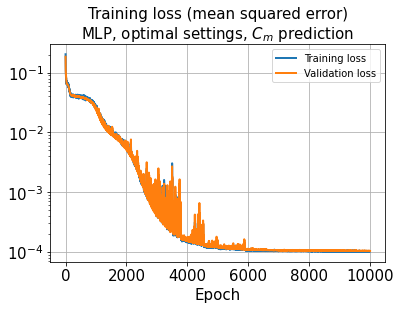

In [34]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

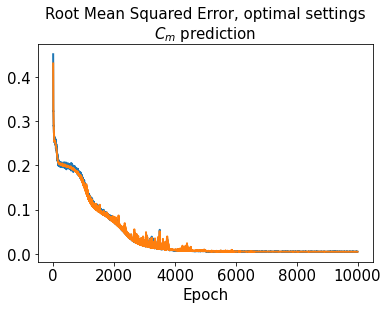

In [35]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

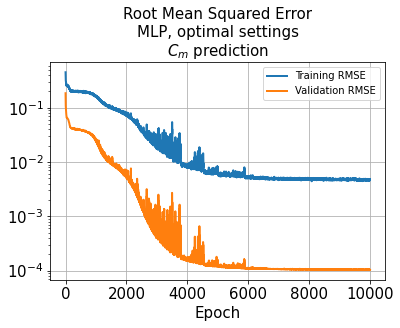

In [36]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [37]:
train_results = model.evaluate(x_train, y_train)

110/110 [==============================] - 0s 4ms/step - loss: 1.0222e-04 - rmse: 0.0047


In [38]:
val_results = model.evaluate(x_val, y_val)

32/32 [==============================] - 0s 4ms/step - loss: 1.0320e-04 - rmse: 0.0048


In [39]:
test_results = model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 4ms/step - loss: 1.1104e-04 - rmse: 0.0056


In [40]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

16/16 [==============================] - 0s 1ms/step


In [41]:
decoded_train_

array([[0.89020705],
       [0.16928555],
       [0.9696174 ],
       ...,
       [0.3433881 ],
       [0.96974075],
       [0.98395175]], dtype=float32)

In [42]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [43]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [44]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [45]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [46]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [47]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [48]:
model_directory = "D:\\TrainedModels\\20221227"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221227unsteadyValidation_MLP_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_randomState1(9to14)CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [49]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [50]:
os.chdir(storage_dir)

In [51]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [52]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = smape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.01338719749703065
0.6284783369407331


In [53]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= smape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.01349470771411851
0.6388982720044891


In [54]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= smape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.016848369396630553
0.7898876105381719


In [55]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [56]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [57]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [58]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [59]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [60]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [61]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

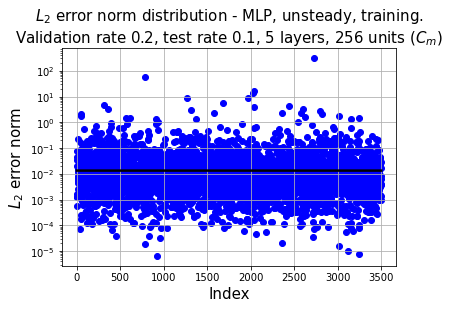

In [62]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

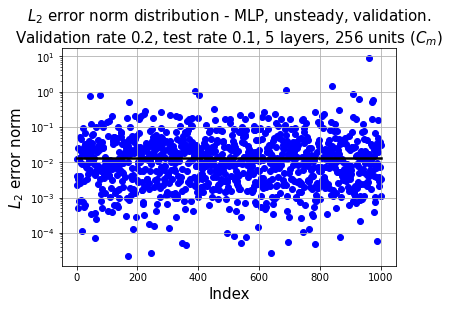

In [63]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

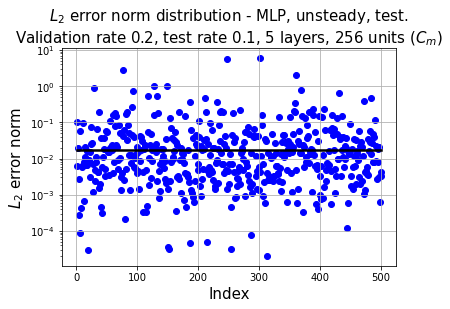

In [64]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [65]:
predicted = model.predict(x)

157/157 [==============================] - 0s 2ms/step


In [68]:
predicted.shape

(5000, 1)

In [69]:
t_train = t[index_train]
t_val = t[index_val]
t_test = t[index_test]

In [70]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [71]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [72]:
x += 10

In [73]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(x, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(x, denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cm: 0.0108


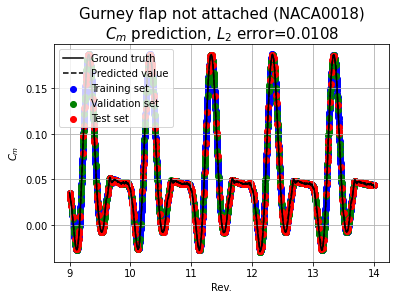

In [74]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(0, 1):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted#[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain = np.array(iTrain)
    iVal = np.array(iVal)
    iTest = np.array(iTest)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tTest, iTrain, iTest)

In [75]:
len(x_train)

3499

In [76]:
len(x_test)

500

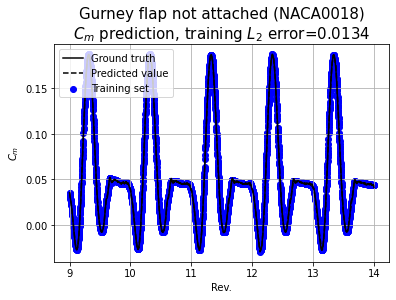

In [77]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, training $L_2$ error=%.4f' % l2_error_train
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

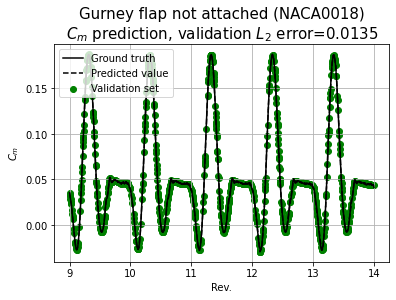

In [78]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, validation $L_2$ error=%.4f' % l2_error_val
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

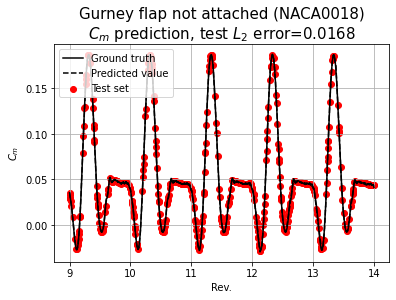

In [79]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, test $L_2$ error=%.4f' % l2_error_test
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()